In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.6.6
IPython 6.5.0

numpy 1.15.2
sklearn 0.20.0
scipy 1.1.0
matplotlib 2.2.3
tensorflow 1.12.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [4]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [5]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [6]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [7]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [8]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [9]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.181838	최선의 손실: 0.181838	정확도: 96.40%
1	검증 세트 손실: 0.222739	최선의 손실: 0.181838	정확도: 96.52%
2	검증 세트 손실: 0.928452	최선의 손실: 0.181838	정확도: 67.32%
3	검증 세트 손실: 0.330987	최선의 손실: 0.181838	정확도: 90.50%
4	검증 세트 손실: 0.149206	최선의 손실: 0.149206	정확도: 96.64%
5	검증 세트 손실: 0.171556	최선의 손실: 0.149206	정확도: 97.26%
6	검증 세트 손실: 0.146951	최선의 손실: 0.146951	정확도: 97.11%
7	검증 세트 손실: 0.170041	최선의 손실: 0.146951	정확도: 96.52%
8	검증 세트 손실: 0.104613	최선의 손실: 0.104613	정확도: 97.73%
9	검증 세트 손실: 37.666958	최선의 손실: 0.104613	정확도: 97.34%
10	검증 세트 손실: 0.207292	최선의 손실: 0.104613	정확도: 96.48%
11	검증 세트 손실: 7.849225	최선의 손실: 0.104613	정확도: 96.33%
12	검증 세트 손실: 0.442569	최선의 손실: 0.104613	정확도: 78.46%
13	검증 세트 손실: 0.481543	최선의 손실: 0.104613	정확도: 78.62%
14	검증 세트 손실: 0.460953	최선의 손실: 0.104613	정확도: 78.62%
15	검증 세트 손실: 0.502912	최선의 손실: 0.104613	정확도: 78.11%
16	검증 세트 손실: 0.607881	최선의 손실: 0.104613	정확도: 74.20%
17	검증 세트 손실: 0.195923	최선의 손실: 0.104613	정확도: 96.29%
18	검증 세트 손실: 0.773360	최선의 손실: 0.104613	정확도: 67.83%
19	검증 세트 손실: 4.652513	최선의 손실: 0.104613	정

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [11]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.130467	최선의 손실: 0.130467	정확도: 97.30%
1	검증 세트 손실: 0.122616	최선의 손실: 0.122616	정확도: 97.77%
2	검증 세트 손실: 0.176131	최선의 손실: 0.122616	정확도: 97.26%
3	검증 세트 손실: 0.258317	최선의 손실: 0.122616	정확도: 93.59%
4	검증 세트 손실: 0.201294	최선의 손실: 0.122616	정확도: 96.17%
5	검증 세트 손실: 0.146604	최선의 손실: 0.122616	정확도: 96.56%
6	검증 세트 손실: 0.092800	최선의 손실: 0.092800	정확도: 97.89%
7	검증 세트 손실: 0.394486	최선의 손실: 0.092800	정확도: 82.13%
8	검증 세트 손실: 0.118447	최선의 손실: 0.092800	정확도: 97.81%
9	검증 세트 손실: 0.127473	최선의 손실: 0.092800	정확도: 97.30%
10	검증 세트 손실: 0.100953	최선의 손실: 0.092800	정확도: 98.28%
11	검증 세트 손실: 0.114409	최선의 손실: 0.092800	정확도: 98.16%
12	검증 세트 손실: 0.238825	최선의 손실: 0.092800	정확도: 95.86%
13	검증 세트 손실: 0.173809	최선의 손실: 0.092800	정확도: 97.81%
14	검증 세트 손실: 0.577488	최선의 손실: 0.092800	정확도: 78.85%
15	검증 세트 손실: 0.468072	최선의 손실: 0.092800	정확도: 78.42%
16	검증 세트 손실: 0.521219	최선의 손실: 0.092800	정확도: 79.05%
17	검증 세트 손실: 0.436852	최선의 손실: 0.092800	정확도: 79.12%
18	검증 세트 손실: 0.535977	최선의 손실: 0.092800	정확도: 79.52%
19	검증 세트 손실: 1.581222	최선의 손실: 0.092800	정확

DNNClassifier(activation=<function elu at 0x7f482e5f10d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [12]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9797625997275735

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

*사이킷런 0.22 버전에서 cross_val_score 함수와 GridSearchCV, RandomizedSearchCV 클래스의 cv 매개변수 기본값이 3에서 5로 바뀔 예정입니다. 0.20 버전에서 cv 매개변수를 지정하지 않는 경우 이에 관한 경고 메세지가 출력됩니다. 경고 메세지를 피하기 위해 cv 매개변수 값을 명시적으로 3으로 지정합니다.*

In [13]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7f482e5f10d0> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.286659	최선의 손실: 0.286659	정확도: 93.24%
1	검증 세트 손실: 0.123074	최선의 손실: 0.123074	정확도: 97.30%
2	검증 세트 손실: 0.120591	최선의 손실: 0.120591	정확도: 97.07%
3	검증 세트 손실: 0.127779	최선의 손실: 0.120591	정확도: 96.91%
4	검증 세트 손실: 0.106498	최선의 손실: 0.106498	정확도: 97.19%
5	검증 세트 손실: 0.132649	최선의 손실: 0.106498	정확도: 96.76%
6	검증 세트 손실: 0.216658	최선의 손실: 0.106498	정확도: 94.18%
7	검증 세트 손실: 0.118795	최선의 손실: 0.106498	정확도: 96.72%
8	검증 세트 손실: 0.104600	최선의 손실: 0.104600	정확도: 97.42%
9	검증 세트 손실: 0.127365	최선의 손실: 0.104600	정확도: 96.48%
10	검증 세트 손실: 0.162556	최선의 손실: 0.104600	정확도: 96.72%
11	검증 세트 손실: 0.156763	최선의 손실: 0.104600	정확도: 96.36%
12	검증 세트 손실: 0.189163	최선의 손실: 0.104600	정확도: 95.97%
13	검증 세트 손실: 1.732670	최선의 손실: 0.104600	정확도: 18.73%
14	검증 세트 손실: 1.621623	최선의 손실: 0.104600	정확도: 20.91%
15	검증 세트 손실: 1.615972	최선의 손실: 0.104600	정확도: 22.01%
16	검증 세트 손실: 1.610769	최선의 손실: 0.104600	정확도: 19.08%
17	검증 세트 손실: 1.616291	최선의 손실: 0.104600	정확도: 19.27%
18	검증 세트 손실: 1.681803	최선의 손실: 0.104600	정확도: 22.01%
19	검증 세트 손실: 1.628470	최선의 손실: 0.104600	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


0	검증 세트 손실: 0.185568	최선의 손실: 0.185568	정확도: 95.74%
1	검증 세트 손실: 0.139123	최선의 손실: 0.139123	정확도: 97.11%
2	검증 세트 손실: 0.139343	최선의 손실: 0.139123	정확도: 96.64%
3	검증 세트 손실: 0.187580	최선의 손실: 0.139123	정확도: 96.25%
4	검증 세트 손실: 1.337599	최선의 손실: 0.139123	정확도: 35.89%
5	검증 세트 손실: 1.226708	최선의 손실: 0.139123	정확도: 43.90%
6	검증 세트 손실: 0.794379	최선의 손실: 0.139123	정확도: 63.02%
7	검증 세트 손실: 0.927424	최선의 손실: 0.139123	정확도: 62.63%
8	검증 세트 손실: 0.427080	최선의 손실: 0.139123	정확도: 82.64%
9	검증 세트 손실: 0.378933	최선의 손실: 0.139123	정확도: 87.84%
10	검증 세트 손실: 0.438344	최선의 손실: 0.139123	정확도: 87.84%
11	검증 세트 손실: 0.302510	최선의 손실: 0.139123	정확도: 92.34%
12	검증 세트 손실: 0.294068	최선의 손실: 0.139123	정확도: 92.61%
13	검증 세트 손실: 0.305502	최선의 손실: 0.139123	정확도: 93.67%
14	검증 세트 손실: 0.296342	최선의 손실: 0.139123	정확도: 93.16%
15	검증 세트 손실: 0.886100	최선의 손실: 0.139123	정확도: 58.60%
16	검증 세트 손실: 0.540573	최선의 손실: 0.139123	정확도: 83.93%
17	검증 세트 손실: 0.322576	최선의 손실: 0.139123	정확도: 93.12%
18	검증 세트 손실: 0.332564	최선의 손실: 0.139123	정확도: 91.91%
19	검증 세트 손실: 0.307835	최선의 손실: 0.139123	정확

5	검증 세트 손실: 7.305023	최선의 손실: 3.539981	정확도: 83.46%
6	검증 세트 손실: 8.921552	최선의 손실: 3.539981	정확도: 84.79%
7	검증 세트 손실: 4.717057	최선의 손실: 3.539981	정확도: 89.60%
8	검증 세트 손실: 5.943274	최선의 손실: 3.539981	정확도: 88.58%
9	검증 세트 손실: 112.675652	최선의 손실: 3.539981	정확도: 33.85%
10	검증 세트 손실: 30.660980	최선의 손실: 3.539981	정확도: 51.06%
11	검증 세트 손실: 28.274158	최선의 손실: 3.539981	정확도: 48.12%
12	검증 세트 손실: 27.184910	최선의 손실: 3.539981	정확도: 44.02%
13	검증 세트 손실: 45.249046	최선의 손실: 3.539981	정확도: 30.73%
14	검증 세트 손실: 15.743232	최선의 손실: 3.539981	정확도: 50.78%
15	검증 세트 손실: 12.292155	최선의 손실: 3.539981	정확도: 51.33%
16	검증 세트 손실: 7.095677	최선의 손실: 3.539981	정확도: 57.97%
17	검증 세트 손실: 5.811168	최선의 손실: 3.539981	정확도: 58.56%
18	검증 세트 손실: 11.502675	최선의 손실: 3.539981	정확도: 50.43%
19	검증 세트 손실: 18.382357	최선의 손실: 3.539981	정확도: 43.24%
20	검증 세트 손실: 28.640945	최선의 손실: 3.539981	정확도: 54.96%
21	검증 세트 손실: 18.922501	최선의 손실: 3.539981	정확도: 56.80%
22	검증 세트 손실: 3.112056	최선의 손실: 3.112056	정확도: 75.45%
23	검증 세트 손실: 5.427745	최선의 손실: 3.112056	정확도: 74.78%
24	검증 세트 손실: 4.181856	최선

13	검증 세트 손실: 1125.906860	최선의 손실: 0.201405	정확도: 91.36%
14	검증 세트 손실: 1024.759399	최선의 손실: 0.201405	정확도: 93.00%
15	검증 세트 손실: 724.311096	최선의 손실: 0.201405	정확도: 95.66%
16	검증 세트 손실: 1185.537354	최선의 손실: 0.201405	정확도: 94.64%
17	검증 세트 손실: 5797.165039	최선의 손실: 0.201405	정확도: 88.94%
18	검증 세트 손실: 1776.432617	최선의 손실: 0.201405	정확도: 89.64%
19	검증 세트 손실: 441.722046	최선의 손실: 0.201405	정확도: 96.56%
20	검증 세트 손실: 541.972412	최선의 손실: 0.201405	정확도: 91.95%
21	검증 세트 손실: 362.828003	최선의 손실: 0.201405	정확도: 96.83%
22	검증 세트 손실: 291487.000000	최선의 손실: 0.201405	정확도: 86.47%
23	검증 세트 손실: 112921.984375	최선의 손실: 0.201405	정확도: 91.05%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>, total=  11.1s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60> 
0	검증 세트 손실: 201.237762	최선의 손실: 201.237762	정확도: 71.50%
1	검증 세트 손실: 94.853264	최선의 손실: 94.853264	정확도: 90.66%
2	

0	검증 세트 손실: 0.120097	최선의 손실: 0.120097	정확도: 96.99%
1	검증 세트 손실: 0.068051	최선의 손실: 0.068051	정확도: 98.20%
2	검증 세트 손실: 0.066180	최선의 손실: 0.066180	정확도: 97.73%
3	검증 세트 손실: 0.054414	최선의 손실: 0.054414	정확도: 98.32%
4	검증 세트 손실: 0.051011	최선의 손실: 0.051011	정확도: 98.36%
5	검증 세트 손실: 0.045178	최선의 손실: 0.045178	정확도: 98.51%
6	검증 세트 손실: 0.045421	최선의 손실: 0.045178	정확도: 98.59%
7	검증 세트 손실: 0.043793	최선의 손실: 0.043793	정확도: 98.83%
8	검증 세트 손실: 0.045473	최선의 손실: 0.043793	정확도: 98.32%
9	검증 세트 손실: 0.044551	최선의 손실: 0.043793	정확도: 98.94%
10	검증 세트 손실: 0.057133	최선의 손실: 0.043793	정확도: 98.75%
11	검증 세트 손실: 0.055599	최선의 손실: 0.043793	정확도: 98.71%
12	검증 세트 손실: 0.048705	최선의 손실: 0.043793	정확도: 98.51%
13	검증 세트 손실: 0.054603	최선의 손실: 0.043793	정확도: 98.75%
14	검증 세트 손실: 0.063535	최선의 손실: 0.043793	정확도: 98.75%
15	검증 세트 손실: 0.050351	최선의 손실: 0.043793	정확도: 98.67%
16	검증 세트 손실: 0.051391	최선의 손실: 0.043793	정확도: 98.91%
17	검증 세트 손실: 0.052274	최선의 손실: 0.043793	정확도: 98.91%
18	검증 세트 손실: 0.058948	최선의 손실: 0.043793	정확도: 98.67%
19	검증 세트 손실: 0.070308	최선의 손실: 0.043793	정확

0	검증 세트 손실: 0.123220	최선의 손실: 0.123220	정확도: 95.93%
1	검증 세트 손실: 0.083362	최선의 손실: 0.083362	정확도: 97.30%
2	검증 세트 손실: 0.065929	최선의 손실: 0.065929	정확도: 97.77%
3	검증 세트 손실: 0.059004	최선의 손실: 0.059004	정확도: 97.89%
4	검증 세트 손실: 0.071267	최선의 손실: 0.059004	정확도: 97.58%
5	검증 세트 손실: 0.065772	최선의 손실: 0.059004	정확도: 97.89%
6	검증 세트 손실: 0.048407	최선의 손실: 0.048407	정확도: 98.51%
7	검증 세트 손실: 0.057426	최선의 손실: 0.048407	정확도: 98.24%
8	검증 세트 손실: 0.053040	최선의 손실: 0.048407	정확도: 98.44%
9	검증 세트 손실: 0.054299	최선의 손실: 0.048407	정확도: 98.63%
10	검증 세트 손실: 0.055948	최선의 손실: 0.048407	정확도: 98.48%
11	검증 세트 손실: 0.062518	최선의 손실: 0.048407	정확도: 98.67%
12	검증 세트 손실: 0.058235	최선의 손실: 0.048407	정확도: 98.55%
13	검증 세트 손실: 0.057299	최선의 손실: 0.048407	정확도: 98.98%
14	검증 세트 손실: 0.056202	최선의 손실: 0.048407	정확도: 98.71%
15	검증 세트 손실: 0.069447	최선의 손실: 0.048407	정확도: 98.87%
16	검증 세트 손실: 0.059918	최선의 손실: 0.048407	정확도: 98.71%
17	검증 세트 손실: 0.057227	최선의 손실: 0.048407	정확도: 98.98%
18	검증 세트 손실: 0.063826	최선의 손실: 0.048407	정확도: 98.59%
19	검증 세트 손실: 0.061788	최선의 손실: 0.048407	정확

53	검증 세트 손실: 1.618522	최선의 손실: 1.607884	정확도: 22.01%
54	검증 세트 손실: 1.654810	최선의 손실: 1.607884	정확도: 18.73%
55	검증 세트 손실: 1.645115	최선의 손실: 1.607884	정확도: 18.73%
56	검증 세트 손실: 1.669472	최선의 손실: 1.607884	정확도: 19.08%
57	검증 세트 손실: 1.619669	최선의 손실: 1.607884	정확도: 18.73%
58	검증 세트 손실: 1.612547	최선의 손실: 1.607884	정확도: 22.01%
59	검증 세트 손실: 1.619514	최선의 손실: 1.607884	정확도: 22.01%
60	검증 세트 손실: 1.635965	최선의 손실: 1.607884	정확도: 18.73%
61	검증 세트 손실: 1.627399	최선의 손실: 1.607884	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x7f482e59e400>, total= 1.7min
[CV] n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x7f482e59e400> 
0	검증 세트 손실: 1.644703	최선의 손실: 1.644703	정확도: 19.27%
1	검증 세트 손실: 1.624410	최선의 손실: 1.624410	정확도: 19.27%
2	검증 세트 손실: 1.614139	최선의 손실: 1.614139	정확도: 19.27%
3	검증 세트 손실: 1.616997	최선의 손실: 1.614139	정확도: 19.27%
4	검증 세트 손실: 1.614502	최선의 손실: 1.614139	정확도: 22.01%
5	검증 세트 손실: 1.627702	최선의 손실: 1.614139	정확도: 22.01%
6	검증 세트 손실: 1.648679	

24	검증 세트 손실: 0.118420	최선의 손실: 0.060381	정확도: 98.01%
25	검증 세트 손실: 0.103011	최선의 손실: 0.060381	정확도: 98.40%
26	검증 세트 손실: 0.084698	최선의 손실: 0.060381	정확도: 98.28%
27	검증 세트 손실: 0.080921	최선의 손실: 0.060381	정확도: 98.79%
28	검증 세트 손실: 0.082956	최선의 손실: 0.060381	정확도: 98.55%
29	검증 세트 손실: 0.128678	최선의 손실: 0.060381	정확도: 98.36%
30	검증 세트 손실: 0.095749	최선의 손실: 0.060381	정확도: 98.24%
31	검증 세트 손실: 0.081600	최선의 손실: 0.060381	정확도: 98.51%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7f482e59e400>, total=   6.3s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90> 
0	검증 세트 손실: 0.163040	최선의 손실: 0.163040	정확도: 96.09%
1	검증 세트 손실: 2.280268	최선의 손실: 0.163040	정확도: 32.02%
2	검증 세트 손실: 0.509261	최선의 손실: 0.163040	정확도: 82.56%
3	검증 세트 손실: 0.340459	최선의 손실: 0.163040	정확도: 89.05%
4	검증 세트 손실: 0.233781	최선의 손실: 0.163040	정확도: 92.96%
5	검증 세트 손실: 0.221907	최선의 손실: 0.163040	정확도: 93.20%
6	검증 세트 손실: 0.188471	최선의 손실: 

21	검증 세트 손실: 0.201256	최선의 손실: 0.077277	정확도: 97.69%
22	검증 세트 손실: 0.161640	최선의 손실: 0.077277	정확도: 97.65%
23	검증 세트 손실: 0.136248	최선의 손실: 0.077277	정확도: 97.89%
24	검증 세트 손실: 0.130095	최선의 손실: 0.077277	정확도: 98.36%
25	검증 세트 손실: 0.136969	최선의 손실: 0.077277	정확도: 98.40%
26	검증 세트 손실: 0.813945	최선의 손실: 0.077277	정확도: 97.58%
27	검증 세트 손실: 0.150615	최선의 손실: 0.077277	정확도: 97.26%
28	검증 세트 손실: 0.092996	최선의 손실: 0.077277	정확도: 98.44%
29	검증 세트 손실: 0.138987	최선의 손실: 0.077277	정확도: 97.93%
30	검증 세트 손실: 0.147619	최선의 손실: 0.077277	정확도: 98.24%
31	검증 세트 손실: 0.899982	최선의 손실: 0.077277	정확도: 94.88%
32	검증 세트 손실: 1.531578	최선의 손실: 0.077277	정확도: 97.26%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>, total=  14.9s
[CV] n_neurons=50, learning_rate=0.01, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60> 
0	검증 세트 손실: 0.096850	최선의 손실: 0.096850	정확도: 97.54%
1	검증 세트 손실: 0.093685	최선의 손실: 0.093685	

12	검증 세트 손실: 1.129001	최선의 손실: 1.129001	정확도: 40.42%
13	검증 세트 손실: 1.135428	최선의 손실: 1.129001	정확도: 40.38%
14	검증 세트 손실: 1.126431	최선의 손실: 1.126431	정확도: 40.58%
15	검증 세트 손실: 1.126947	최선의 손실: 1.126431	정확도: 40.85%
16	검증 세트 손실: 1.131136	최선의 손실: 1.126431	정확도: 40.70%
17	검증 세트 손실: 2.936843	최선의 손실: 1.126431	정확도: 19.27%
18	검증 세트 손실: 1.650227	최선의 손실: 1.126431	정확도: 22.01%
19	검증 세트 손실: 1.614662	최선의 손실: 1.126431	정확도: 18.73%
20	검증 세트 손실: 1.625880	최선의 손실: 1.126431	정확도: 20.91%
21	검증 세트 손실: 1.610761	최선의 손실: 1.126431	정확도: 22.01%
22	검증 세트 손실: 1.617516	최선의 손실: 1.126431	정확도: 19.08%
23	검증 세트 손실: 1.612151	최선의 손실: 1.126431	정확도: 19.27%
24	검증 세트 손실: 1.635963	최선의 손실: 1.126431	정확도: 22.01%
25	검증 세트 손실: 1.613843	최선의 손실: 1.126431	정확도: 19.08%
26	검증 세트 손실: 1.621426	최선의 손실: 1.126431	정확도: 22.01%
27	검증 세트 손실: 1.617398	최선의 손실: 1.126431	정확도: 19.08%
28	검증 세트 손실: 1.641430	최선의 손실: 1.126431	정확도: 19.08%
29	검증 세트 손실: 1.620762	최선의 손실: 1.126431	정확도: 18.73%
30	검증 세트 손실: 1.624161	최선의 손실: 1.126431	정확도: 19.27%
31	검증 세트 손실: 1.619384	최선의 손실: 1

9	검증 세트 손실: 835.320251	최선의 손실: 0.283819	정확도: 70.56%
10	검증 세트 손실: 425.156677	최선의 손실: 0.283819	정확도: 84.13%
11	검증 세트 손실: 1413.020264	최선의 손실: 0.283819	정확도: 66.69%
12	검증 세트 손실: 1449.670044	최선의 손실: 0.283819	정확도: 77.21%
13	검증 세트 손실: 435.772369	최선의 손실: 0.283819	정확도: 89.87%
14	검증 세트 손실: 427.029510	최선의 손실: 0.283819	정확도: 88.31%
15	검증 세트 손실: 722.539490	최선의 손실: 0.283819	정확도: 76.94%
16	검증 세트 손실: 2696.729492	최선의 손실: 0.283819	정확도: 51.17%
17	검증 세트 손실: 1636.561768	최선의 손실: 0.283819	정확도: 65.87%
18	검증 세트 손실: 215.930023	최선의 손실: 0.283819	정확도: 85.18%
19	검증 세트 손실: 911.325256	최선의 손실: 0.283819	정확도: 63.96%
20	검증 세트 손실: 246.485001	최선의 손실: 0.283819	정확도: 85.46%
21	검증 세트 손실: 207.484116	최선의 손실: 0.283819	정확도: 88.08%
22	검증 세트 손실: 228.034210	최선의 손실: 0.283819	정확도: 87.72%
23	검증 세트 손실: 129543.531250	최선의 손실: 0.283819	정확도: 32.17%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90>, total=  11.1s
[CV] n_neurons=100, learning_rate=0.1,

7	검증 세트 손실: 13281.370117	최선의 손실: 0.101645	정확도: 85.81%
8	검증 세트 손실: 4468.183105	최선의 손실: 0.101645	정확도: 91.05%
9	검증 세트 손실: 2747.728760	최선의 손실: 0.101645	정확도: 92.42%
10	검증 세트 손실: 2916.778320	최선의 손실: 0.101645	정확도: 92.73%
11	검증 세트 손실: 1634.749023	최선의 손실: 0.101645	정확도: 92.89%
12	검증 세트 손실: 1730.149170	최선의 손실: 0.101645	정확도: 93.51%
13	검증 세트 손실: 1167.039673	최선의 손실: 0.101645	정확도: 94.96%
14	검증 세트 손실: 986.239807	최선의 손실: 0.101645	정확도: 95.19%
15	검증 세트 손실: 1897.189209	최선의 손실: 0.101645	정확도: 91.59%
16	검증 세트 손실: 733.915466	최선의 손실: 0.101645	정확도: 95.54%
17	검증 세트 손실: 717.528320	최선의 손실: 0.101645	정확도: 95.11%
18	검증 세트 손실: 706.167725	최선의 손실: 0.101645	정확도: 95.62%
19	검증 세트 손실: 1022.580322	최선의 손실: 0.101645	정확도: 93.75%
20	검증 세트 손실: 634.637878	최선의 손실: 0.101645	정확도: 95.31%
21	검증 세트 손실: 914.343018	최선의 손실: 0.101645	정확도: 94.49%
22	검증 세트 손실: 586.743896	최선의 손실: 0.101645	정확도: 93.86%
23	검증 세트 손실: 557.499634	최선의 손실: 0.101645	정확도: 95.82%
24	검증 세트 손실: 525.458374	최선의 손실: 0.101645	정확도: 94.45%
25	검증 세트 손실: 532.629578	최선의 손실: 0.10164

24	검증 세트 손실: 0.087856	최선의 손실: 0.048829	정확도: 98.44%
25	검증 세트 손실: 0.077324	최선의 손실: 0.048829	정확도: 98.79%
26	검증 세트 손실: 0.079645	최선의 손실: 0.048829	정확도: 98.87%
27	검증 세트 손실: 0.074451	최선의 손실: 0.048829	정확도: 98.75%
28	검증 세트 손실: 0.071806	최선의 손실: 0.048829	정확도: 98.83%
29	검증 세트 손실: 0.071770	최선의 손실: 0.048829	정확도: 98.87%
30	검증 세트 손실: 0.064752	최선의 손실: 0.048829	정확도: 98.59%
31	검증 세트 손실: 0.069637	최선의 손실: 0.048829	정확도: 98.67%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7f482e5f10d0>, total=   2.3s
[CV] n_neurons=90, learning_rate=0.02, batch_size=500, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.142717	최선의 손실: 0.142717	정확도: 96.09%
1	검증 세트 손실: 0.077565	최선의 손실: 0.077565	정확도: 97.54%
2	검증 세트 손실: 0.068073	최선의 손실: 0.068073	정확도: 97.81%
3	검증 세트 손실: 0.056799	최선의 손실: 0.056799	정확도: 98.24%
4	검증 세트 손실: 0.057231	최선의 손실: 0.056799	정확도: 98.32%
5	검증 세트 손실: 0.047565	최선의 손실: 0.047565	정확도: 98.51%
6	검증 세트 손실: 0.064708	최선의 손실: 0.047565	정확도: 97.97%
7	검증 세트 손실: 0.062885

1	검증 세트 손실: 0.111787	최선의 손실: 0.111787	정확도: 96.91%
2	검증 세트 손실: 0.126415	최선의 손실: 0.111787	정확도: 96.64%
3	검증 세트 손실: 0.134945	최선의 손실: 0.111787	정확도: 96.99%
4	검증 세트 손실: 1995.225586	최선의 손실: 0.111787	정확도: 54.14%
5	검증 세트 손실: 23.851175	최선의 손실: 0.111787	정확도: 89.95%
6	검증 세트 손실: 30.626884	최선의 손실: 0.111787	정확도: 80.18%
7	검증 세트 손실: 8.783970	최선의 손실: 0.111787	정확도: 92.85%
8	검증 세트 손실: 7.338202	최선의 손실: 0.111787	정확도: 94.33%
9	검증 세트 손실: 5.648532	최선의 손실: 0.111787	정확도: 94.84%
10	검증 세트 손실: 6.128572	최선의 손실: 0.111787	정확도: 94.10%
11	검증 세트 손실: 5.021872	최선의 손실: 0.111787	정확도: 95.04%
12	검증 세트 손실: 5.759395	최선의 손실: 0.111787	정확도: 94.37%
13	검증 세트 손실: 5.413419	최선의 손실: 0.111787	정확도: 96.17%
14	검증 세트 손실: 19.614939	최선의 손실: 0.111787	정확도: 83.54%
15	검증 세트 손실: 5.049332	최선의 손실: 0.111787	정확도: 95.39%
16	검증 세트 손실: 6.098862	최선의 손실: 0.111787	정확도: 93.51%
17	검증 세트 손실: 4.869947	최선의 손실: 0.111787	정확도: 96.01%
18	검증 세트 손실: 4.049302	최선의 손실: 0.111787	정확도: 96.09%
19	검증 세트 손실: 2.952997	최선의 손실: 0.111787	정확도: 95.74%
20	검증 세트 손실: 3.035173	최선의 손실: 0.11

9	검증 세트 손실: 0.171020	최선의 손실: 0.123421	정확도: 95.93%
10	검증 세트 손실: 0.149618	최선의 손실: 0.123421	정확도: 97.07%
11	검증 세트 손실: 0.455403	최선의 손실: 0.123421	정확도: 81.94%
12	검증 세트 손실: 0.230130	최선의 손실: 0.123421	정확도: 94.80%
13	검증 세트 손실: 0.216063	최선의 손실: 0.123421	정확도: 95.62%
14	검증 세트 손실: 0.332510	최선의 손실: 0.123421	정확도: 90.70%
15	검증 세트 손실: 0.228266	최선의 손실: 0.123421	정확도: 95.62%
16	검증 세트 손실: 0.467922	최선의 손실: 0.123421	정확도: 86.32%
17	검증 세트 손실: 0.364967	최선의 손실: 0.123421	정확도: 93.39%
18	검증 세트 손실: 0.481061	최선의 손실: 0.123421	정확도: 85.07%
19	검증 세트 손실: 0.350902	최선의 손실: 0.123421	정확도: 90.70%
20	검증 세트 손실: 0.926369	최선의 손실: 0.123421	정확도: 54.30%
21	검증 세트 손실: 0.797664	최선의 손실: 0.123421	정확도: 65.17%
22	검증 세트 손실: 0.586457	최선의 손실: 0.123421	정확도: 74.16%
23	검증 세트 손실: 0.555328	최선의 손실: 0.123421	정확도: 74.63%
24	검증 세트 손실: 0.556152	최선의 손실: 0.123421	정확도: 76.00%
25	검증 세트 손실: 0.491784	최선의 손실: 0.123421	정확도: 77.33%
26	검증 세트 손실: 3.383837	최선의 손실: 0.123421	정확도: 37.49%
27	검증 세트 손실: 0.934534	최선의 손실: 0.123421	정확도: 52.70%
28	검증 세트 손실: 0.832637	최선의 손실: 0.

10	검증 세트 손실: 0.102149	최선의 손실: 0.102149	정확도: 97.69%
11	검증 세트 손실: 0.103278	최선의 손실: 0.102149	정확도: 97.77%
12	검증 세트 손실: 0.110776	최선의 손실: 0.102149	정확도: 97.50%
13	검증 세트 손실: 0.112084	최선의 손실: 0.102149	정확도: 97.81%
14	검증 세트 손실: 0.097160	최선의 손실: 0.097160	정확도: 97.54%
15	검증 세트 손실: 0.098134	최선의 손실: 0.097160	정확도: 98.08%
16	검증 세트 손실: 0.081062	최선의 손실: 0.081062	정확도: 97.89%
17	검증 세트 손실: 0.117994	최선의 손실: 0.081062	정확도: 97.19%
18	검증 세트 손실: 0.085073	최선의 손실: 0.081062	정확도: 98.28%
19	검증 세트 손실: 0.092726	최선의 손실: 0.081062	정확도: 97.81%
20	검증 세트 손실: 0.094879	최선의 손실: 0.081062	정확도: 97.85%
21	검증 세트 손실: 0.078899	최선의 손실: 0.078899	정확도: 97.85%
22	검증 세트 손실: 0.082607	최선의 손실: 0.078899	정확도: 98.28%
23	검증 세트 손실: 0.092380	최선의 손실: 0.078899	정확도: 97.65%
24	검증 세트 손실: 0.083993	최선의 손실: 0.078899	정확도: 98.05%
25	검증 세트 손실: 0.081906	최선의 손실: 0.078899	정확도: 98.28%
26	검증 세트 손실: 0.087697	최선의 손실: 0.078899	정확도: 98.05%
27	검증 세트 손실: 0.089171	최선의 손실: 0.078899	정확도: 98.08%
28	검증 세트 손실: 0.078931	최선의 손실: 0.078899	정확도: 98.32%
29	검증 세트 손실: 0.083292	최선의 손실: 0

27	검증 세트 손실: 0.115569	최선의 손실: 0.074136	정확도: 97.50%
28	검증 세트 손실: 0.108568	최선의 손실: 0.074136	정확도: 97.65%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90>, total=   2.4s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90> 
0	검증 세트 손실: 0.213791	최선의 손실: 0.213791	정확도: 93.98%
1	검증 세트 손실: 0.134713	최선의 손실: 0.134713	정확도: 96.36%
2	검증 세트 손실: 0.121845	최선의 손실: 0.121845	정확도: 96.48%
3	검증 세트 손실: 0.108226	최선의 손실: 0.108226	정확도: 97.19%
4	검증 세트 손실: 0.100809	최선의 손실: 0.100809	정확도: 97.30%
5	검증 세트 손실: 0.088644	최선의 손실: 0.088644	정확도: 97.65%
6	검증 세트 손실: 0.094325	최선의 손실: 0.088644	정확도: 97.38%
7	검증 세트 손실: 0.096629	최선의 손실: 0.088644	정확도: 97.19%
8	검증 세트 손실: 0.108288	최선의 손실: 0.088644	정확도: 96.99%
9	검증 세트 손실: 0.109991	최선의 손실: 0.088644	정확도: 96.64%
10	검증 세트 손실: 0.119474	최선의 손실: 0.088644	정확도: 96.72%
11	검증 세트 손실: 0.100639	최선의 손실: 0.088644	정확도: 9

16	검증 세트 손실: 1.635909	최선의 손실: 0.079516	정확도: 19.27%
17	검증 세트 손실: 1.619528	최선의 손실: 0.079516	정확도: 20.91%
18	검증 세트 손실: 1.633151	최선의 손실: 0.079516	정확도: 22.01%
19	검증 세트 손실: 1.630694	최선의 손실: 0.079516	정확도: 20.91%
20	검증 세트 손실: 1.630146	최선의 손실: 0.079516	정확도: 18.73%
21	검증 세트 손실: 1.668062	최선의 손실: 0.079516	정확도: 19.27%
22	검증 세트 손실: 1.614280	최선의 손실: 0.079516	정확도: 22.01%
23	검증 세트 손실: 1.627663	최선의 손실: 0.079516	정확도: 22.01%
24	검증 세트 손실: 1.647274	최선의 손실: 0.079516	정확도: 20.91%
25	검증 세트 손실: 1.618329	최선의 손실: 0.079516	정확도: 20.91%
26	검증 세트 손실: 1.645727	최선의 손실: 0.079516	정확도: 19.08%
27	검증 세트 손실: 1.654628	최선의 손실: 0.079516	정확도: 18.73%
28	검증 세트 손실: 1.636986	최선의 손실: 0.079516	정확도: 19.27%
29	검증 세트 손실: 1.623145	최선의 손실: 0.079516	정확도: 19.27%
30	검증 세트 손실: 1.632481	최선의 손실: 0.079516	정확도: 19.27%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f482e5f10d0>, total=   6.2s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leak

0	검증 세트 손실: 1.654511	최선의 손실: 1.654511	정확도: 19.08%
1	검증 세트 손실: 2.044580	최선의 손실: 1.654511	정확도: 20.91%
2	검증 세트 손실: 2.129665	최선의 손실: 1.654511	정확도: 22.01%
3	검증 세트 손실: 2.655621	최선의 손실: 1.654511	정확도: 22.01%
4	검증 세트 손실: 2.225945	최선의 손실: 1.654511	정확도: 22.01%
5	검증 세트 손실: 2.909106	최선의 손실: 1.654511	정확도: 18.73%
6	검증 세트 손실: 2.906639	최선의 손실: 1.654511	정확도: 18.73%
7	검증 세트 손실: 2.649807	최선의 손실: 1.654511	정확도: 19.08%
8	검증 세트 손실: 2.327966	최선의 손실: 1.654511	정확도: 18.73%
9	검증 세트 손실: 2.836302	최선의 손실: 1.654511	정확도: 20.91%
10	검증 세트 손실: 3.946775	최선의 손실: 1.654511	정확도: 19.08%
11	검증 세트 손실: 3.053000	최선의 손실: 1.654511	정확도: 19.08%
12	검증 세트 손실: 2.314834	최선의 손실: 1.654511	정확도: 18.73%
13	검증 세트 손실: 4.438856	최선의 손실: 1.654511	정확도: 19.08%
14	검증 세트 손실: 2.920101	최선의 손실: 1.654511	정확도: 19.27%
15	검증 세트 손실: 2.689551	최선의 손실: 1.654511	정확도: 18.73%
16	검증 세트 손실: 2.405867	최선의 손실: 1.654511	정확도: 22.01%
17	검증 세트 손실: 2.329477	최선의 손실: 1.654511	정확도: 20.91%
18	검증 세트 손실: 2.767597	최선의 손실: 1.654511	정확도: 22.01%
19	검증 세트 손실: 4.288300	최선의 손실: 1.654511	정확

20	검증 세트 손실: 24.787819	최선의 손실: 0.198961	정확도: 64.70%
21	검증 세트 손실: 28.924797	최선의 손실: 0.198961	정확도: 49.84%
22	검증 세트 손실: 71.190895	최선의 손실: 0.198961	정확도: 62.98%
23	검증 세트 손실: 91.958748	최선의 손실: 0.198961	정확도: 65.75%
24	검증 세트 손실: 175.860992	최선의 손실: 0.198961	정확도: 62.31%
25	검증 세트 손실: 232.678268	최선의 손실: 0.198961	정확도: 66.38%
26	검증 세트 손실: 243.178802	최선의 손실: 0.198961	정확도: 63.49%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90>, total=   2.3s
[CV] n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90> 
0	검증 세트 손실: 1.611676	최선의 손실: 1.611676	정확도: 28.26%
1	검증 세트 손실: 0.817355	최선의 손실: 0.817355	정확도: 70.45%
2	검증 세트 손실: 0.425342	최선의 손실: 0.425342	정확도: 89.48%
3	검증 세트 손실: 0.256637	최선의 손실: 0.256637	정확도: 92.85%
4	검증 세트 손실: 0.196929	최선의 손실: 0.196929	정확도: 95.35%
5	검증 세트 손실: 0.222469	최선의 손실: 0.196929	정확도: 93.82%
6	검증 세트 손실: 0.340056	최선의 손실: 0.19

8	검증 세트 손실: 0.072509	최선의 손실: 0.053951	정확도: 97.93%
9	검증 세트 손실: 0.056615	최선의 손실: 0.053951	정확도: 98.63%
10	검증 세트 손실: 0.089857	최선의 손실: 0.053951	정확도: 97.85%
11	검증 세트 손실: 0.058558	최선의 손실: 0.053951	정확도: 98.40%
12	검증 세트 손실: 0.057534	최선의 손실: 0.053951	정확도: 98.71%
13	검증 세트 손실: 0.074935	최선의 손실: 0.053951	정확도: 98.44%
14	검증 세트 손실: 0.068773	최선의 손실: 0.053951	정확도: 98.40%
15	검증 세트 손실: 0.085727	최선의 손실: 0.053951	정확도: 98.16%
16	검증 세트 손실: 0.078746	최선의 손실: 0.053951	정확도: 98.24%
17	검증 세트 손실: 0.068679	최선의 손실: 0.053951	정확도: 98.55%
18	검증 세트 손실: 0.070947	최선의 손실: 0.053951	정확도: 98.63%
19	검증 세트 손실: 0.083552	최선의 손실: 0.053951	정확도: 98.59%
20	검증 세트 손실: 0.073315	최선의 손실: 0.053951	정확도: 98.55%
21	검증 세트 손실: 0.070409	최선의 손실: 0.053951	정확도: 98.67%
22	검증 세트 손실: 0.084009	최선의 손실: 0.053951	정확도: 98.16%
23	검증 세트 손실: 0.064555	최선의 손실: 0.053951	정확도: 98.75%
24	검증 세트 손실: 0.067862	최선의 손실: 0.053951	정확도: 98.67%
25	검증 세트 손실: 0.066544	최선의 손실: 0.053951	정확도: 98.63%
26	검증 세트 손실: 0.077376	최선의 손실: 0.053951	정확도: 98.67%
27	검증 세트 손실: 0.072737	최선의 손실: 0.0

4	검증 세트 손실: 0.106951	최선의 손실: 0.087573	정확도: 96.76%
5	검증 세트 손실: 0.111609	최선의 손실: 0.087573	정확도: 97.19%
6	검증 세트 손실: 0.097382	최선의 손실: 0.087573	정확도: 97.77%
7	검증 세트 손실: 0.098784	최선의 손실: 0.087573	정확도: 97.62%
8	검증 세트 손실: 0.087383	최선의 손실: 0.087383	정확도: 97.65%
9	검증 세트 손실: 0.093626	최선의 손실: 0.087383	정확도: 97.81%
10	검증 세트 손실: 0.068160	최선의 손실: 0.068160	정확도: 98.28%
11	검증 세트 손실: 0.084472	최선의 손실: 0.068160	정확도: 97.89%
12	검증 세트 손실: 0.079617	최선의 손실: 0.068160	정확도: 97.77%
13	검증 세트 손실: 0.081377	최선의 손실: 0.068160	정확도: 98.01%
14	검증 세트 손실: 0.083743	최선의 손실: 0.068160	정확도: 98.01%
15	검증 세트 손실: 0.107372	최선의 손실: 0.068160	정확도: 97.89%
16	검증 세트 손실: 0.142318	최선의 손실: 0.068160	정확도: 96.79%
17	검증 세트 손실: 0.100943	최선의 손실: 0.068160	정확도: 97.50%
18	검증 세트 손실: 0.099956	최선의 손실: 0.068160	정확도: 98.05%
19	검증 세트 손실: 0.087411	최선의 손실: 0.068160	정확도: 98.20%
20	검증 세트 손실: 0.081765	최선의 손실: 0.068160	정확도: 97.97%
21	검증 세트 손실: 0.106861	최선의 손실: 0.068160	정확도: 98.12%
22	검증 세트 손실: 0.098874	최선의 손실: 0.068160	정확도: 97.69%
23	검증 세트 손실: 0.093515	최선의 손실: 0.06816

12	검증 세트 손실: 0.135499	최선의 손실: 0.092555	정확도: 96.91%
13	검증 세트 손실: 0.157116	최선의 손실: 0.092555	정확도: 97.22%
14	검증 세트 손실: 0.159336	최선의 손실: 0.092555	정확도: 96.56%
15	검증 세트 손실: 0.133012	최선의 손실: 0.092555	정확도: 97.46%
16	검증 세트 손실: 0.141634	최선의 손실: 0.092555	정확도: 97.58%
17	검증 세트 손실: 0.163638	최선의 손실: 0.092555	정확도: 97.38%
18	검증 세트 손실: 0.121796	최선의 손실: 0.092555	정확도: 97.50%
19	검증 세트 손실: 0.130972	최선의 손실: 0.092555	정확도: 97.50%
20	검증 세트 손실: 0.122148	최선의 손실: 0.092555	정확도: 97.38%
21	검증 세트 손실: 0.143535	최선의 손실: 0.092555	정확도: 96.36%
22	검증 세트 손실: 0.116064	최선의 손실: 0.092555	정확도: 97.69%
23	검증 세트 손실: 0.271589	최선의 손실: 0.092555	정확도: 96.29%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>, total=   6.3s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60> 
0	검증 세트 손실: 0.101788	최선의 손실: 0.101788	정확도: 97.07%
1	검증 세트 손실: 0.109605	최선의 손실: 0.10178

29	검증 세트 손실: 351677.281250	최선의 손실: 197.367569	정확도: 93.94%
30	검증 세트 손실: 603326.687500	최선의 손실: 197.367569	정확도: 92.34%
31	검증 세트 손실: 356175.156250	최선의 손실: 197.367569	정확도: 94.45%
32	검증 세트 손실: 492218.281250	최선의 손실: 197.367569	정확도: 87.45%
33	검증 세트 손실: 228964.984375	최선의 손실: 197.367569	정확도: 96.13%
34	검증 세트 손실: 370585.531250	최선의 손실: 197.367569	정확도: 93.90%
35	검증 세트 손실: 289586.343750	최선의 손실: 197.367569	정확도: 95.78%
36	검증 세트 손실: 286617.812500	최선의 손실: 197.367569	정확도: 95.23%
37	검증 세트 손실: 235416.968750	최선의 손실: 197.367569	정확도: 96.29%
38	검증 세트 손실: 165677.718750	최선의 손실: 197.367569	정확도: 96.48%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>, total=   9.9s
[CV] n_neurons=160, learning_rate=0.1, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60> 
0	검증 세트 손실: 205.398773	최선의 손실: 205.398773	정확도: 84.21%
1	검증 세트 손실: 3667.189209	최선의 손실: 205.398773	정확도: 64.62%
2	검증 세트 손

16	검증 세트 손실: 1.670244	최선의 손실: 0.085501	정확도: 18.73%
17	검증 세트 손실: 1.627374	최선의 손실: 0.085501	정확도: 19.08%
18	검증 세트 손실: 1.623120	최선의 손실: 0.085501	정확도: 22.01%
19	검증 세트 손실: 1.640922	최선의 손실: 0.085501	정확도: 19.08%
20	검증 세트 손실: 1.658803	최선의 손실: 0.085501	정확도: 19.27%
21	검증 세트 손실: 1.692882	최선의 손실: 0.085501	정확도: 19.27%
22	검증 세트 손실: 1.615783	최선의 손실: 0.085501	정확도: 18.73%
23	검증 세트 손실: 1.624592	최선의 손실: 0.085501	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7f482e5f10d0>, total=   4.9s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7f482e59e400> 
0	검증 세트 손실: 0.105742	최선의 손실: 0.105742	정확도: 96.99%
1	검증 세트 손실: 0.116263	최선의 손실: 0.105742	정확도: 96.68%
2	검증 세트 손실: 0.108625	최선의 손실: 0.105742	정확도: 97.11%
3	검증 세트 손실: 0.128548	최선의 손실: 0.105742	정확도: 96.64%
4	검증 세트 손실: 0.101199	최선의 손실: 0.101199	정확도: 97.15%
5	검증 세트 손실: 0.105558	최선의 손실: 0.101199	정확도: 97.11%
6	검증 세트 손실: 0.123354	최선의 손실: 0.101199	정확도: 96.79%
7	검증 세트 손실: 0.11020

0	검증 세트 손실: 0.198967	최선의 손실: 0.198967	정확도: 95.50%
1	검증 세트 손실: 1.146367	최선의 손실: 0.198967	정확도: 42.89%
2	검증 세트 손실: 0.693859	최선의 손실: 0.198967	정확도: 74.32%
3	검증 세트 손실: 0.283951	최선의 손실: 0.198967	정확도: 93.75%
4	검증 세트 손실: 0.726777	최선의 손실: 0.198967	정확도: 62.20%
5	검증 세트 손실: 0.725105	최선의 손실: 0.198967	정확도: 61.26%
6	검증 세트 손실: 0.547791	최선의 손실: 0.198967	정확도: 79.95%
7	검증 세트 손실: 0.489522	최선의 손실: 0.198967	정확도: 82.56%
8	검증 세트 손실: 0.636137	최선의 손실: 0.198967	정확도: 75.37%
9	검증 세트 손실: 0.495477	최선의 손실: 0.198967	정확도: 90.66%
10	검증 세트 손실: 0.429458	최선의 손실: 0.198967	정확도: 88.47%
11	검증 세트 손실: 0.299374	최선의 손실: 0.198967	정확도: 93.28%
12	검증 세트 손실: 0.397448	최선의 손실: 0.198967	정확도: 93.32%
13	검증 세트 손실: 0.520837	최선의 손실: 0.198967	정확도: 77.56%
14	검증 세트 손실: 0.279790	최선의 손실: 0.198967	정확도: 93.63%
15	검증 세트 손실: 0.356626	최선의 손실: 0.198967	정확도: 93.12%
16	검증 세트 손실: 0.413237	최선의 손실: 0.198967	정확도: 95.31%
17	검증 세트 손실: 0.679717	최선의 손실: 0.198967	정확도: 82.99%
18	검증 세트 손실: 0.315452	최선의 손실: 0.198967	정확도: 94.57%
19	검증 세트 손실: 1.649457	최선의 손실: 0.198967	정확

0	검증 세트 손실: 0.128902	최선의 손실: 0.128902	정확도: 96.05%
1	검증 세트 손실: 0.192661	최선의 손실: 0.128902	정확도: 94.45%
2	검증 세트 손실: 0.205104	최선의 손실: 0.128902	정확도: 95.15%
3	검증 세트 손실: 0.868726	최선의 손실: 0.128902	정확도: 54.69%
4	검증 세트 손실: 1.232226	최선의 손실: 0.128902	정확도: 39.37%
5	검증 세트 손실: 1.156060	최선의 손실: 0.128902	정확도: 39.87%
6	검증 세트 손실: 1.160301	최선의 손실: 0.128902	정확도: 40.38%
7	검증 세트 손실: 1.147151	최선의 손실: 0.128902	정확도: 40.38%
8	검증 세트 손실: 1.167317	최선의 손실: 0.128902	정확도: 40.38%
9	검증 세트 손실: 1.162482	최선의 손실: 0.128902	정확도: 40.15%
10	검증 세트 손실: 1.142796	최선의 손실: 0.128902	정확도: 41.99%
11	검증 세트 손실: 1.146106	최선의 손실: 0.128902	정확도: 40.15%
12	검증 세트 손실: 1.141303	최선의 손실: 0.128902	정확도: 40.15%
13	검증 세트 손실: 1.147452	최선의 손실: 0.128902	정확도: 39.87%
14	검증 세트 손실: 1.145788	최선의 손실: 0.128902	정확도: 40.15%
15	검증 세트 손실: 1.144304	최선의 손실: 0.128902	정확도: 40.15%
16	검증 세트 손실: 1.143302	최선의 손실: 0.128902	정확도: 39.87%
17	검증 세트 손실: 1.142925	최선의 손실: 0.128902	정확도: 40.38%
18	검증 세트 손실: 1.153622	최선의 손실: 0.128902	정확도: 39.87%
19	검증 세트 손실: 1.144200	최선의 손실: 0.128902	정확

17	검증 세트 손실: 0.600088	최선의 손실: 0.593812	정확도: 96.21%
18	검증 세트 손실: 0.774948	최선의 손실: 0.593812	정확도: 95.43%
19	검증 세트 손실: 0.563791	최선의 손실: 0.563791	정확도: 95.54%
20	검증 세트 손실: 0.464761	최선의 손실: 0.464761	정확도: 96.36%
21	검증 세트 손실: 0.383785	최선의 손실: 0.383785	정확도: 96.83%
22	검증 세트 손실: 0.355355	최선의 손실: 0.355355	정확도: 96.79%
23	검증 세트 손실: 0.400589	최선의 손실: 0.355355	정확도: 94.37%
24	검증 세트 손실: 0.573869	최선의 손실: 0.355355	정확도: 95.82%
25	검증 세트 손실: 0.400809	최선의 손실: 0.355355	정확도: 96.44%
26	검증 세트 손실: 0.456426	최선의 손실: 0.355355	정확도: 96.25%
27	검증 세트 손실: 0.366603	최선의 손실: 0.355355	정확도: 96.48%
28	검증 세트 손실: 0.291689	최선의 손실: 0.291689	정확도: 96.64%
29	검증 세트 손실: 0.276656	최선의 손실: 0.276656	정확도: 96.95%
30	검증 세트 손실: 0.530487	최선의 손실: 0.276656	정확도: 97.07%
31	검증 세트 손실: 0.279953	최선의 손실: 0.276656	정확도: 97.46%
32	검증 세트 손실: 0.305749	최선의 손실: 0.276656	정확도: 97.22%
33	검증 세트 손실: 0.387649	최선의 손실: 0.276656	정확도: 96.64%
34	검증 세트 손실: 0.355287	최선의 손실: 0.276656	정확도: 97.07%
35	검증 세트 손실: 0.302144	최선의 손실: 0.276656	정확도: 97.69%
36	검증 세트 손실: 0.293307	최선의 손실: 0

6	검증 세트 손실: 0.069334	최선의 손실: 0.046135	정확도: 98.44%
7	검증 세트 손실: 0.077648	최선의 손실: 0.046135	정확도: 98.28%
8	검증 세트 손실: 0.076484	최선의 손실: 0.046135	정확도: 98.40%
9	검증 세트 손실: 0.062748	최선의 손실: 0.046135	정확도: 98.55%
10	검증 세트 손실: 0.058776	최선의 손실: 0.046135	정확도: 98.67%
11	검증 세트 손실: 0.061998	최선의 손실: 0.046135	정확도: 98.63%
12	검증 세트 손실: 0.065219	최선의 손실: 0.046135	정확도: 98.71%
13	검증 세트 손실: 0.056813	최선의 손실: 0.046135	정확도: 98.75%
14	검증 세트 손실: 0.051077	최선의 손실: 0.046135	정확도: 99.02%
15	검증 세트 손실: 0.092706	최선의 손실: 0.046135	정확도: 98.44%
16	검증 세트 손실: 0.086188	최선의 손실: 0.046135	정확도: 98.40%
17	검증 세트 손실: 0.044356	최선의 손실: 0.044356	정확도: 98.75%
18	검증 세트 손실: 0.057318	최선의 손실: 0.044356	정확도: 98.75%
19	검증 세트 손실: 0.055660	최선의 손실: 0.044356	정확도: 98.63%
20	검증 세트 손실: 0.064295	최선의 손실: 0.044356	정확도: 98.79%
21	검증 세트 손실: 0.083882	최선의 손실: 0.044356	정확도: 99.06%
22	검증 세트 손실: 0.063241	최선의 손실: 0.044356	정확도: 98.87%
23	검증 세트 손실: 0.082225	최선의 손실: 0.044356	정확도: 98.87%
24	검증 세트 손실: 0.077754	최선의 손실: 0.044356	정확도: 98.83%
25	검증 세트 손실: 0.084187	최선의 손실: 0.044

15	검증 세트 손실: 1.879796	최선의 손실: 1.644547	정확도: 20.91%
16	검증 세트 손실: 1.704597	최선의 손실: 1.644547	정확도: 18.73%
17	검증 세트 손실: 1.803578	최선의 손실: 1.644547	정확도: 19.08%
18	검증 세트 손실: 2.113100	최선의 손실: 1.644547	정확도: 19.08%
19	검증 세트 손실: 1.628995	최선의 손실: 1.628995	정확도: 19.27%
20	검증 세트 손실: 1.801368	최선의 손실: 1.628995	정확도: 19.27%
21	검증 세트 손실: 1.647708	최선의 손실: 1.628995	정확도: 22.01%
22	검증 세트 손실: 1.653073	최선의 손실: 1.628995	정확도: 20.91%
23	검증 세트 손실: 1.739612	최선의 손실: 1.628995	정확도: 22.01%
24	검증 세트 손실: 1.861974	최선의 손실: 1.628995	정확도: 22.01%
25	검증 세트 손실: 1.744546	최선의 손실: 1.628995	정확도: 19.27%
26	검증 세트 손실: 1.719069	최선의 손실: 1.628995	정확도: 19.08%
27	검증 세트 손실: 1.685109	최선의 손실: 1.628995	정확도: 22.01%
28	검증 세트 손실: 2.323919	최선의 손실: 1.628995	정확도: 19.08%
29	검증 세트 손실: 2.050603	최선의 손실: 1.628995	정확도: 18.73%
30	검증 세트 손실: 1.854671	최선의 손실: 1.628995	정확도: 19.27%
31	검증 세트 손실: 1.956272	최선의 손실: 1.628995	정확도: 18.73%
32	검증 세트 손실: 1.666341	최선의 손실: 1.628995	정확도: 19.08%
33	검증 세트 손실: 1.684592	최선의 손실: 1.628995	정확도: 20.91%
34	검증 세트 손실: 1.747721	최선의 손실: 1

0	검증 세트 손실: 0.121051	최선의 손실: 0.121051	정확도: 96.79%
1	검증 세트 손실: 67.357269	최선의 손실: 0.121051	정확도: 74.35%
2	검증 세트 손실: 0.361982	최선의 손실: 0.121051	정확도: 93.67%
3	검증 세트 손실: 0.210127	최선의 손실: 0.121051	정확도: 94.61%
4	검증 세트 손실: 0.232152	최선의 손실: 0.121051	정확도: 94.64%
5	검증 세트 손실: 0.251362	최선의 손실: 0.121051	정확도: 93.71%
6	검증 세트 손실: 0.166102	최선의 손실: 0.121051	정확도: 95.54%
7	검증 세트 손실: 0.178437	최선의 손실: 0.121051	정확도: 95.27%
8	검증 세트 손실: 0.118169	최선의 손실: 0.118169	정확도: 96.76%
9	검증 세트 손실: 7.495865	최선의 손실: 0.118169	정확도: 84.64%
10	검증 세트 손실: 0.407506	최선의 손실: 0.118169	정확도: 95.00%
11	검증 세트 손실: 55.585651	최선의 손실: 0.118169	정확도: 82.02%
12	검증 세트 손실: 0.647691	최선의 손실: 0.118169	정확도: 92.34%
13	검증 세트 손실: 0.704328	최선의 손실: 0.118169	정확도: 89.87%
14	검증 세트 손실: 0.359364	최선의 손실: 0.118169	정확도: 93.59%
15	검증 세트 손실: 0.346133	최선의 손실: 0.118169	정확도: 93.00%
16	검증 세트 손실: 0.192930	최선의 손실: 0.118169	정확도: 95.27%
17	검증 세트 손실: 202.842468	최선의 손실: 0.118169	정확도: 51.76%
18	검증 세트 손실: 1.793074	최선의 손실: 0.118169	정확도: 91.83%
19	검증 세트 손실: 1.544392	최선의 손실: 0.11816

20	검증 세트 손실: 1.919439	최선의 손실: 1.720377	정확도: 19.27%
21	검증 세트 손실: 2.156083	최선의 손실: 1.720377	정확도: 22.01%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7f482e5f10d0>, total=  36.0s
[CV] n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x7f482e59e400> 
0	검증 세트 손실: 0.102346	최선의 손실: 0.102346	정확도: 96.91%
1	검증 세트 손실: 0.062035	최선의 손실: 0.062035	정확도: 98.08%
2	검증 세트 손실: 0.063369	최선의 손실: 0.062035	정확도: 97.97%
3	검증 세트 손실: 0.060676	최선의 손실: 0.060676	정확도: 98.08%
4	검증 세트 손실: 0.057493	최선의 손실: 0.057493	정확도: 98.51%
5	검증 세트 손실: 0.060426	최선의 손실: 0.057493	정확도: 98.44%
6	검증 세트 손실: 0.048925	최선의 손실: 0.048925	정확도: 98.28%
7	검증 세트 손실: 0.045968	최선의 손실: 0.045968	정확도: 98.75%
8	검증 세트 손실: 0.050886	최선의 손실: 0.045968	정확도: 98.75%
9	검증 세트 손실: 0.045787	최선의 손실: 0.045787	정확도: 98.59%
10	검증 세트 손실: 0.048586	최선의 손실: 0.045787	정확도: 98.71%
11	검증 세트 손실: 0.051600	최선의 손실: 0.045787	정확도: 98.91%
12	검증 세트 손실: 0.041198	최선의 손실: 0.041198	정확도: 98.98%
13	검증 세트 손실: 0.058529	최

21	검증 세트 손실: 2.548787	최선의 손실: 0.419953	정확도: 20.91%
22	검증 세트 손실: 1.645452	최선의 손실: 0.419953	정확도: 20.91%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7f482e5f10d0>, total=   8.5s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 1.694120	최선의 손실: 1.694120	정확도: 22.01%
1	검증 세트 손실: 1.777696	최선의 손실: 1.694120	정확도: 19.08%
2	검증 세트 손실: 1.628348	최선의 손실: 1.628348	정확도: 19.27%
3	검증 세트 손실: 1.648598	최선의 손실: 1.628348	정확도: 22.01%
4	검증 세트 손실: 1.709933	최선의 손실: 1.628348	정확도: 19.27%
5	검증 세트 손실: 1.770692	최선의 손실: 1.628348	정확도: 20.91%
6	검증 세트 손실: 1.726421	최선의 손실: 1.628348	정확도: 22.01%
7	검증 세트 손실: 1.791341	최선의 손실: 1.628348	정확도: 20.91%
8	검증 세트 손실: 1.636174	최선의 손실: 1.628348	정확도: 18.73%
9	검증 세트 손실: 1.802003	최선의 손실: 1.628348	정확도: 18.73%
10	검증 세트 손실: 1.739069	최선의 손실: 1.628348	정확도: 22.01%
11	검증 세트 손실: 1.782193	최선의 손실: 1.628348	정확도: 22.01%
12	검증 세트 손실: 1.715387	최선의 손실: 1.628348	정확도: 19.27%
13	검증 세트 손실: 1.893681	최선의 손

20	검증 세트 손실: 1.615546	최선의 손실: 1.608088	정확도: 19.08%
21	검증 세트 손실: 1.619602	최선의 손실: 1.608088	정확도: 19.27%
22	검증 세트 손실: 1.616395	최선의 손실: 1.608088	정확도: 18.73%
23	검증 세트 손실: 1.615318	최선의 손실: 1.608088	정확도: 19.27%
24	검증 세트 손실: 1.615881	최선의 손실: 1.608088	정확도: 22.01%
25	검증 세트 손실: 1.613409	최선의 손실: 1.608088	정확도: 22.01%
26	검증 세트 손실: 1.619709	최선의 손실: 1.608088	정확도: 19.08%
27	검증 세트 손실: 1.620597	최선의 손실: 1.608088	정확도: 19.08%
28	검증 세트 손실: 1.610771	최선의 손실: 1.608088	정확도: 19.08%
29	검증 세트 손실: 1.610737	최선의 손실: 1.608088	정확도: 22.01%
30	검증 세트 손실: 1.620082	최선의 손실: 1.608088	정확도: 19.27%
31	검증 세트 손실: 1.614028	최선의 손실: 1.608088	정확도: 22.01%
32	검증 세트 손실: 1.614077	최선의 손실: 1.608088	정확도: 22.01%
33	검증 세트 손실: 1.615155	최선의 손실: 1.608088	정확도: 19.27%
34	검증 세트 손실: 1.617152	최선의 손실: 1.608088	정확도: 22.01%
35	검증 세트 손실: 1.615051	최선의 손실: 1.608088	정확도: 22.01%
36	검증 세트 손실: 1.608877	최선의 손실: 1.608088	정확도: 20.91%
37	검증 세트 손실: 1.611355	최선의 손실: 1.608088	정확도: 22.01%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=50, activation=<function

51	검증 세트 손실: 0.347001	최선의 손실: 0.194918	정확도: 97.11%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>, total=   4.1s
[CV] n_neurons=90, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60> 
0	검증 세트 손실: 1205.985352	최선의 손실: 1205.985352	정확도: 22.83%
1	검증 세트 손실: 37.270107	최선의 손실: 37.270107	정확도: 69.47%
2	검증 세트 손실: 9.514595	최선의 손실: 9.514595	정확도: 90.58%
3	검증 세트 손실: 2.456985	최선의 손실: 2.456985	정확도: 92.89%
4	검증 세트 손실: 0.997330	최선의 손실: 0.997330	정확도: 95.62%
5	검증 세트 손실: 0.741585	최선의 손실: 0.741585	정확도: 95.82%
6	검증 세트 손실: 1.681066	최선의 손실: 0.741585	정확도: 91.59%
7	검증 세트 손실: 3.126546	최선의 손실: 0.741585	정확도: 95.15%
8	검증 세트 손실: 0.986853	최선의 손실: 0.741585	정확도: 94.68%
9	검증 세트 손실: 0.515989	최선의 손실: 0.515989	정확도: 96.72%
10	검증 세트 손실: 0.500823	최선의 손실: 0.500823	정확도: 93.04%
11	검증 세트 손실: 0.341320	최선의 손실: 0.341320	정확도: 96.44%
12	검증 세트 손실: 0.557674	최선의 손실: 0.341320	

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 37.6min finished


0	검증 세트 손실: 0.083501	최선의 손실: 0.083501	정확도: 97.54%
1	검증 세트 손실: 0.051913	최선의 손실: 0.051913	정확도: 98.44%
2	검증 세트 손실: 0.045206	최선의 손실: 0.045206	정확도: 98.59%
3	검증 세트 손실: 0.073219	최선의 손실: 0.045206	정확도: 97.97%
4	검증 세트 손실: 0.040487	최선의 손실: 0.040487	정확도: 98.67%
5	검증 세트 손실: 0.036007	최선의 손실: 0.036007	정확도: 99.06%
6	검증 세트 손실: 0.032548	최선의 손실: 0.032548	정확도: 98.87%
7	검증 세트 손실: 0.037874	최선의 손실: 0.032548	정확도: 99.02%
8	검증 세트 손실: 0.094996	최선의 손실: 0.032548	정확도: 98.05%
9	검증 세트 손실: 0.071609	최선의 손실: 0.032548	정확도: 98.28%
10	검증 세트 손실: 0.057043	최선의 손실: 0.032548	정확도: 98.67%
11	검증 세트 손실: 0.065824	최선의 손실: 0.032548	정확도: 98.51%
12	검증 세트 손실: 0.045512	최선의 손실: 0.032548	정확도: 98.87%
13	검증 세트 손실: 0.054704	최선의 손실: 0.032548	정확도: 98.71%
14	검증 세트 손실: 0.060252	최선의 손실: 0.032548	정확도: 98.71%
15	검증 세트 손실: 0.107751	최선의 손실: 0.032548	정확도: 98.51%
16	검증 세트 손실: 0.042485	최선의 손실: 0.032548	정확도: 98.83%
17	검증 세트 손실: 0.075198	최선의 손실: 0.032548	정확도: 98.75%
18	검증 세트 손실: 0.050940	최선의 손실: 0.032548	정확도: 98.83%
19	검증 세트 손실: 0.082681	최선의 손실: 0.032548	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f482e5f10d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f482e59e400>, <function elu at 0x7f482e5f10d0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f481fb0bd90>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f48000e9a60>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          ret

In [14]:
rnd_search.best_params_

{'n_neurons': 140,
 'learning_rate': 0.01,
 'batch_size': 500,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [15]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9912434325744308

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [16]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [17]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.072484	최선의 손실: 0.072484	정확도: 97.81%
1	검증 세트 손실: 0.059087	최선의 손실: 0.059087	정확도: 98.32%
2	검증 세트 손실: 0.042477	최선의 손실: 0.042477	정확도: 98.71%
3	검증 세트 손실: 0.062119	최선의 손실: 0.042477	정확도: 98.32%
4	검증 세트 손실: 0.050316	최선의 손실: 0.042477	정확도: 98.67%
5	검증 세트 손실: 0.047088	최선의 손실: 0.042477	정확도: 98.79%
6	검증 세트 손실: 0.034280	최선의 손실: 0.034280	정확도: 98.94%
7	검증 세트 손실: 0.034688	최선의 손실: 0.034280	정확도: 98.98%
8	검증 세트 손실: 0.060750	최선의 손실: 0.034280	정확도: 98.67%
9	검증 세트 손실: 0.059758	최선의 손실: 0.034280	정확도: 98.55%
10	검증 세트 손실: 0.033850	최선의 손실: 0.033850	정확도: 99.22%
11	검증 세트 손실: 0.071242	최선의 손실: 0.033850	정확도: 98.51%
12	검증 세트 손실: 0.058512	최선의 손실: 0.033850	정확도: 98.83%
13	검증 세트 손실: 0.051476	최선의 손실: 0.033850	정확도: 98.75%
14	검증 세트 손실: 0.050561	최선의 손실: 0.033850	정확도: 98.59%
15	검증 세트 손실: 0.076962	최선의 손실: 0.033850	정확도: 98.55%
16	검증 세트 손실: 0.058168	최선의 손실: 0.033850	정확도: 98.71%
17	검증 세트 손실: 0.073621	최선의 손실: 0.033850	정확도: 98.91%
18	검증 세트 손실: 20.406683	최선의 손실: 0.033850	정확도: 77.21%
19	검증 세트 손실: 1.018971	최선의 손실: 0.033850	정

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f47cc3c70d0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [18]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [19]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.046405	최선의 손실: 0.046405	정확도: 98.71%
1	검증 세트 손실: 0.054565	최선의 손실: 0.046405	정확도: 98.08%
2	검증 세트 손실: 0.046549	최선의 손실: 0.046405	정확도: 98.79%
3	검증 세트 손실: 0.045346	최선의 손실: 0.045346	정확도: 98.55%
4	검증 세트 손실: 0.042541	최선의 손실: 0.042541	정확도: 98.71%
5	검증 세트 손실: 0.039576	최선의 손실: 0.039576	정확도: 99.02%
6	검증 세트 손실: 0.037943	최선의 손실: 0.037943	정확도: 99.10%
7	검증 세트 손실: 0.026380	최선의 손실: 0.026380	정확도: 99.22%
8	검증 세트 손실: 0.045982	최선의 손실: 0.026380	정확도: 98.91%
9	검증 세트 손실: 0.030405	최선의 손실: 0.026380	정확도: 99.18%
10	검증 세트 손실: 0.051046	최선의 손실: 0.026380	정확도: 98.83%
11	검증 세트 손실: 0.052802	최선의 손실: 0.026380	정확도: 98.94%
12	검증 세트 손실: 0.038122	최선의 손실: 0.026380	정확도: 99.18%
13	검증 세트 손실: 0.027882	최선의 손실: 0.026380	정확도: 99.30%
14	검증 세트 손실: 0.033183	최선의 손실: 0.026380	정확도: 99.26%
15	검증 세트 손실: 0.026154	최선의 손실: 0.026154	정확도: 99.18%
16	검증 세트 손실: 0.034656	최선의 손실: 0.026154	정확도: 98.94%
17	검증 세트 손실: 0.045290	최선의 손실: 0.026154	정확도: 99.06%
18	검증 세트 손실: 0.039115	최선의 손실: 0.026154	정확도: 99.30%
19	검증 세트 손실: 0.047857	최선의 손실: 0.026154	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f47cc3c7a60>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [20]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9916326133489005

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [21]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f482e59e400> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.084153	최선의 손실: 0.084153	정확도: 98.08%
1	검증 세트 손실: 0.077091	최선의 손실: 0.077091	정확도: 97.85%
2	검증 세트 손실: 0.060774	최선의 손실: 0.060774	정확도: 98.36%
3	검증 세트 손실: 0.063374	최선의 손실: 0.060774	정확도: 98.01%
4	검증 세트 손실: 0.055955	최선의 손실: 0.055955	정확도: 98.28%
5	검증 세트 손실: 0.063639	최선의 손실: 0.055955	정확도: 98.20%
6	검증 세트 손실: 0.054578	최선의 손실: 0.054578	정확도: 98.63%
7	검증 세트 손실: 0.040531	최선의 손실: 0.040531	정확도: 98.87%
8	검증 세트 손실: 0.038000	최선의 손실: 0.038000	정확도: 99.06%
9	검증 세트 손실: 0.088776	최선의 손실: 0.038000	정확도: 98.05%
10	검증 세트 손실: 0.041973	최선의 손실: 0.038000	정확도: 98.98%
11	검증 세트 손실: 0.040322	최선의 손실: 0.038000	정확도: 99.22%
12	검증 세트 손실: 0.046394	최선의 손실: 0.038000	정확도: 98.83%
13	검증 세트 손실: 0.074309	최선의 손실: 0.038000	정확도: 98.48%
14	검증 세트 손실: 0.047234	최선의 손실: 0.038000	정확도: 98.71%
15	검증 세트 손실: 0.041350	최선의 손실: 0.038000	정확도: 98.94%
16	검증 세트 손실: 0.036847	최선의 손실: 0.036847	정확도: 98.94%
17	검증 세트 손실: 0.057132	최선의 손실: 0.036847	정확도: 98.67%
18	검증 세트 손실: 0.054784	최선의 손실: 0.036847	정확도: 98.63%
19	검증 세트 손실: 0.043030	최선의 손실: 0.036847	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.5s remaining:    0.0s


0	검증 세트 손실: 0.098051	최선의 손실: 0.098051	정확도: 97.38%
1	검증 세트 손실: 0.076557	최선의 손실: 0.076557	정확도: 97.85%
2	검증 세트 손실: 0.039612	최선의 손실: 0.039612	정확도: 98.94%
3	검증 세트 손실: 0.055417	최선의 손실: 0.039612	정확도: 98.24%
4	검증 세트 손실: 0.038431	최선의 손실: 0.038431	정확도: 98.83%
5	검증 세트 손실: 0.055630	최선의 손실: 0.038431	정확도: 98.59%
6	검증 세트 손실: 0.048786	최선의 손실: 0.038431	정확도: 98.63%
7	검증 세트 손실: 0.053705	최선의 손실: 0.038431	정확도: 98.40%
8	검증 세트 손실: 0.047011	최선의 손실: 0.038431	정확도: 98.83%
9	검증 세트 손실: 0.042770	최선의 손실: 0.038431	정확도: 98.91%
10	검증 세트 손실: 0.054920	최선의 손실: 0.038431	정확도: 98.51%
11	검증 세트 손실: 0.037169	최선의 손실: 0.037169	정확도: 99.02%
12	검증 세트 손실: 0.030968	최선의 손실: 0.030968	정확도: 99.22%
13	검증 세트 손실: 0.041505	최선의 손실: 0.030968	정확도: 98.91%
14	검증 세트 손실: 0.049551	최선의 손실: 0.030968	정확도: 98.67%
15	검증 세트 손실: 0.047101	최선의 손실: 0.030968	정확도: 98.98%
16	검증 세트 손실: 0.049823	최선의 손실: 0.030968	정확도: 98.83%
17	검증 세트 손실: 0.048229	최선의 손실: 0.030968	정확도: 98.91%
18	검증 세트 손실: 0.045991	최선의 손실: 0.030968	정확도: 98.87%
19	검증 세트 손실: 0.038166	최선의 손실: 0.030968	정확

18	검증 세트 손실: 0.062371	최선의 손실: 0.039503	정확도: 98.63%
19	검증 세트 손실: 0.037183	최선의 손실: 0.037183	정확도: 98.83%
20	검증 세트 손실: 0.036258	최선의 손실: 0.036258	정확도: 99.06%
21	검증 세트 손실: 0.045066	최선의 손실: 0.036258	정확도: 98.91%
22	검증 세트 손실: 0.050503	최선의 손실: 0.036258	정확도: 98.71%
23	검증 세트 손실: 0.037359	최선의 손실: 0.036258	정확도: 98.98%
24	검증 세트 손실: 0.044680	최선의 손실: 0.036258	정확도: 98.75%
25	검증 세트 손실: 0.038147	최선의 손실: 0.036258	정확도: 98.98%
26	검증 세트 손실: 0.046462	최선의 손실: 0.036258	정확도: 99.06%
27	검증 세트 손실: 0.058768	최선의 손실: 0.036258	정확도: 98.63%
28	검증 세트 손실: 0.038818	최선의 손실: 0.036258	정확도: 99.02%
29	검증 세트 손실: 0.043112	최선의 손실: 0.036258	정확도: 98.79%
30	검증 세트 손실: 0.052309	최선의 손실: 0.036258	정확도: 98.71%
31	검증 세트 손실: 0.046916	최선의 손실: 0.036258	정확도: 98.67%
32	검증 세트 손실: 0.045229	최선의 손실: 0.036258	정확도: 98.87%
33	검증 세트 손실: 0.046916	최선의 손실: 0.036258	정확도: 98.75%
34	검증 세트 손실: 0.058273	최선의 손실: 0.036258	정확도: 98.48%
35	검증 세트 손실: 0.052823	최선의 손실: 0.036258	정확도: 98.59%
36	검증 세트 손실: 0.059832	최선의 손실: 0.036258	정확도: 98.75%
37	검증 세트 손실: 0.059699	최선의 손실: 0

20	검증 세트 손실: 0.057003	최선의 손실: 0.040828	정확도: 98.79%
21	검증 세트 손실: 0.071992	최선의 손실: 0.040828	정확도: 98.87%
22	검증 세트 손실: 0.046651	최선의 손실: 0.040828	정확도: 98.91%
23	검증 세트 손실: 0.042563	최선의 손실: 0.040828	정확도: 99.10%
24	검증 세트 손실: 0.055568	최선의 손실: 0.040828	정확도: 98.83%
25	검증 세트 손실: 0.059424	최선의 손실: 0.040828	정확도: 98.83%
26	검증 세트 손실: 0.051018	최선의 손실: 0.040828	정확도: 98.79%
27	검증 세트 손실: 0.039897	최선의 손실: 0.039897	정확도: 99.34%
28	검증 세트 손실: 0.048411	최선의 손실: 0.039897	정확도: 98.98%
29	검증 세트 손실: 0.051443	최선의 손실: 0.039897	정확도: 98.98%
30	검증 세트 손실: 0.046481	최선의 손실: 0.039897	정확도: 99.10%
31	검증 세트 손실: 0.053667	최선의 손실: 0.039897	정확도: 98.94%
32	검증 세트 손실: 0.046986	최선의 손실: 0.039897	정확도: 98.83%
33	검증 세트 손실: 0.038353	최선의 손실: 0.038353	정확도: 99.14%
34	검증 세트 손실: 0.050701	최선의 손실: 0.038353	정확도: 99.06%
35	검증 세트 손실: 0.059355	최선의 손실: 0.038353	정확도: 98.75%
36	검증 세트 손실: 0.053542	최선의 손실: 0.038353	정확도: 98.94%
37	검증 세트 손실: 0.047962	최선의 손실: 0.038353	정확도: 98.87%
38	검증 세트 손실: 0.057306	최선의 손실: 0.038353	정확도: 98.79%
39	검증 세트 손실: 0.068328	최선의 손실: 0

27	검증 세트 손실: 0.055543	최선의 손실: 0.030530	정확도: 98.59%
28	검증 세트 손실: 0.037982	최선의 손실: 0.030530	정확도: 99.10%
29	검증 세트 손실: 0.039179	최선의 손실: 0.030530	정확도: 98.94%
30	검증 세트 손실: 0.058888	최선의 손실: 0.030530	정확도: 98.75%
31	검증 세트 손실: 0.057693	최선의 손실: 0.030530	정확도: 98.59%
32	검증 세트 손실: 0.032119	최선의 손실: 0.030530	정확도: 99.22%
33	검증 세트 손실: 0.038248	최선의 손실: 0.030530	정확도: 98.94%
34	검증 세트 손실: 0.044631	최선의 손실: 0.030530	정확도: 98.94%
35	검증 세트 손실: 0.039506	최선의 손실: 0.030530	정확도: 98.79%
36	검증 세트 손실: 0.036330	최선의 손실: 0.030530	정확도: 99.06%
37	검증 세트 손실: 0.043664	최선의 손실: 0.030530	정확도: 98.87%
38	검증 세트 손실: 0.036389	최선의 손실: 0.030530	정확도: 99.10%
39	검증 세트 손실: 0.044025	최선의 손실: 0.030530	정확도: 98.94%
40	검증 세트 손실: 0.039147	최선의 손실: 0.030530	정확도: 98.87%
41	검증 세트 손실: 0.041001	최선의 손실: 0.030530	정확도: 98.94%
42	검증 세트 손실: 0.049101	최선의 손실: 0.030530	정확도: 98.87%
43	검증 세트 손실: 0.037258	최선의 손실: 0.030530	정확도: 99.06%
44	검증 세트 손실: 0.037813	최선의 손실: 0.030530	정확도: 98.94%
45	검증 세트 손실: 0.046116	최선의 손실: 0.030530	정확도: 98.87%
조기 종료!
[CV]  n_neurons=160, lea

26	검증 세트 손실: 0.058192	최선의 손실: 0.031308	정확도: 98.75%
27	검증 세트 손실: 0.054860	최선의 손실: 0.031308	정확도: 98.83%
28	검증 세트 손실: 0.040993	최선의 손실: 0.031308	정확도: 99.18%
29	검증 세트 손실: 0.042309	최선의 손실: 0.031308	정확도: 98.91%
30	검증 세트 손실: 0.047055	최선의 손실: 0.031308	정확도: 98.98%
31	검증 세트 손실: 0.045149	최선의 손실: 0.031308	정확도: 99.06%
32	검증 세트 손실: 0.075790	최선의 손실: 0.031308	정확도: 98.36%
33	검증 세트 손실: 0.052901	최선의 손실: 0.031308	정확도: 98.91%
34	검증 세트 손실: 0.059518	최선의 손실: 0.031308	정확도: 99.10%
35	검증 세트 손실: 0.037034	최선의 손실: 0.031308	정확도: 99.30%
36	검증 세트 손실: 0.068181	최선의 손실: 0.031308	정확도: 98.59%
37	검증 세트 손실: 0.040977	최선의 손실: 0.031308	정확도: 99.41%
38	검증 세트 손실: 0.051274	최선의 손실: 0.031308	정확도: 99.10%
39	검증 세트 손실: 0.045039	최선의 손실: 0.031308	정확도: 99.10%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7f482e5f10d0>, total=  28.4s
[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실

0	검증 세트 손실: 0.128081	최선의 손실: 0.128081	정확도: 97.11%
1	검증 세트 손실: 0.097607	최선의 손실: 0.097607	정확도: 97.58%
2	검증 세트 손실: 0.071232	최선의 손실: 0.071232	정확도: 97.93%
3	검증 세트 손실: 0.089772	최선의 손실: 0.071232	정확도: 97.93%
4	검증 세트 손실: 0.109554	최선의 손실: 0.071232	정확도: 98.01%
5	검증 세트 손실: 0.086313	최선의 손실: 0.071232	정확도: 97.97%
6	검증 세트 손실: 0.051306	최선의 손실: 0.051306	정확도: 98.59%
7	검증 세트 손실: 0.095930	최선의 손실: 0.051306	정확도: 98.08%
8	검증 세트 손실: 0.056980	최선의 손실: 0.051306	정확도: 98.79%
9	검증 세트 손실: 0.135962	최선의 손실: 0.051306	정확도: 97.77%
10	검증 세트 손실: 0.122189	최선의 손실: 0.051306	정확도: 98.32%
11	검증 세트 손실: 0.083986	최선의 손실: 0.051306	정확도: 98.24%
12	검증 세트 손실: 0.076285	최선의 손실: 0.051306	정확도: 98.24%
13	검증 세트 손실: 0.142289	최선의 손실: 0.051306	정확도: 97.85%
14	검증 세트 손실: 0.084538	최선의 손실: 0.051306	정확도: 98.71%
15	검증 세트 손실: 0.074519	최선의 손실: 0.051306	정확도: 98.87%
16	검증 세트 손실: 0.156239	최선의 손실: 0.051306	정확도: 97.97%
17	검증 세트 손실: 0.106224	최선의 손실: 0.051306	정확도: 98.48%
18	검증 세트 손실: 2.430447	최선의 손실: 0.051306	정확도: 92.89%
19	검증 세트 손실: 0.230015	최선의 손실: 0.051306	정확

8	검증 세트 손실: 0.062244	최선의 손실: 0.042714	정확도: 98.36%
9	검증 세트 손실: 0.044574	최선의 손실: 0.042714	정확도: 98.75%
10	검증 세트 손실: 0.058417	최선의 손실: 0.042714	정확도: 98.51%
11	검증 세트 손실: 0.051464	최선의 손실: 0.042714	정확도: 98.67%
12	검증 세트 손실: 0.042320	최선의 손실: 0.042320	정확도: 98.91%
13	검증 세트 손실: 0.044893	최선의 손실: 0.042320	정확도: 98.79%
14	검증 세트 손실: 0.053007	최선의 손실: 0.042320	정확도: 98.67%
15	검증 세트 손실: 0.067388	최선의 손실: 0.042320	정확도: 98.44%
16	검증 세트 손실: 0.051334	최선의 손실: 0.042320	정확도: 98.48%
17	검증 세트 손실: 0.057906	최선의 손실: 0.042320	정확도: 97.93%
18	검증 세트 손실: 0.043533	최선의 손실: 0.042320	정확도: 98.75%
19	검증 세트 손실: 0.066194	최선의 손실: 0.042320	정확도: 98.79%
20	검증 세트 손실: 0.061440	최선의 손실: 0.042320	정확도: 98.55%
21	검증 세트 손실: 0.040694	최선의 손실: 0.040694	정확도: 99.02%
22	검증 세트 손실: 0.039069	최선의 손실: 0.039069	정확도: 99.06%
23	검증 세트 손실: 0.048601	최선의 손실: 0.039069	정확도: 98.75%
24	검증 세트 손실: 0.060607	최선의 손실: 0.039069	정확도: 99.10%
25	검증 세트 손실: 0.063164	최선의 손실: 0.039069	정확도: 98.75%
26	검증 세트 손실: 0.044072	최선의 손실: 0.039069	정확도: 98.94%
27	검증 세트 손실: 0.045669	최선의 손실: 0.0

16	검증 세트 손실: 0.051200	최선의 손실: 0.051200	정확도: 98.51%
17	검증 세트 손실: 0.057588	최선의 손실: 0.051200	정확도: 98.36%
18	검증 세트 손실: 0.070566	최선의 손실: 0.051200	정확도: 98.05%
19	검증 세트 손실: 0.058165	최선의 손실: 0.051200	정확도: 98.16%
20	검증 세트 손실: 0.059755	최선의 손실: 0.051200	정확도: 98.48%
21	검증 세트 손실: 0.075680	최선의 손실: 0.051200	정확도: 97.73%
22	검증 세트 손실: 0.049636	최선의 손실: 0.049636	정확도: 98.24%
23	검증 세트 손실: 0.065135	최선의 손실: 0.049636	정확도: 98.16%
24	검증 세트 손실: 0.068746	최선의 손실: 0.049636	정확도: 98.08%
25	검증 세트 손실: 0.068036	최선의 손실: 0.049636	정확도: 98.16%
26	검증 세트 손실: 0.071078	최선의 손실: 0.049636	정확도: 98.16%
27	검증 세트 손실: 0.064341	최선의 손실: 0.049636	정확도: 98.12%
28	검증 세트 손실: 0.054060	최선의 손실: 0.049636	정확도: 98.48%
29	검증 세트 손실: 0.100786	최선의 손실: 0.049636	정확도: 97.46%
30	검증 세트 손실: 0.068246	최선의 손실: 0.049636	정확도: 98.16%
31	검증 세트 손실: 0.075158	최선의 손실: 0.049636	정확도: 98.01%
32	검증 세트 손실: 0.087893	최선의 손실: 0.049636	정확도: 97.73%
33	검증 세트 손실: 0.059082	최선의 손실: 0.049636	정확도: 98.48%
34	검증 세트 손실: 0.076792	최선의 손실: 0.049636	정확도: 97.97%
35	검증 세트 손실: 0.075533	최선의 손실: 0

48	검증 세트 손실: 0.075922	최선의 손실: 0.067643	정확도: 98.16%
49	검증 세트 손실: 0.077332	최선의 손실: 0.067643	정확도: 98.01%
50	검증 세트 손실: 0.074573	최선의 손실: 0.067643	정확도: 98.08%
51	검증 세트 손실: 0.078940	최선의 손실: 0.067643	정확도: 98.12%
52	검증 세트 손실: 0.080697	최선의 손실: 0.067643	정확도: 98.01%
53	검증 세트 손실: 0.073629	최선의 손실: 0.067643	정확도: 98.12%
54	검증 세트 손실: 0.085723	최선의 손실: 0.067643	정확도: 98.08%
55	검증 세트 손실: 0.100972	최선의 손실: 0.067643	정확도: 97.97%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840>, total=  42.1s
[CV] n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840> 
0	검증 세트 손실: 0.126287	최선의 손실: 0.126287	정확도: 96.48%
1	검증 세트 손실: 0.075317	최선의 손실: 0.075317	정확도: 97.93%
2	검증 세트 손실: 0.074773	최선의 손실: 0.074773	정확도: 97.97%
3	검증 세트 손실: 0.072165	최선의 손실: 0.072165	정확도: 97.81%
4	검증 세트 손실: 0.093625	최선의 손실: 0.072165	

5	검증 세트 손실: 0.143870	최선의 손실: 0.143870	정확도: 97.97%
6	검증 세트 손실: 0.094762	최선의 손실: 0.094762	정확도: 98.67%
7	검증 세트 손실: 0.108500	최선의 손실: 0.094762	정확도: 98.24%
8	검증 세트 손실: 0.159809	최선의 손실: 0.094762	정확도: 97.93%
9	검증 세트 손실: 0.101762	최선의 손실: 0.094762	정확도: 98.51%
10	검증 세트 손실: 0.126034	최선의 손실: 0.094762	정확도: 98.36%
11	검증 세트 손실: 0.159461	최선의 손실: 0.094762	정확도: 97.97%
12	검증 세트 손실: 0.072082	최선의 손실: 0.072082	정확도: 98.83%
13	검증 세트 손실: 0.101695	최선의 손실: 0.072082	정확도: 98.51%
14	검증 세트 손실: 0.077321	최선의 손실: 0.072082	정확도: 98.87%
15	검증 세트 손실: 0.144207	최선의 손실: 0.072082	정확도: 98.36%
16	검증 세트 손실: 0.138113	최선의 손실: 0.072082	정확도: 97.89%
17	검증 세트 손실: 0.103702	최선의 손실: 0.072082	정확도: 98.79%
18	검증 세트 손실: 0.081372	최선의 손실: 0.072082	정확도: 98.51%
19	검증 세트 손실: 0.097180	최선의 손실: 0.072082	정확도: 98.79%
20	검증 세트 손실: 0.099204	최선의 손실: 0.072082	정확도: 98.20%
21	검증 세트 손실: 0.064897	최선의 손실: 0.064897	정확도: 98.71%
22	검증 세트 손실: 0.091387	최선의 손실: 0.064897	정확도: 98.79%
23	검증 세트 손실: 0.090088	최선의 손실: 0.064897	정확도: 98.63%
24	검증 세트 손실: 0.064661	최선의 손실: 0.0646

20	검증 세트 손실: 0.172229	최선의 손실: 0.147110	정확도: 96.68%
21	검증 세트 손실: 0.388155	최선의 손실: 0.147110	정확도: 94.92%
22	검증 세트 손실: 0.154482	최선의 손실: 0.147110	정확도: 96.64%
23	검증 세트 손실: 0.349569	최선의 손실: 0.147110	정확도: 94.25%
24	검증 세트 손실: 0.211366	최선의 손실: 0.147110	정확도: 95.54%
25	검증 세트 손실: 0.241201	최선의 손실: 0.147110	정확도: 95.86%
26	검증 세트 손실: 0.221511	최선의 손실: 0.147110	정확도: 96.56%
27	검증 세트 손실: 0.168319	최선의 손실: 0.147110	정확도: 97.07%
28	검증 세트 손실: 0.148261	최선의 손실: 0.147110	정확도: 97.34%
29	검증 세트 손실: 0.172636	최선의 손실: 0.147110	정확도: 96.76%
30	검증 세트 손실: 0.217751	최선의 손실: 0.147110	정확도: 96.36%
31	검증 세트 손실: 0.282103	최선의 손실: 0.147110	정확도: 95.66%
32	검증 세트 손실: 0.280530	최선의 손실: 0.147110	정확도: 95.35%
33	검증 세트 손실: 0.214088	최선의 손실: 0.147110	정확도: 96.33%
34	검증 세트 손실: 0.138624	최선의 손실: 0.138624	정확도: 97.30%
35	검증 세트 손실: 0.209451	최선의 손실: 0.138624	정확도: 96.76%
36	검증 세트 손실: 0.224516	최선의 손실: 0.138624	정확도: 96.09%
37	검증 세트 손실: 0.203616	최선의 손실: 0.138624	정확도: 96.68%
38	검증 세트 손실: 0.154973	최선의 손실: 0.138624	정확도: 97.15%
39	검증 세트 손실: 0.198416	최선의 손실: 0

11	검증 세트 손실: 0.055316	최선의 손실: 0.041190	정확도: 98.71%
12	검증 세트 손실: 0.040778	최선의 손실: 0.040778	정확도: 99.10%
13	검증 세트 손실: 0.047111	최선의 손실: 0.040778	정확도: 98.71%
14	검증 세트 손실: 0.073915	최선의 손실: 0.040778	정확도: 98.67%
15	검증 세트 손실: 0.066822	최선의 손실: 0.040778	정확도: 98.59%
16	검증 세트 손실: 0.054176	최선의 손실: 0.040778	정확도: 98.98%
17	검증 세트 손실: 0.055078	최선의 손실: 0.040778	정확도: 98.87%
18	검증 세트 손실: 0.052305	최선의 손실: 0.040778	정확도: 99.14%
19	검증 세트 손실: 0.048317	최선의 손실: 0.040778	정확도: 98.98%
20	검증 세트 손실: 0.063990	최선의 손실: 0.040778	정확도: 98.83%
21	검증 세트 손실: 0.056029	최선의 손실: 0.040778	정확도: 98.79%
22	검증 세트 손실: 0.037837	최선의 손실: 0.037837	정확도: 99.18%
23	검증 세트 손실: 0.053854	최선의 손실: 0.037837	정확도: 98.98%
24	검증 세트 손실: 0.040808	최선의 손실: 0.037837	정확도: 99.18%
25	검증 세트 손실: 0.055934	최선의 손실: 0.037837	정확도: 98.94%
26	검증 세트 손실: 0.097642	최선의 손실: 0.037837	정확도: 98.44%
27	검증 세트 손실: 0.057613	최선의 손실: 0.037837	정확도: 98.71%
28	검증 세트 손실: 0.057716	최선의 손실: 0.037837	정확도: 98.87%
29	검증 세트 손실: 0.058928	최선의 손실: 0.037837	정확도: 98.87%
30	검증 세트 손실: 0.061163	최선의 손실: 0

17	검증 세트 손실: 0.064823	최선의 손실: 0.061262	정확도: 98.51%
18	검증 세트 손실: 0.103053	최선의 손실: 0.061262	정확도: 98.20%
19	검증 세트 손실: 0.057701	최선의 손실: 0.057701	정확도: 98.24%
20	검증 세트 손실: 0.069336	최선의 손실: 0.057701	정확도: 98.51%
21	검증 세트 손실: 0.087437	최선의 손실: 0.057701	정확도: 97.50%
22	검증 세트 손실: 0.123060	최선의 손실: 0.057701	정확도: 97.26%
23	검증 세트 손실: 0.083301	최선의 손실: 0.057701	정확도: 98.48%
24	검증 세트 손실: 0.079246	최선의 손실: 0.057701	정확도: 98.28%
25	검증 세트 손실: 0.065973	최선의 손실: 0.057701	정확도: 98.44%
26	검증 세트 손실: 0.061359	최선의 손실: 0.057701	정확도: 98.36%
27	검증 세트 손실: 0.050514	최선의 손실: 0.050514	정확도: 98.98%
28	검증 세트 손실: 0.066159	최선의 손실: 0.050514	정확도: 98.32%
29	검증 세트 손실: 0.072438	최선의 손실: 0.050514	정확도: 98.55%
30	검증 세트 손실: 0.116888	최선의 손실: 0.050514	정확도: 98.05%
31	검증 세트 손실: 0.054721	최선의 손실: 0.050514	정확도: 98.79%
32	검증 세트 손실: 0.041827	최선의 손실: 0.041827	정확도: 98.79%
33	검증 세트 손실: 0.042001	최선의 손실: 0.041827	정확도: 98.91%
34	검증 세트 손실: 0.057875	최선의 손실: 0.041827	정확도: 98.55%
35	검증 세트 손실: 0.065379	최선의 손실: 0.041827	정확도: 98.59%
36	검증 세트 손실: 0.055175	최선의 손실: 0

42	검증 세트 손실: 0.073027	최선의 손실: 0.039057	정확도: 98.55%
43	검증 세트 손실: 0.039328	최선의 손실: 0.039057	정확도: 98.71%
44	검증 세트 손실: 0.046711	최선의 손실: 0.039057	정확도: 98.79%
45	검증 세트 손실: 0.065146	최선의 손실: 0.039057	정확도: 98.67%
46	검증 세트 손실: 0.059960	최선의 손실: 0.039057	정확도: 98.51%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840>, total= 5.2min
[CV] n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.099146	최선의 손실: 0.099146	정확도: 96.79%
1	검증 세트 손실: 0.115314	최선의 손실: 0.099146	정확도: 97.07%
2	검증 세트 손실: 0.063064	최선의 손실: 0.063064	정확도: 98.16%
3	검증 세트 손실: 0.052493	최선의 손실: 0.052493	정확도: 98.24%
4	검증 세트 손실: 0.054231	최선의 손실: 0.052493	정확도: 98.36%
5	검증 세트 손실: 0.047928	최선의 손실: 0.047928	정확도: 98.44%
6	검증 세트 손실: 0.055998	최선의 손실: 0.047928	정확도: 98.36%
7	검증 세트 손실: 0.043168	최선의 손실: 0.043168	정확도: 98.94%
8	검증 세트 손실: 0.061653	최선의 손실: 0.0

0	검증 세트 손실: 0.113527	최선의 손실: 0.113527	정확도: 96.68%
1	검증 세트 손실: 0.068961	최선의 손실: 0.068961	정확도: 97.97%
2	검증 세트 손실: 0.064465	최선의 손실: 0.064465	정확도: 98.08%
3	검증 세트 손실: 0.059055	최선의 손실: 0.059055	정확도: 98.16%
4	검증 세트 손실: 0.049022	최선의 손실: 0.049022	정확도: 98.44%
5	검증 세트 손실: 0.048389	최선의 손실: 0.048389	정확도: 98.59%
6	검증 세트 손실: 0.047179	최선의 손실: 0.047179	정확도: 98.32%
7	검증 세트 손실: 0.061368	최선의 손실: 0.047179	정확도: 98.63%
8	검증 세트 손실: 0.066162	최선의 손실: 0.047179	정확도: 98.36%
9	검증 세트 손실: 0.058702	최선의 손실: 0.047179	정확도: 98.55%
10	검증 세트 손실: 0.080115	최선의 손실: 0.047179	정확도: 98.12%
11	검증 세트 손실: 0.078527	최선의 손실: 0.047179	정확도: 98.51%
12	검증 세트 손실: 0.047170	최선의 손실: 0.047170	정확도: 98.79%
13	검증 세트 손실: 0.053588	최선의 손실: 0.047170	정확도: 98.75%
14	검증 세트 손실: 0.118182	최선의 손실: 0.047170	정확도: 97.69%
15	검증 세트 손실: 0.084726	최선의 손실: 0.047170	정확도: 98.12%
16	검증 세트 손실: 0.042118	최선의 손실: 0.042118	정확도: 98.91%
17	검증 세트 손실: 0.044971	최선의 손실: 0.042118	정확도: 98.98%
18	검증 세트 손실: 0.075332	최선의 손실: 0.042118	정확도: 98.71%
19	검증 세트 손실: 0.173333	최선의 손실: 0.042118	정확

44	검증 세트 손실: 0.072921	최선의 손실: 0.043877	정확도: 98.67%
45	검증 세트 손실: 0.055710	최선의 손실: 0.043877	정확도: 98.71%
46	검증 세트 손실: 0.097913	최선의 손실: 0.043877	정확도: 98.05%
47	검증 세트 손실: 0.056031	최선의 손실: 0.043877	정확도: 99.02%
48	검증 세트 손실: 0.058223	최선의 손실: 0.043877	정확도: 99.14%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f482e59e400>, total= 1.1min
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7f482e59e400> 
0	검증 세트 손실: 0.374410	최선의 손실: 0.374410	정확도: 93.47%
1	검증 세트 손실: 0.085112	최선의 손실: 0.085112	정확도: 97.97%
2	검증 세트 손실: 0.097921	최선의 손실: 0.085112	정확도: 97.62%
3	검증 세트 손실: 0.067846	최선의 손실: 0.067846	정확도: 98.28%
4	검증 세트 손실: 0.217723	최선의 손실: 0.067846	정확도: 95.27%
5	검증 세트 손실: 0.067659	최선의 손실: 0.067659	정확도: 98.36%
6	검증 세트 손실: 0.104598	최선의 손실: 0.067659	정확도: 97.34%
7	검증 세트 손실: 0.063908	최선의 손실: 0.063908	정확도: 98.51%
8	검증 세트 손실: 0.070292	최선의 손실: 0.063908	정확도: 98.32%
9	검증 세트 손실: 0.199620	최선

16	검증 세트 손실: 0.029065	최선의 손실: 0.029065	정확도: 99.06%
17	검증 세트 손실: 0.050145	최선의 손실: 0.029065	정확도: 99.02%
18	검증 세트 손실: 0.056319	최선의 손실: 0.029065	정확도: 98.75%
19	검증 세트 손실: 0.043293	최선의 손실: 0.029065	정확도: 99.26%
20	검증 세트 손실: 0.054067	최선의 손실: 0.029065	정확도: 98.91%
21	검증 세트 손실: 0.036509	최선의 손실: 0.029065	정확도: 99.14%
22	검증 세트 손실: 0.060476	최선의 손실: 0.029065	정확도: 98.40%
23	검증 세트 손실: 0.047190	최선의 손실: 0.029065	정확도: 98.98%
24	검증 세트 손실: 0.045839	최선의 손실: 0.029065	정확도: 98.98%
25	검증 세트 손실: 0.045900	최선의 손실: 0.029065	정확도: 98.91%
26	검증 세트 손실: 0.047379	최선의 손실: 0.029065	정확도: 98.94%
27	검증 세트 손실: 0.055391	최선의 손실: 0.029065	정확도: 98.91%
28	검증 세트 손실: 0.053672	최선의 손실: 0.029065	정확도: 98.91%
29	검증 세트 손실: 0.063208	최선의 손실: 0.029065	정확도: 98.67%
30	검증 세트 손실: 0.049356	최선의 손실: 0.029065	정확도: 99.02%
31	검증 세트 손실: 0.048410	최선의 손실: 0.029065	정확도: 99.10%
32	검증 세트 손실: 0.070425	최선의 손실: 0.029065	정확도: 98.91%
33	검증 세트 손실: 0.045134	최선의 손실: 0.029065	정확도: 99.14%
34	검증 세트 손실: 0.053794	최선의 손실: 0.029065	정확도: 98.94%
35	검증 세트 손실: 0.049888	최선의 손실: 0

0	검증 세트 손실: 0.064987	최선의 손실: 0.064987	정확도: 98.36%
1	검증 세트 손실: 0.057547	최선의 손실: 0.057547	정확도: 98.05%
2	검증 세트 손실: 0.066645	최선의 손실: 0.057547	정확도: 97.97%
3	검증 세트 손실: 0.041094	최선의 손실: 0.041094	정확도: 98.71%
4	검증 세트 손실: 0.038289	최선의 손실: 0.038289	정확도: 98.79%
5	검증 세트 손실: 0.044338	최선의 손실: 0.038289	정확도: 98.71%
6	검증 세트 손실: 0.046625	최선의 손실: 0.038289	정확도: 98.75%
7	검증 세트 손실: 0.048680	최선의 손실: 0.038289	정확도: 98.83%
8	검증 세트 손실: 0.070414	최선의 손실: 0.038289	정확도: 98.44%
9	검증 세트 손실: 0.040771	최선의 손실: 0.038289	정확도: 99.10%
10	검증 세트 손실: 0.039730	최선의 손실: 0.038289	정확도: 98.94%
11	검증 세트 손실: 0.032743	최선의 손실: 0.032743	정확도: 99.06%
12	검증 세트 손실: 0.034944	최선의 손실: 0.032743	정확도: 98.98%
13	검증 세트 손실: 0.034038	최선의 손실: 0.032743	정확도: 98.94%
14	검증 세트 손실: 0.035143	최선의 손실: 0.032743	정확도: 99.02%
15	검증 세트 손실: 0.046088	최선의 손실: 0.032743	정확도: 98.79%
16	검증 세트 손실: 0.027475	최선의 손실: 0.027475	정확도: 99.22%
17	검증 세트 손실: 0.036522	최선의 손실: 0.027475	정확도: 99.06%
18	검증 세트 손실: 0.043437	최선의 손실: 0.027475	정확도: 98.98%
19	검증 세트 손실: 0.031099	최선의 손실: 0.027475	정확

12	검증 세트 손실: 0.047203	최선의 손실: 0.047203	정확도: 98.67%
13	검증 세트 손실: 0.059610	최선의 손실: 0.047203	정확도: 98.28%
14	검증 세트 손실: 0.053670	최선의 손실: 0.047203	정확도: 98.48%
15	검증 세트 손실: 0.059121	최선의 손실: 0.047203	정확도: 98.59%
16	검증 세트 손실: 0.042579	최선의 손실: 0.042579	정확도: 98.83%
17	검증 세트 손실: 0.061948	최선의 손실: 0.042579	정확도: 98.79%
18	검증 세트 손실: 0.059558	최선의 손실: 0.042579	정확도: 98.63%
19	검증 세트 손실: 0.060550	최선의 손실: 0.042579	정확도: 98.48%
20	검증 세트 손실: 0.042172	최선의 손실: 0.042172	정확도: 98.83%
21	검증 세트 손실: 0.047428	최선의 손실: 0.042172	정확도: 98.91%
22	검증 세트 손실: 0.059942	최선의 손실: 0.042172	정확도: 98.51%
23	검증 세트 손실: 0.062586	최선의 손실: 0.042172	정확도: 98.79%
24	검증 세트 손실: 0.072679	최선의 손실: 0.042172	정확도: 98.59%
25	검증 세트 손실: 0.048233	최선의 손실: 0.042172	정확도: 98.91%
26	검증 세트 손실: 0.059458	최선의 손실: 0.042172	정확도: 98.63%
27	검증 세트 손실: 0.073263	최선의 손실: 0.042172	정확도: 98.48%
28	검증 세트 손실: 0.066669	최선의 손실: 0.042172	정확도: 98.59%
29	검증 세트 손실: 0.065700	최선의 손실: 0.042172	정확도: 98.63%
30	검증 세트 손실: 0.060866	최선의 손실: 0.042172	정확도: 98.63%
31	검증 세트 손실: 0.052760	최선의 손실: 0

28	검증 세트 손실: 0.041627	최선의 손실: 0.031169	정확도: 99.26%
29	검증 세트 손실: 0.036293	최선의 손실: 0.031169	정확도: 98.91%
30	검증 세트 손실: 0.055924	최선의 손실: 0.031169	정확도: 98.94%
31	검증 세트 손실: 0.049555	최선의 손실: 0.031169	정확도: 99.10%
32	검증 세트 손실: 0.081388	최선의 손실: 0.031169	정확도: 98.87%
33	검증 세트 손실: 0.037633	최선의 손실: 0.031169	정확도: 99.22%
34	검증 세트 손실: 0.040601	최선의 손실: 0.031169	정확도: 99.26%
35	검증 세트 손실: 0.040458	최선의 손실: 0.031169	정확도: 98.91%
36	검증 세트 손실: 0.055760	최선의 손실: 0.031169	정확도: 98.71%
37	검증 세트 손실: 0.054163	최선의 손실: 0.031169	정확도: 98.83%
38	검증 세트 손실: 0.038189	최선의 손실: 0.031169	정확도: 99.14%
39	검증 세트 손실: 0.041250	최선의 손실: 0.031169	정확도: 99.14%
40	검증 세트 손실: 0.065408	최선의 손실: 0.031169	정확도: 98.87%
41	검증 세트 손실: 0.042151	최선의 손실: 0.031169	정확도: 99.14%
42	검증 세트 손실: 0.038776	최선의 손실: 0.031169	정확도: 99.26%
43	검증 세트 손실: 0.052820	최선의 손실: 0.031169	정확도: 99.06%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x7f482e5f10d0>, total=  31.3s
[CV] n_neurons=120, learning_rate=0

16	검증 세트 손실: 0.100424	최선의 손실: 0.077869	정확도: 97.54%
17	검증 세트 손실: 0.112730	최선의 손실: 0.077869	정확도: 97.73%
18	검증 세트 손실: 0.117270	최선의 손실: 0.077869	정확도: 97.11%
19	검증 세트 손실: 0.133289	최선의 손실: 0.077869	정확도: 97.30%
20	검증 세트 손실: 0.082870	최선의 손실: 0.077869	정확도: 98.40%
21	검증 세트 손실: 0.127387	최선의 손실: 0.077869	정확도: 97.34%
22	검증 세트 손실: 0.102314	최선의 손실: 0.077869	정확도: 97.89%
23	검증 세트 손실: 0.146530	최선의 손실: 0.077869	정확도: 97.26%
24	검증 세트 손실: 0.130769	최선의 손실: 0.077869	정확도: 97.73%
25	검증 세트 손실: 0.121049	최선의 손실: 0.077869	정확도: 97.46%
26	검증 세트 손실: 0.116611	최선의 손실: 0.077869	정확도: 97.73%
27	검증 세트 손실: 0.115539	최선의 손실: 0.077869	정확도: 97.62%
28	검증 세트 손실: 0.120146	최선의 손실: 0.077869	정확도: 97.54%
29	검증 세트 손실: 0.219643	최선의 손실: 0.077869	정확도: 95.27%
30	검증 세트 손실: 0.100710	최선의 손실: 0.077869	정확도: 98.05%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7f482e5f10d0>, total=   6.5s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activa

7	검증 세트 손실: 0.078230	최선의 손실: 0.067633	정확도: 97.89%
8	검증 세트 손실: 0.431579	최선의 손실: 0.067633	정확도: 96.95%
9	검증 세트 손실: 0.083794	최선의 손실: 0.067633	정확도: 98.05%
10	검증 세트 손실: 0.120581	최선의 손실: 0.067633	정확도: 98.16%
11	검증 세트 손실: 0.094022	최선의 손실: 0.067633	정확도: 98.48%
12	검증 세트 손실: 0.047322	최선의 손실: 0.047322	정확도: 98.91%
13	검증 세트 손실: 0.048002	최선의 손실: 0.047322	정확도: 98.71%
14	검증 세트 손실: 0.094167	최선의 손실: 0.047322	정확도: 98.40%
15	검증 세트 손실: 0.106818	최선의 손실: 0.047322	정확도: 98.79%
16	검증 세트 손실: 0.127483	최선의 손실: 0.047322	정확도: 97.97%
17	검증 세트 손실: 0.187181	최선의 손실: 0.047322	정확도: 97.58%
18	검증 세트 손실: 0.079546	최선의 손실: 0.047322	정확도: 98.36%
19	검증 세트 손실: 0.060392	최선의 손실: 0.047322	정확도: 98.67%
20	검증 세트 손실: 0.053155	최선의 손실: 0.047322	정확도: 98.87%
21	검증 세트 손실: 0.182353	최선의 손실: 0.047322	정확도: 97.93%
22	검증 세트 손실: 0.051024	최선의 손실: 0.047322	정확도: 98.79%
23	검증 세트 손실: 0.367939	최선의 손실: 0.047322	정확도: 97.42%
24	검증 세트 손실: 0.062082	최선의 손실: 0.047322	정확도: 99.02%
25	검증 세트 손실: 0.060041	최선의 손실: 0.047322	정확도: 98.91%
26	검증 세트 손실: 0.079941	최선의 손실: 0.04

0	검증 세트 손실: 0.091223	최선의 손실: 0.091223	정확도: 98.05%
1	검증 세트 손실: 0.065360	최선의 손실: 0.065360	정확도: 98.12%
2	검증 세트 손실: 0.052797	최선의 손실: 0.052797	정확도: 98.48%
3	검증 세트 손실: 0.052613	최선의 손실: 0.052613	정확도: 98.44%
4	검증 세트 손실: 0.041200	최선의 손실: 0.041200	정확도: 98.87%
5	검증 세트 손실: 0.046117	최선의 손실: 0.041200	정확도: 98.83%
6	검증 세트 손실: 0.052403	최선의 손실: 0.041200	정확도: 98.05%
7	검증 세트 손실: 0.061120	최선의 손실: 0.041200	정확도: 98.40%
8	검증 세트 손실: 0.039676	최선의 손실: 0.039676	정확도: 98.67%
9	검증 세트 손실: 0.033627	최선의 손실: 0.033627	정확도: 99.10%
10	검증 세트 손실: 0.049698	최선의 손실: 0.033627	정확도: 98.67%
11	검증 세트 손실: 0.046028	최선의 손실: 0.033627	정확도: 98.55%
12	검증 세트 손실: 0.044415	최선의 손실: 0.033627	정확도: 99.02%
13	검증 세트 손실: 0.045071	최선의 손실: 0.033627	정확도: 98.83%
14	검증 세트 손실: 0.050150	최선의 손실: 0.033627	정확도: 98.67%
15	검증 세트 손실: 0.049340	최선의 손실: 0.033627	정확도: 98.79%
16	검증 세트 손실: 0.049291	최선의 손실: 0.033627	정확도: 98.71%
17	검증 세트 손실: 0.037623	최선의 손실: 0.033627	정확도: 99.26%
18	검증 세트 손실: 0.043646	최선의 손실: 0.033627	정확도: 99.14%
19	검증 세트 손실: 0.057850	최선의 손실: 0.033627	정확

36	검증 세트 손실: 0.047161	최선의 손실: 0.028331	정확도: 99.18%
37	검증 세트 손실: 0.045241	최선의 손실: 0.028331	정확도: 99.02%
38	검증 세트 손실: 0.039024	최선의 손실: 0.028331	정확도: 99.06%
39	검증 세트 손실: 0.035553	최선의 손실: 0.028331	정확도: 99.18%
40	검증 세트 손실: 0.044425	최선의 손실: 0.028331	정확도: 99.02%
41	검증 세트 손실: 0.037077	최선의 손실: 0.028331	정확도: 99.34%
42	검증 세트 손실: 0.042139	최선의 손실: 0.028331	정확도: 99.22%
43	검증 세트 손실: 0.044554	최선의 손실: 0.028331	정확도: 99.26%
44	검증 세트 손실: 0.037572	최선의 손실: 0.028331	정확도: 99.06%
45	검증 세트 손실: 0.056826	최선의 손실: 0.028331	정확도: 98.94%
46	검증 세트 손실: 0.043011	최선의 손실: 0.028331	정확도: 99.14%
47	검증 세트 손실: 0.046555	최선의 손실: 0.028331	정확도: 98.91%
48	검증 세트 손실: 0.044633	최선의 손실: 0.028331	정확도: 99.18%
49	검증 세트 손실: 0.045771	최선의 손실: 0.028331	정확도: 99.10%
50	검증 세트 손실: 0.034914	최선의 손실: 0.028331	정확도: 99.06%
51	검증 세트 손실: 0.030429	최선의 손실: 0.028331	정확도: 99.34%
52	검증 세트 손실: 0.035729	최선의 손실: 0.028331	정확도: 99.34%
53	검증 세트 손실: 0.033330	최선의 손실: 0.028331	정확도: 99.18%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentu

22	검증 세트 손실: 0.062787	최선의 손실: 0.042308	정확도: 98.71%
23	검증 세트 손실: 0.078922	최선의 손실: 0.042308	정확도: 98.75%
24	검증 세트 손실: 0.047580	최선의 손실: 0.042308	정확도: 99.14%
25	검증 세트 손실: 0.065121	최선의 손실: 0.042308	정확도: 98.91%
26	검증 세트 손실: 0.071947	최선의 손실: 0.042308	정확도: 98.91%
27	검증 세트 손실: 0.064104	최선의 손실: 0.042308	정확도: 98.98%
28	검증 세트 손실: 0.053509	최선의 손실: 0.042308	정확도: 99.10%
29	검증 세트 손실: 0.070755	최선의 손실: 0.042308	정확도: 98.87%
30	검증 세트 손실: 0.075949	최선의 손실: 0.042308	정확도: 98.55%
31	검증 세트 손실: 0.053604	최선의 손실: 0.042308	정확도: 99.10%
32	검증 세트 손실: 0.052783	최선의 손실: 0.042308	정확도: 99.14%
33	검증 세트 손실: 0.094718	최선의 손실: 0.042308	정확도: 98.55%
34	검증 세트 손실: 0.079051	최선의 손실: 0.042308	정확도: 98.40%
35	검증 세트 손실: 0.066189	최선의 손실: 0.042308	정확도: 98.75%
36	검증 세트 손실: 0.056455	최선의 손실: 0.042308	정확도: 98.87%
37	검증 세트 손실: 0.062821	최선의 손실: 0.042308	정확도: 98.87%
38	검증 세트 손실: 0.056462	최선의 손실: 0.042308	정확도: 99.18%
39	검증 세트 손실: 0.046606	최선의 손실: 0.042308	정확도: 98.87%
40	검증 세트 손실: 0.059668	최선의 손실: 0.042308	정확도: 98.91%
41	검증 세트 손실: 0.067039	최선의 손실: 0

10	검증 세트 손실: 0.035264	최선의 손실: 0.035264	정확도: 98.87%
11	검증 세트 손실: 0.037874	최선의 손실: 0.035264	정확도: 99.02%
12	검증 세트 손실: 0.040816	최선의 손실: 0.035264	정확도: 98.75%
13	검증 세트 손실: 0.049081	최선의 손실: 0.035264	정확도: 98.71%
14	검증 세트 손실: 0.038078	최선의 손실: 0.035264	정확도: 99.06%
15	검증 세트 손실: 0.036321	최선의 손실: 0.035264	정확도: 98.94%
16	검증 세트 손실: 0.032049	최선의 손실: 0.032049	정확도: 99.18%
17	검증 세트 손실: 0.038412	최선의 손실: 0.032049	정확도: 98.71%
18	검증 세트 손실: 0.044864	최선의 손실: 0.032049	정확도: 98.55%
19	검증 세트 손실: 0.040061	최선의 손실: 0.032049	정확도: 98.71%
20	검증 세트 손실: 0.045768	최선의 손실: 0.032049	정확도: 98.67%
21	검증 세트 손실: 0.025202	최선의 손실: 0.025202	정확도: 99.41%
22	검증 세트 손실: 0.035908	최선의 손실: 0.025202	정확도: 98.94%
23	검증 세트 손실: 0.031279	최선의 손실: 0.025202	정확도: 98.98%
24	검증 세트 손실: 0.036308	최선의 손실: 0.025202	정확도: 98.94%
25	검증 세트 손실: 0.036527	최선의 손실: 0.025202	정확도: 98.94%
26	검증 세트 손실: 0.036222	최선의 손실: 0.025202	정확도: 99.10%
27	검증 세트 손실: 0.043105	최선의 손실: 0.025202	정확도: 98.87%
28	검증 세트 손실: 0.038893	최선의 손실: 0.025202	정확도: 98.79%
29	검증 세트 손실: 0.037063	최선의 손실: 0

39	검증 세트 손실: 0.056907	최선의 손실: 0.040783	정확도: 98.75%
40	검증 세트 손실: 0.061806	최선의 손실: 0.040783	정확도: 98.91%
41	검증 세트 손실: 0.070180	최선의 손실: 0.040783	정확도: 98.67%
42	검증 세트 손실: 0.066015	최선의 손실: 0.040783	정확도: 98.91%
43	검증 세트 손실: 0.059820	최선의 손실: 0.040783	정확도: 98.75%
44	검증 세트 손실: 0.063613	최선의 손실: 0.040783	정확도: 98.91%
45	검증 세트 손실: 0.061265	최선의 손실: 0.040783	정확도: 98.71%
46	검증 세트 손실: 0.054588	최선의 손실: 0.040783	정확도: 98.63%
47	검증 세트 손실: 0.042039	최선의 손실: 0.040783	정확도: 99.02%
48	검증 세트 손실: 0.089154	최선의 손실: 0.040783	정확도: 98.83%
49	검증 세트 손실: 0.113419	최선의 손실: 0.040783	정확도: 98.20%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840>, total= 5.5min
[CV] n_neurons=120, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840> 
0	검증 세트 손실: 0.111054	최선의 손실: 0.111054	정확도: 97.26%
1	검증 세트 손실: 0.057929	최선의 손실: 0.0579

39	검증 세트 손실: 0.026329	최선의 손실: 0.026329	정확도: 99.45%
40	검증 세트 손실: 0.033834	최선의 손실: 0.026329	정확도: 99.18%
41	검증 세트 손실: 0.038975	최선의 손실: 0.026329	정확도: 98.98%
42	검증 세트 손실: 0.035469	최선의 손실: 0.026329	정확도: 99.34%
43	검증 세트 손실: 0.052373	최선의 손실: 0.026329	정확도: 98.98%
44	검증 세트 손실: 0.041231	최선의 손실: 0.026329	정확도: 99.14%
45	검증 세트 손실: 0.068893	최선의 손실: 0.026329	정확도: 98.91%
46	검증 세트 손실: 0.046024	최선의 손실: 0.026329	정확도: 99.14%
47	검증 세트 손실: 0.040664	최선의 손실: 0.026329	정확도: 99.14%
48	검증 세트 손실: 0.045102	최선의 손실: 0.026329	정확도: 99.02%
49	검증 세트 손실: 0.037359	최선의 손실: 0.026329	정확도: 99.06%
50	검증 세트 손실: 0.030629	최선의 손실: 0.026329	정확도: 99.45%
51	검증 세트 손실: 0.024880	최선의 손실: 0.024880	정확도: 99.34%
52	검증 세트 손실: 0.034592	최선의 손실: 0.024880	정확도: 99.18%
53	검증 세트 손실: 0.027410	최선의 손실: 0.024880	정확도: 99.49%
54	검증 세트 손실: 0.050772	최선의 손실: 0.024880	정확도: 99.06%
55	검증 세트 손실: 0.036435	최선의 손실: 0.024880	정확도: 99.14%
56	검증 세트 손실: 0.036682	최선의 손실: 0.024880	정확도: 99.14%
57	검증 세트 손실: 0.037390	최선의 손실: 0.024880	정확도: 99.26%
58	검증 세트 손실: 0.031162	최선의 손실: 0

10	검증 세트 손실: 1.488700	최선의 손실: 1.123363	정확도: 95.19%
11	검증 세트 손실: 0.928884	최선의 손실: 0.928884	정확도: 96.95%
12	검증 세트 손실: 0.585167	최선의 손실: 0.585167	정확도: 98.01%
13	검증 세트 손실: 0.903248	최선의 손실: 0.585167	정확도: 96.79%
14	검증 세트 손실: 0.852234	최선의 손실: 0.585167	정확도: 96.91%
15	검증 세트 손실: 0.790028	최선의 손실: 0.585167	정확도: 96.91%
16	검증 세트 손실: 0.800335	최선의 손실: 0.585167	정확도: 96.72%
17	검증 세트 손실: 0.805306	최선의 손실: 0.585167	정확도: 96.72%
18	검증 세트 손실: 0.635521	최선의 손실: 0.585167	정확도: 97.11%
19	검증 세트 손실: 0.539860	최선의 손실: 0.539860	정확도: 97.62%
20	검증 세트 손실: 0.433092	최선의 손실: 0.433092	정확도: 98.20%
21	검증 세트 손실: 0.997837	최선의 손실: 0.433092	정확도: 95.86%
22	검증 세트 손실: 0.595083	최선의 손실: 0.433092	정확도: 97.30%
23	검증 세트 손실: 0.420986	최선의 손실: 0.420986	정확도: 98.32%
24	검증 세트 손실: 0.693998	최선의 손실: 0.420986	정확도: 96.36%
25	검증 세트 손실: 0.758945	최선의 손실: 0.420986	정확도: 95.90%
26	검증 세트 손실: 0.341980	최선의 손실: 0.341980	정확도: 98.44%
27	검증 세트 손실: 0.288933	최선의 손실: 0.288933	정확도: 98.75%
28	검증 세트 손실: 0.324345	최선의 손실: 0.288933	정확도: 98.44%
29	검증 세트 손실: 0.404290	최선의 손실: 0

8	검증 세트 손실: 0.042395	최선의 손실: 0.042395	정확도: 98.59%
9	검증 세트 손실: 0.044777	최선의 손실: 0.042395	정확도: 98.91%
10	검증 세트 손실: 0.048194	최선의 손실: 0.042395	정확도: 98.79%
11	검증 세트 손실: 0.048005	최선의 손실: 0.042395	정확도: 98.71%
12	검증 세트 손실: 0.046691	최선의 손실: 0.042395	정확도: 98.79%
13	검증 세트 손실: 0.042141	최선의 손실: 0.042141	정확도: 98.98%
14	검증 세트 손실: 0.058735	최선의 손실: 0.042141	정확도: 98.71%
15	검증 세트 손실: 0.058948	최선의 손실: 0.042141	정확도: 98.59%
16	검증 세트 손실: 0.043149	최선의 손실: 0.042141	정확도: 98.87%
17	검증 세트 손실: 0.043300	최선의 손실: 0.042141	정확도: 98.83%
18	검증 세트 손실: 0.066429	최선의 손실: 0.042141	정확도: 98.59%
19	검증 세트 손실: 0.048882	최선의 손실: 0.042141	정확도: 98.87%
20	검증 세트 손실: 0.048928	최선의 손실: 0.042141	정확도: 98.87%
21	검증 세트 손실: 0.090739	최선의 손실: 0.042141	정확도: 98.51%
22	검증 세트 손실: 0.044526	최선의 손실: 0.042141	정확도: 98.94%
23	검증 세트 손실: 0.053292	최선의 손실: 0.042141	정확도: 98.91%
24	검증 세트 손실: 0.048487	최선의 손실: 0.042141	정확도: 98.94%
25	검증 세트 손실: 0.056561	최선의 손실: 0.042141	정확도: 98.94%
26	검증 세트 손실: 0.051902	최선의 손실: 0.042141	정확도: 98.98%
27	검증 세트 손실: 0.057876	최선의 손실: 0.0

0	검증 세트 손실: 0.091180	최선의 손실: 0.091180	정확도: 97.42%
1	검증 세트 손실: 0.091453	최선의 손실: 0.091180	정확도: 97.54%
2	검증 세트 손실: 0.075400	최선의 손실: 0.075400	정확도: 98.01%
3	검증 세트 손실: 0.061579	최선의 손실: 0.061579	정확도: 98.32%
4	검증 세트 손실: 0.079534	최선의 손실: 0.061579	정확도: 97.93%
5	검증 세트 손실: 0.081156	최선의 손실: 0.061579	정확도: 98.20%
6	검증 세트 손실: 0.078583	최선의 손실: 0.061579	정확도: 97.77%
7	검증 세트 손실: 0.078975	최선의 손실: 0.061579	정확도: 98.16%
8	검증 세트 손실: 0.120612	최선의 손실: 0.061579	정확도: 98.16%
9	검증 세트 손실: 0.065670	최선의 손실: 0.061579	정확도: 98.12%
10	검증 세트 손실: 0.063733	최선의 손실: 0.061579	정확도: 98.51%
11	검증 세트 손실: 0.055185	최선의 손실: 0.055185	정확도: 98.63%
12	검증 세트 손실: 0.048476	최선의 손실: 0.048476	정확도: 98.87%
13	검증 세트 손실: 0.060126	최선의 손실: 0.048476	정확도: 98.63%
14	검증 세트 손실: 0.077701	최선의 손실: 0.048476	정확도: 98.67%
15	검증 세트 손실: 0.098413	최선의 손실: 0.048476	정확도: 98.05%
16	검증 세트 손실: 0.092832	최선의 손실: 0.048476	정확도: 97.81%
17	검증 세트 손실: 0.049185	최선의 손실: 0.048476	정확도: 98.59%
18	검증 세트 손실: 0.071691	최선의 손실: 0.048476	정확도: 98.67%
19	검증 세트 손실: 0.095354	최선의 손실: 0.048476	정확

0	검증 세트 손실: 0.183444	최선의 손실: 0.183444	정확도: 96.25%
1	검증 세트 손실: 0.070973	최선의 손실: 0.070973	정확도: 98.24%
2	검증 세트 손실: 0.057472	최선의 손실: 0.057472	정확도: 98.51%
3	검증 세트 손실: 0.049007	최선의 손실: 0.049007	정확도: 98.59%
4	검증 세트 손실: 0.057519	최선의 손실: 0.049007	정확도: 98.08%
5	검증 세트 손실: 0.087498	최선의 손실: 0.049007	정확도: 98.08%
6	검증 세트 손실: 0.063873	최선의 손실: 0.049007	정확도: 98.55%
7	검증 세트 손실: 0.079906	최선의 손실: 0.049007	정확도: 98.16%
8	검증 세트 손실: 0.059589	최선의 손실: 0.049007	정확도: 98.48%
9	검증 세트 손실: 0.043217	최선의 손실: 0.043217	정확도: 98.83%
10	검증 세트 손실: 0.041246	최선의 손실: 0.041246	정확도: 98.94%
11	검증 세트 손실: 0.078299	최선의 손실: 0.041246	정확도: 98.40%
12	검증 세트 손실: 0.043619	최선의 손실: 0.041246	정확도: 99.14%
13	검증 세트 손실: 0.040767	최선의 손실: 0.040767	정확도: 98.98%
14	검증 세트 손실: 0.060679	최선의 손실: 0.040767	정확도: 98.67%
15	검증 세트 손실: 0.053990	최선의 손실: 0.040767	정확도: 98.75%
16	검증 세트 손실: 0.051079	최선의 손실: 0.040767	정확도: 98.98%
17	검증 세트 손실: 0.048132	최선의 손실: 0.040767	정확도: 98.87%
18	검증 세트 손실: 0.042364	최선의 손실: 0.040767	정확도: 98.87%
19	검증 세트 손실: 0.045376	최선의 손실: 0.040767	정확

18	검증 세트 손실: 0.039167	최선의 손실: 0.039167	정확도: 99.22%
19	검증 세트 손실: 0.062509	최선의 손실: 0.039167	정확도: 98.51%
20	검증 세트 손실: 0.050372	최선의 손실: 0.039167	정확도: 99.06%
21	검증 세트 손실: 0.042129	최선의 손실: 0.039167	정확도: 99.14%
22	검증 세트 손실: 0.043553	최선의 손실: 0.039167	정확도: 99.14%
23	검증 세트 손실: 0.046455	최선의 손실: 0.039167	정확도: 99.14%
24	검증 세트 손실: 0.046152	최선의 손실: 0.039167	정확도: 99.26%
25	검증 세트 손실: 0.035175	최선의 손실: 0.035175	정확도: 99.10%
26	검증 세트 손실: 0.046354	최선의 손실: 0.035175	정확도: 98.91%
27	검증 세트 손실: 0.046517	최선의 손실: 0.035175	정확도: 98.94%
28	검증 세트 손실: 0.067535	최선의 손실: 0.035175	정확도: 98.94%
29	검증 세트 손실: 0.044484	최선의 손실: 0.035175	정확도: 98.98%
30	검증 세트 손실: 0.053220	최선의 손실: 0.035175	정확도: 98.83%
31	검증 세트 손실: 0.040180	최선의 손실: 0.035175	정확도: 99.26%
32	검증 세트 손실: 0.024903	최선의 손실: 0.024903	정확도: 99.34%
33	검증 세트 손실: 0.026887	최선의 손실: 0.024903	정확도: 99.41%
34	검증 세트 손실: 0.047422	최선의 손실: 0.024903	정확도: 99.14%
35	검증 세트 손실: 0.053211	최선의 손실: 0.024903	정확도: 99.06%
36	검증 세트 손실: 0.046678	최선의 손실: 0.024903	정확도: 99.10%
37	검증 세트 손실: 0.035260	최선의 손실: 0

28	검증 세트 손실: 0.076308	최선의 손실: 0.049826	정확도: 98.55%
29	검증 세트 손실: 0.061469	최선의 손실: 0.049826	정확도: 98.67%
30	검증 세트 손실: 0.068536	최선의 손실: 0.049826	정확도: 98.67%
31	검증 세트 손실: 0.059148	최선의 손실: 0.049826	정확도: 98.63%
32	검증 세트 손실: 0.069949	최선의 손실: 0.049826	정확도: 98.71%
33	검증 세트 손실: 0.059443	최선의 손실: 0.049826	정확도: 98.75%
34	검증 세트 손실: 0.067215	최선의 손실: 0.049826	정확도: 98.51%
35	검증 세트 손실: 0.049174	최선의 손실: 0.049174	정확도: 98.83%
36	검증 세트 손실: 0.081370	최선의 손실: 0.049174	정확도: 98.87%
37	검증 세트 손실: 0.057096	최선의 손실: 0.049174	정확도: 98.63%
38	검증 세트 손실: 0.054357	최선의 손실: 0.049174	정확도: 98.63%
39	검증 세트 손실: 0.056911	최선의 손실: 0.049174	정확도: 98.94%
40	검증 세트 손실: 0.054548	최선의 손실: 0.049174	정확도: 98.87%
41	검증 세트 손실: 0.067380	최선의 손실: 0.049174	정확도: 98.71%
42	검증 세트 손실: 0.070527	최선의 손실: 0.049174	정확도: 98.75%
43	검증 세트 손실: 0.076001	최선의 손실: 0.049174	정확도: 98.59%
44	검증 세트 손실: 0.098173	최선의 손실: 0.049174	정확도: 98.36%
45	검증 세트 손실: 0.068887	최선의 손실: 0.049174	정확도: 98.55%
46	검증 세트 손실: 0.074554	최선의 손실: 0.049174	정확도: 98.55%
47	검증 세트 손실: 0.058951	최선의 손실: 0

44	검증 세트 손실: 0.055122	최선의 손실: 0.037664	정확도: 98.87%
45	검증 세트 손실: 0.042371	최선의 손실: 0.037664	정확도: 99.02%
46	검증 세트 손실: 0.045124	최선의 손실: 0.037664	정확도: 99.18%
47	검증 세트 손실: 0.062994	최선의 손실: 0.037664	정확도: 98.91%
48	검증 세트 손실: 0.060944	최선의 손실: 0.037664	정확도: 99.02%
49	검증 세트 손실: 0.060786	최선의 손실: 0.037664	정확도: 98.83%
50	검증 세트 손실: 0.055449	최선의 손실: 0.037664	정확도: 98.87%
51	검증 세트 손실: 0.054519	최선의 손실: 0.037664	정확도: 98.87%
52	검증 세트 손실: 0.052664	최선의 손실: 0.037664	정확도: 98.87%
53	검증 세트 손실: 0.046624	최선의 손실: 0.037664	정확도: 99.22%
54	검증 세트 손실: 0.057136	최선의 손실: 0.037664	정확도: 99.06%
55	검증 세트 손실: 0.064726	최선의 손실: 0.037664	정확도: 98.75%
56	검증 세트 손실: 0.048701	최선의 손실: 0.037664	정확도: 98.98%
57	검증 세트 손실: 0.052929	최선의 손실: 0.037664	정확도: 98.79%
58	검증 세트 손실: 0.053100	최선의 손실: 0.037664	정확도: 99.18%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937e18>, total=  11.8s
[CV] n_neurons=140, learning_rate=0.02, batch_siz

12	검증 세트 손실: 0.055255	최선의 손실: 0.041785	정확도: 98.91%
13	검증 세트 손실: 0.045251	최선의 손실: 0.041785	정확도: 98.98%
14	검증 세트 손실: 0.042637	최선의 손실: 0.041785	정확도: 99.10%
15	검증 세트 손실: 0.036258	최선의 손실: 0.036258	정확도: 99.26%
16	검증 세트 손실: 0.074229	최선의 손실: 0.036258	정확도: 98.40%
17	검증 세트 손실: 0.048811	최선의 손실: 0.036258	정확도: 98.79%
18	검증 세트 손실: 0.052672	최선의 손실: 0.036258	정확도: 98.71%
19	검증 세트 손실: 0.065750	최선의 손실: 0.036258	정확도: 98.55%
20	검증 세트 손실: 0.050037	최선의 손실: 0.036258	정확도: 98.91%
21	검증 세트 손실: 0.039964	최선의 손실: 0.036258	정확도: 99.10%
22	검증 세트 손실: 0.033953	최선의 손실: 0.033953	정확도: 99.26%
23	검증 세트 손실: 0.040315	최선의 손실: 0.033953	정확도: 99.18%
24	검증 세트 손실: 0.044317	최선의 손실: 0.033953	정확도: 99.18%
25	검증 세트 손실: 0.043948	최선의 손실: 0.033953	정확도: 99.22%
26	검증 세트 손실: 0.042977	최선의 손실: 0.033953	정확도: 99.22%
27	검증 세트 손실: 0.042069	최선의 손실: 0.033953	정확도: 99.22%
28	검증 세트 손실: 0.047969	최선의 손실: 0.033953	정확도: 99.02%
29	검증 세트 손실: 0.045042	최선의 손실: 0.033953	정확도: 99.14%
30	검증 세트 손실: 0.043774	최선의 손실: 0.033953	정확도: 99.06%
31	검증 세트 손실: 0.048989	최선의 손실: 0

18	검증 세트 손실: 0.177203	최선의 손실: 0.130633	정확도: 98.32%
19	검증 세트 손실: 0.213182	최선의 손실: 0.130633	정확도: 98.48%
20	검증 세트 손실: 0.164466	최선의 손실: 0.130633	정확도: 98.71%
21	검증 세트 손실: 0.153650	최선의 손실: 0.130633	정확도: 98.32%
22	검증 세트 손실: 0.402746	최선의 손실: 0.130633	정확도: 97.93%
23	검증 세트 손실: 0.163603	최선의 손실: 0.130633	정확도: 98.51%
24	검증 세트 손실: 0.213712	최선의 손실: 0.130633	정확도: 98.36%
25	검증 세트 손실: 0.246073	최선의 손실: 0.130633	정확도: 98.36%
26	검증 세트 손실: 0.229282	최선의 손실: 0.130633	정확도: 98.36%
27	검증 세트 손실: 0.201935	최선의 손실: 0.130633	정확도: 98.32%
28	검증 세트 손실: 0.411976	최선의 손실: 0.130633	정확도: 97.65%
29	검증 세트 손실: 0.302552	최선의 손실: 0.130633	정확도: 98.20%
30	검증 세트 손실: 0.512546	최선의 손실: 0.130633	정확도: 96.17%
31	검증 세트 손실: 0.203216	최선의 손실: 0.130633	정확도: 98.79%
32	검증 세트 손실: 0.302098	최선의 손실: 0.130633	정확도: 98.16%
33	검증 세트 손실: 0.183493	최선의 손실: 0.130633	정확도: 98.48%
34	검증 세트 손실: 0.228795	최선의 손실: 0.130633	정확도: 98.71%
35	검증 세트 손실: 0.374644	최선의 손실: 0.130633	정확도: 96.91%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=

0	검증 세트 손실: 0.132339	최선의 손실: 0.132339	정확도: 96.99%
1	검증 세트 손실: 0.074081	최선의 손실: 0.074081	정확도: 97.89%
2	검증 세트 손실: 0.071737	최선의 손실: 0.071737	정확도: 97.97%
3	검증 세트 손실: 0.043787	최선의 손실: 0.043787	정확도: 98.67%
4	검증 세트 손실: 0.068826	최선의 손실: 0.043787	정확도: 98.40%
5	검증 세트 손실: 0.052415	최선의 손실: 0.043787	정확도: 98.63%
6	검증 세트 손실: 0.037761	최선의 손실: 0.037761	정확도: 98.87%
7	검증 세트 손실: 0.069812	최선의 손실: 0.037761	정확도: 98.44%
8	검증 세트 손실: 0.054976	최선의 손실: 0.037761	정확도: 98.71%
9	검증 세트 손실: 0.047395	최선의 손실: 0.037761	정확도: 98.71%
10	검증 세트 손실: 0.040838	최선의 손실: 0.037761	정확도: 98.94%
11	검증 세트 손실: 0.044165	최선의 손실: 0.037761	정확도: 98.79%
12	검증 세트 손실: 0.045894	최선의 손실: 0.037761	정확도: 98.83%
13	검증 세트 손실: 0.036890	최선의 손실: 0.036890	정확도: 99.22%
14	검증 세트 손실: 0.057664	최선의 손실: 0.036890	정확도: 98.59%
15	검증 세트 손실: 0.045975	최선의 손실: 0.036890	정확도: 98.91%
16	검증 세트 손실: 0.037994	최선의 손실: 0.036890	정확도: 98.91%
17	검증 세트 손실: 0.050971	최선의 손실: 0.036890	정확도: 98.91%
18	검증 세트 손실: 0.049939	최선의 손실: 0.036890	정확도: 98.79%
19	검증 세트 손실: 0.054578	최선의 손실: 0.036890	정확

0	검증 세트 손실: 0.191640	최선의 손실: 0.191640	정확도: 94.06%
1	검증 세트 손실: 0.134995	최선의 손실: 0.134995	정확도: 96.21%
2	검증 세트 손실: 0.174987	최선의 손실: 0.134995	정확도: 95.54%
3	검증 세트 손실: 0.104550	최선의 손실: 0.104550	정확도: 97.46%
4	검증 세트 손실: 0.123457	최선의 손실: 0.104550	정확도: 97.15%
5	검증 세트 손실: 0.091903	최선의 손실: 0.091903	정확도: 97.81%
6	검증 세트 손실: 0.091652	최선의 손실: 0.091652	정확도: 97.50%
7	검증 세트 손실: 0.111509	최선의 손실: 0.091652	정확도: 96.79%
8	검증 세트 손실: 0.084854	최선의 손실: 0.084854	정확도: 98.08%
9	검증 세트 손실: 0.109261	최선의 손실: 0.084854	정확도: 97.03%
10	검증 세트 손실: 0.114522	최선의 손실: 0.084854	정확도: 97.42%
11	검증 세트 손실: 0.059400	최선의 손실: 0.059400	정확도: 98.08%
12	검증 세트 손실: 0.067686	최선의 손실: 0.059400	정확도: 98.28%
13	검증 세트 손실: 0.078692	최선의 손실: 0.059400	정확도: 97.54%
14	검증 세트 손실: 0.081768	최선의 손실: 0.059400	정확도: 98.05%
15	검증 세트 손실: 0.106180	최선의 손실: 0.059400	정확도: 98.01%
16	검증 세트 손실: 0.052094	최선의 손실: 0.052094	정확도: 98.51%
17	검증 세트 손실: 0.050083	최선의 손실: 0.050083	정확도: 98.59%
18	검증 세트 손실: 0.049184	최선의 손실: 0.049184	정확도: 98.71%
19	검증 세트 손실: 0.054045	최선의 손실: 0.049184	정확

0	검증 세트 손실: 0.803527	최선의 손실: 0.803527	정확도: 93.75%
1	검증 세트 손실: 0.393914	최선의 손실: 0.393914	정확도: 94.96%
2	검증 세트 손실: 0.995262	최선의 손실: 0.393914	정확도: 85.97%
3	검증 세트 손실: 0.381066	최선의 손실: 0.381066	정확도: 95.66%
4	검증 세트 손실: 0.477834	최선의 손실: 0.381066	정확도: 97.22%
5	검증 세트 손실: 0.185872	최선의 손실: 0.185872	정확도: 96.72%
6	검증 세트 손실: 0.186263	최선의 손실: 0.185872	정확도: 95.04%
7	검증 세트 손실: 0.080552	최선의 손실: 0.080552	정확도: 98.28%
8	검증 세트 손실: 0.335418	최선의 손실: 0.080552	정확도: 97.50%
9	검증 세트 손실: 0.142184	최선의 손실: 0.080552	정확도: 96.56%
10	검증 세트 손실: 0.068861	최선의 손실: 0.068861	정확도: 98.36%
11	검증 세트 손실: 0.097466	최선의 손실: 0.068861	정확도: 98.83%
12	검증 세트 손실: 0.299349	최선의 손실: 0.068861	정확도: 95.66%
13	검증 세트 손실: 0.211466	최선의 손실: 0.068861	정확도: 97.62%
14	검증 세트 손실: 0.120657	최선의 손실: 0.068861	정확도: 98.28%
15	검증 세트 손실: 0.387640	최선의 손실: 0.068861	정확도: 96.13%
16	검증 세트 손실: 0.114464	최선의 손실: 0.068861	정확도: 98.51%
17	검증 세트 손실: 0.293916	최선의 손실: 0.068861	정확도: 95.66%
18	검증 세트 손실: 0.161400	최선의 손실: 0.068861	정확도: 98.20%
19	검증 세트 손실: 0.123594	최선의 손실: 0.068861	정확

32	검증 세트 손실: 0.307277	최선의 손실: 0.042978	정확도: 96.95%
33	검증 세트 손실: 0.075883	최선의 손실: 0.042978	정확도: 98.71%
34	검증 세트 손실: 0.047938	최선의 손실: 0.042978	정확도: 98.91%
35	검증 세트 손실: 0.049452	최선의 손실: 0.042978	정확도: 99.18%
36	검증 세트 손실: 0.147876	최선의 손실: 0.042978	정확도: 97.77%
37	검증 세트 손실: 0.066200	최선의 손실: 0.042978	정확도: 98.87%
38	검증 세트 손실: 0.063147	최선의 손실: 0.042978	정확도: 98.98%
39	검증 세트 손실: 0.073728	최선의 손실: 0.042978	정확도: 99.06%
40	검증 세트 손실: 0.121108	최선의 손실: 0.042978	정확도: 98.24%
41	검증 세트 손실: 0.172252	최선의 손실: 0.042978	정확도: 98.51%
42	검증 세트 손실: 0.130818	최선의 손실: 0.042978	정확도: 98.59%
43	검증 세트 손실: 0.109607	최선의 손실: 0.042978	정확도: 98.91%
44	검증 세트 손실: 0.197772	최선의 손실: 0.042978	정확도: 97.97%
45	검증 세트 손실: 0.079616	최선의 손실: 0.042978	정확도: 98.91%
46	검증 세트 손실: 0.090712	최선의 손실: 0.042978	정확도: 98.98%
47	검증 세트 손실: 0.087382	최선의 손실: 0.042978	정확도: 98.63%
48	검증 세트 손실: 0.078368	최선의 손실: 0.042978	정확도: 98.83%
49	검증 세트 손실: 0.110108	최선의 손실: 0.042978	정확도: 98.79%
50	검증 세트 손실: 0.086884	최선의 손실: 0.042978	정확도: 98.67%
51	검증 세트 손실: 0.073180	최선의 손실: 0

22	검증 세트 손실: 0.164573	최선의 손실: 0.121704	정확도: 98.36%
23	검증 세트 손실: 0.130604	최선의 손실: 0.121704	정확도: 98.79%
24	검증 세트 손실: 0.152510	최선의 손실: 0.121704	정확도: 98.28%
25	검증 세트 손실: 0.227495	최선의 손실: 0.121704	정확도: 98.24%
26	검증 세트 손실: 0.161167	최선의 손실: 0.121704	정확도: 98.63%
27	검증 세트 손실: 0.154591	최선의 손실: 0.121704	정확도: 98.08%
28	검증 세트 손실: 0.144975	최선의 손실: 0.121704	정확도: 98.48%
29	검증 세트 손실: 0.180822	최선의 손실: 0.121704	정확도: 98.48%
30	검증 세트 손실: 0.147701	최선의 손실: 0.121704	정확도: 98.44%
31	검증 세트 손실: 0.142100	최선의 손실: 0.121704	정확도: 98.36%
32	검증 세트 손실: 0.144387	최선의 손실: 0.121704	정확도: 98.55%
33	검증 세트 손실: 0.104089	최선의 손실: 0.104089	정확도: 98.91%
34	검증 세트 손실: 0.083499	최선의 손실: 0.083499	정확도: 99.06%
35	검증 세트 손실: 0.120232	최선의 손실: 0.083499	정확도: 98.75%
36	검증 세트 손실: 0.079124	최선의 손실: 0.079124	정확도: 98.98%
37	검증 세트 손실: 0.080380	최선의 손실: 0.079124	정확도: 98.94%
38	검증 세트 손실: 0.074165	최선의 손실: 0.074165	정확도: 99.10%
39	검증 세트 손실: 0.067546	최선의 손실: 0.067546	정확도: 99.06%
40	검증 세트 손실: 0.062172	최선의 손실: 0.062172	정확도: 99.14%
41	검증 세트 손실: 0.064765	최선의 손실: 0

23	검증 세트 손실: 0.079667	최선의 손실: 0.035670	정확도: 98.32%
24	검증 세트 손실: 0.057094	최선의 손실: 0.035670	정확도: 98.48%
25	검증 세트 손실: 0.044343	최선의 손실: 0.035670	정확도: 99.02%
26	검증 세트 손실: 0.048212	최선의 손실: 0.035670	정확도: 98.87%
27	검증 세트 손실: 0.051262	최선의 손실: 0.035670	정확도: 98.59%
28	검증 세트 손실: 0.041461	최선의 손실: 0.035670	정확도: 98.98%
29	검증 세트 손실: 0.044671	최선의 손실: 0.035670	정확도: 98.83%
30	검증 세트 손실: 0.068659	최선의 손실: 0.035670	정확도: 98.48%
31	검증 세트 손실: 0.047035	최선의 손실: 0.035670	정확도: 98.79%
32	검증 세트 손실: 0.044812	최선의 손실: 0.035670	정확도: 98.79%
33	검증 세트 손실: 0.045843	최선의 손실: 0.035670	정확도: 98.83%
34	검증 세트 손실: 0.041037	최선의 손실: 0.035670	정확도: 99.02%
35	검증 세트 손실: 0.046913	최선의 손실: 0.035670	정확도: 98.67%
36	검증 세트 손실: 0.044264	최선의 손실: 0.035670	정확도: 98.79%
37	검증 세트 손실: 0.058018	최선의 손실: 0.035670	정확도: 98.36%
38	검증 세트 손실: 0.045839	최선의 손실: 0.035670	정확도: 98.91%
39	검증 세트 손실: 0.078661	최선의 손실: 0.035670	정확도: 98.01%
40	검증 세트 손실: 0.030664	최선의 손실: 0.030664	정확도: 99.06%
41	검증 세트 손실: 0.051286	최선의 손실: 0.030664	정확도: 98.71%
42	검증 세트 손실: 0.038822	최선의 손실: 0

0	검증 세트 손실: 0.117825	최선의 손실: 0.117825	정확도: 95.90%
1	검증 세트 손실: 0.045672	최선의 손실: 0.045672	정확도: 98.55%
2	검증 세트 손실: 0.050677	최선의 손실: 0.045672	정확도: 98.63%
3	검증 세트 손실: 0.056505	최선의 손실: 0.045672	정확도: 98.36%
4	검증 세트 손실: 0.058938	최선의 손실: 0.045672	정확도: 98.48%
5	검증 세트 손실: 0.060952	최선의 손실: 0.045672	정확도: 98.40%
6	검증 세트 손실: 0.039369	최선의 손실: 0.039369	정확도: 98.71%
7	검증 세트 손실: 0.049861	최선의 손실: 0.039369	정확도: 98.94%
8	검증 세트 손실: 0.036656	최선의 손실: 0.036656	정확도: 98.98%
9	검증 세트 손실: 0.059006	최선의 손실: 0.036656	정확도: 98.59%
10	검증 세트 손실: 0.045128	최선의 손실: 0.036656	정확도: 98.83%
11	검증 세트 손실: 0.048940	최선의 손실: 0.036656	정확도: 98.83%
12	검증 세트 손실: 0.031523	최선의 손실: 0.031523	정확도: 99.14%
13	검증 세트 손실: 0.034892	최선의 손실: 0.031523	정확도: 99.30%
14	검증 세트 손실: 0.055870	최선의 손실: 0.031523	정확도: 98.91%
15	검증 세트 손실: 0.047557	최선의 손실: 0.031523	정확도: 98.87%
16	검증 세트 손실: 0.066213	최선의 손실: 0.031523	정확도: 98.71%
17	검증 세트 손실: 0.037991	최선의 손실: 0.031523	정확도: 98.98%
18	검증 세트 손실: 0.041214	최선의 손실: 0.031523	정확도: 98.87%
19	검증 세트 손실: 0.033414	최선의 손실: 0.031523	정확

17	검증 세트 손실: 0.036811	최선의 손실: 0.033536	정확도: 98.91%
18	검증 세트 손실: 0.043179	최선의 손실: 0.033536	정확도: 98.75%
19	검증 세트 손실: 0.044924	최선의 손실: 0.033536	정확도: 98.79%
20	검증 세트 손실: 0.033811	최선의 손실: 0.033536	정확도: 99.06%
21	검증 세트 손실: 0.038917	최선의 손실: 0.033536	정확도: 98.87%
22	검증 세트 손실: 0.041362	최선의 손실: 0.033536	정확도: 98.94%
23	검증 세트 손실: 0.034448	최선의 손실: 0.033536	정확도: 99.02%
24	검증 세트 손실: 0.023749	최선의 손실: 0.023749	정확도: 99.30%
25	검증 세트 손실: 0.040832	최선의 손실: 0.023749	정확도: 98.79%
26	검증 세트 손실: 0.028546	최선의 손실: 0.023749	정확도: 99.26%
27	검증 세트 손실: 0.051250	최선의 손실: 0.023749	정확도: 98.59%
28	검증 세트 손실: 0.037608	최선의 손실: 0.023749	정확도: 99.02%
29	검증 세트 손실: 0.037565	최선의 손실: 0.023749	정확도: 99.10%
30	검증 세트 손실: 0.044351	최선의 손실: 0.023749	정확도: 98.83%
31	검증 세트 손실: 0.033211	최선의 손실: 0.023749	정확도: 98.98%
32	검증 세트 손실: 0.030696	최선의 손실: 0.023749	정확도: 99.14%
33	검증 세트 손실: 0.033199	최선의 손실: 0.023749	정확도: 99.22%
34	검증 세트 손실: 0.032062	최선의 손실: 0.023749	정확도: 99.10%
35	검증 세트 손실: 0.033355	최선의 손실: 0.023749	정확도: 98.83%
36	검증 세트 손실: 0.046930	최선의 손실: 0

27	검증 세트 손실: 0.150623	최선의 손실: 0.054268	정확도: 98.01%
28	검증 세트 손실: 0.097435	최선의 손실: 0.054268	정확도: 98.59%
29	검증 세트 손실: 0.089951	최선의 손실: 0.054268	정확도: 98.87%
30	검증 세트 손실: 0.088112	최선의 손실: 0.054268	정확도: 98.44%
31	검증 세트 손실: 0.072623	최선의 손실: 0.054268	정확도: 98.44%
32	검증 세트 손실: 0.074199	최선의 손실: 0.054268	정확도: 98.63%
33	검증 세트 손실: 0.424301	최선의 손실: 0.054268	정확도: 97.50%
34	검증 세트 손실: 0.381653	최선의 손실: 0.054268	정확도: 97.69%
35	검증 세트 손실: 0.087344	최선의 손실: 0.054268	정확도: 98.55%
36	검증 세트 손실: 0.069130	최선의 손실: 0.054268	정확도: 98.63%
37	검증 세트 손실: 0.063397	최선의 손실: 0.054268	정확도: 98.59%
38	검증 세트 손실: 0.091278	최선의 손실: 0.054268	정확도: 98.40%
39	검증 세트 손실: 0.083437	최선의 손실: 0.054268	정확도: 98.75%
40	검증 세트 손실: 0.081212	최선의 손실: 0.054268	정확도: 98.59%
41	검증 세트 손실: 0.095952	최선의 손실: 0.054268	정확도: 98.79%
42	검증 세트 손실: 0.103088	최선의 손실: 0.054268	정확도: 98.59%
43	검증 세트 손실: 0.130300	최선의 손실: 0.054268	정확도: 98.71%
44	검증 세트 손실: 0.082219	최선의 손실: 0.054268	정확도: 98.87%
45	검증 세트 손실: 0.129892	최선의 손실: 0.054268	정확도: 98.44%
조기 종료!
[CV]  n_neurons=100, lea

19	검증 세트 손실: 0.239584	최선의 손실: 0.045551	정확도: 97.81%
20	검증 세트 손실: 0.097149	최선의 손실: 0.045551	정확도: 98.51%
21	검증 세트 손실: 0.063080	최선의 손실: 0.045551	정확도: 98.91%
22	검증 세트 손실: 0.048296	최선의 손실: 0.045551	정확도: 99.14%
23	검증 세트 손실: 0.043340	최선의 손실: 0.043340	정확도: 99.22%
24	검증 세트 손실: 0.062760	최선의 손실: 0.043340	정확도: 99.10%
25	검증 세트 손실: 0.245536	최선의 손실: 0.043340	정확도: 97.73%
26	검증 세트 손실: 0.101104	최선의 손실: 0.043340	정확도: 98.59%
27	검증 세트 손실: 0.074357	최선의 손실: 0.043340	정확도: 98.20%
28	검증 세트 손실: 0.041991	최선의 손실: 0.041991	정확도: 99.30%
29	검증 세트 손실: 0.063078	최선의 손실: 0.041991	정확도: 98.91%
30	검증 세트 손실: 0.050738	최선의 손실: 0.041991	정확도: 99.22%
31	검증 세트 손실: 0.165157	최선의 손실: 0.041991	정확도: 98.05%
32	검증 세트 손실: 0.108387	최선의 손실: 0.041991	정확도: 98.59%
33	검증 세트 손실: 0.107507	최선의 손실: 0.041991	정확도: 98.44%
34	검증 세트 손실: 0.081658	최선의 손실: 0.041991	정확도: 98.71%
35	검증 세트 손실: 0.103672	최선의 손실: 0.041991	정확도: 98.91%
36	검증 세트 손실: 0.694189	최선의 손실: 0.041991	정확도: 93.67%
37	검증 세트 손실: 0.151200	최선의 손실: 0.041991	정확도: 98.67%
38	검증 세트 손실: 0.089475	최선의 손실: 0

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 219.0min finished


0	검증 세트 손실: 0.150341	최선의 손실: 0.150341	정확도: 96.60%
1	검증 세트 손실: 0.056474	최선의 손실: 0.056474	정확도: 98.32%
2	검증 세트 손실: 0.034363	최선의 손실: 0.034363	정확도: 99.02%
3	검증 세트 손실: 0.038060	최선의 손실: 0.034363	정확도: 98.91%
4	검증 세트 손실: 0.026911	최선의 손실: 0.026911	정확도: 99.02%
5	검증 세트 손실: 0.045721	최선의 손실: 0.026911	정확도: 98.63%
6	검증 세트 손실: 0.041506	최선의 손실: 0.026911	정확도: 98.98%
7	검증 세트 손실: 0.029660	최선의 손실: 0.026911	정확도: 98.98%
8	검증 세트 손실: 0.033392	최선의 손실: 0.026911	정확도: 99.02%
9	검증 세트 손실: 0.038139	최선의 손실: 0.026911	정확도: 99.22%
10	검증 세트 손실: 0.039547	최선의 손실: 0.026911	정확도: 99.10%
11	검증 세트 손실: 0.028152	최선의 손실: 0.026911	정확도: 99.26%
12	검증 세트 손실: 0.029670	최선의 손실: 0.026911	정확도: 99.30%
13	검증 세트 손실: 0.053659	최선의 손실: 0.026911	정확도: 98.83%
14	검증 세트 손실: 0.034235	최선의 손실: 0.026911	정확도: 99.22%
15	검증 세트 손실: 0.031588	최선의 손실: 0.026911	정확도: 99.18%
16	검증 세트 손실: 0.031458	최선의 손실: 0.026911	정확도: 99.18%
17	검증 세트 손실: 0.036663	최선의 손실: 0.026911	정확도: 99.10%
18	검증 세트 손실: 0.042434	최선의 손실: 0.026911	정확도: 99.06%
19	검증 세트 손실: 0.036867	최선의 손실: 0.026911	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f482e5f10d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f482e59e400>, <function elu at 0x7f482e5f10d0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937840>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4654937e18>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch

In [22]:
rnd_search_bn.best_params_

{'n_neurons': 120,
 'learning_rate': 0.01,
 'batch_size': 50,
 'batch_norm_momentum': 0.99,
 'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>}

In [23]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9904650710254913

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [24]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9987516941293958

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [25]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.131122	최선의 손실: 0.131122	정확도: 96.79%
1	검증 세트 손실: 0.102670	최선의 손실: 0.102670	정확도: 97.42%
2	검증 세트 손실: 0.095854	최선의 손실: 0.095854	정확도: 97.38%
3	검증 세트 손실: 0.089201	최선의 손실: 0.089201	정확도: 97.97%
4	검증 세트 손실: 0.087780	최선의 손실: 0.087780	정확도: 97.97%
5	검증 세트 손실: 0.074750	최선의 손실: 0.074750	정확도: 98.20%
6	검증 세트 손실: 0.079108	최선의 손실: 0.074750	정확도: 98.20%
7	검증 세트 손실: 0.085438	최선의 손실: 0.074750	정확도: 98.16%
8	검증 세트 손실: 0.071983	최선의 손실: 0.071983	정확도: 97.97%
9	검증 세트 손실: 0.073194	최선의 손실: 0.071983	정확도: 98.44%
10	검증 세트 손실: 0.075768	최선의 손실: 0.071983	정확도: 98.12%
11	검증 세트 손실: 0.070241	최선의 손실: 0.070241	정확도: 98.08%
12	검증 세트 손실: 0.068787	최선의 손실: 0.068787	정확도: 98.24%
13	검증 세트 손실: 0.068618	최선의 손실: 0.068618	정확도: 98.28%
14	검증 세트 손실: 0.079170	최선의 손실: 0.068618	정확도: 98.32%
15	검증 세트 손실: 0.069537	최선의 손실: 0.068618	정확도: 98.24%
16	검증 세트 손실: 0.071964	최선의 손실: 0.068618	정확도: 98.20%
17	검증 세트 손실: 0.069428	최선의 손실: 0.068618	정확도: 98.36%
18	검증 세트 손실: 0.079618	최선의 손실: 0.068618	정확도: 98.24%
19	검증 세트 손실: 0.066129	최선의 손실: 0.066129	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f46541dd730>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [26]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9844327690212104

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2, cv=3)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7f482e59e400> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0	검증 세트 손실: 0.226694	최선의 손실: 0.226694	정확도: 94.29%
1	검증 세트 손실: 0.222535	최선의 손실: 0.222535	정확도: 94.80%
2	검증 세트 손실: 0.168379	최선의 손실: 0.168379	정확도: 96.01%
3	검증 세트 손실: 0.170774	최선의 손실: 0.168379	정확도: 95.93%
4	검증 세트 손실: 0.163315	최선의 손실: 0.163315	정확도: 96.56%
5	검증 세트 손실: 0.187605	최선의 손실: 0.163315	정확도: 95.58%
6	검증 세트 손실: 0.191118	최선의 손실: 0.163315	정확도: 96.13%
7	검증 세트 손실: 0.169538	최선의 손실: 0.163315	정확도: 95.74%
8	검증 세트 손실: 0.155908	최선의 손실: 0.155908	정확도: 96.33%
9	검증 세트 손실: 0.161260	최선의 손실: 0.155908	정확도: 96.01%
10	검증 세트 손실: 0.187875	최선의 손실: 0.155908	정확도: 96.21%
11	검증 세트 손실: 0.205573	최선의 손실: 0.155908	정확도: 96.01%
12	검증 세트 손실: 0.174666	최선의 손실: 0.155908	정확도: 96.09%
13	검증 세트 손실: 0.208241	최선의 손실: 0.155908	정확도: 96.05%
14	검증 세트 손실: 0.208722	최선의 손실: 0.155908	정확도: 96.13%
15	검증 세트 손실: 0.186582	최선의 손실: 0.155908	정확도: 96.13%
16	검증 세트 손실: 0.172636	최선의 손실: 0.155908	정확도: 95.90%
17	검증 세트 손실: 0.205607	최선의 손실: 0.155908	정확도: 95.70%
18	검증 세트 손실: 0.213128	최선의 손실: 0.155908	정확도: 95.78%
19	검증 세트 손실: 0.166610	최선의 손실: 0.155908	정확

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


0	검증 세트 손실: 0.205842	최선의 손실: 0.205842	정확도: 94.45%
1	검증 세트 손실: 0.179362	최선의 손실: 0.179362	정확도: 95.35%
2	검증 세트 손실: 0.187254	최선의 손실: 0.179362	정확도: 95.50%
3	검증 세트 손실: 0.168466	최선의 손실: 0.168466	정확도: 95.62%
4	검증 세트 손실: 0.176177	최선의 손실: 0.168466	정확도: 95.39%
5	검증 세트 손실: 0.187275	최선의 손실: 0.168466	정확도: 95.47%
6	검증 세트 손실: 0.171830	최선의 손실: 0.168466	정확도: 95.70%
7	검증 세트 손실: 0.166049	최선의 손실: 0.166049	정확도: 95.86%
8	검증 세트 손실: 0.168518	최선의 손실: 0.166049	정확도: 95.86%
9	검증 세트 손실: 0.146681	최선의 손실: 0.146681	정확도: 96.13%
10	검증 세트 손실: 0.206893	최선의 손실: 0.146681	정확도: 95.93%
11	검증 세트 손실: 0.160500	최선의 손실: 0.146681	정확도: 95.58%
12	검증 세트 손실: 0.162570	최선의 손실: 0.146681	정확도: 96.21%
13	검증 세트 손실: 0.154772	최선의 손실: 0.146681	정확도: 96.01%
14	검증 세트 손실: 0.155814	최선의 손실: 0.146681	정확도: 96.05%
15	검증 세트 손실: 0.164144	최선의 손실: 0.146681	정확도: 95.78%
16	검증 세트 손실: 0.169590	최선의 손실: 0.146681	정확도: 96.21%
17	검증 세트 손실: 0.167417	최선의 손실: 0.146681	정확도: 96.33%
18	검증 세트 손실: 0.151222	최선의 손실: 0.146681	정확도: 96.09%
19	검증 세트 손실: 0.145655	최선의 손실: 0.145655	정확

21	검증 세트 손실: 148335.921875	최선의 손실: 1.448055	정확도: 23.42%
22	검증 세트 손실: 518979.187500	최선의 손실: 1.448055	정확도: 20.21%
23	검증 세트 손실: 601878.250000	최선의 손실: 1.448055	정확도: 22.83%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, total= 1.1min
[CV] n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730> 
0	검증 세트 손실: 12.332641	최선의 손실: 12.332641	정확도: 21.11%
1	검증 세트 손실: 3.436278	최선의 손실: 3.436278	정확도: 23.10%
2	검증 세트 손실: 2.363289	최선의 손실: 2.363289	정확도: 37.18%
3	검증 세트 손실: 1.371664	최선의 손실: 1.371664	정확도: 34.21%
4	검증 세트 손실: 108.493134	최선의 손실: 1.371664	정확도: 34.99%
5	검증 세트 손실: 28.014935	최선의 손실: 1.371664	정확도: 40.38%
6	검증 세트 손실: 11.297486	최선의 손실: 1.371664	정확도: 38.98%
7	검증 세트 손실: 17.051826	최선의 손실: 1.371664	정확도: 40.27%
8	검증 세트 손실: 16.869249	최선의 손실: 1.371664	정확도: 49.96%
9	검증 세트 손실: 11.898780	최선의 손실: 1.371664

8	검증 세트 손실: 0.093443	최선의 손실: 0.093203	정확도: 97.62%
9	검증 세트 손실: 0.098631	최선의 손실: 0.093203	정확도: 98.08%
10	검증 세트 손실: 0.094045	최선의 손실: 0.093203	정확도: 97.73%
11	검증 세트 손실: 0.095774	최선의 손실: 0.093203	정확도: 97.93%
12	검증 세트 손실: 0.107732	최선의 손실: 0.093203	정확도: 97.54%
13	검증 세트 손실: 0.095134	최선의 손실: 0.093203	정확도: 97.69%
14	검증 세트 손실: 0.097662	최선의 손실: 0.093203	정확도: 97.65%
15	검증 세트 손실: 0.151823	최선의 손실: 0.093203	정확도: 97.34%
16	검증 세트 손실: 0.113673	최선의 손실: 0.093203	정확도: 97.69%
17	검증 세트 손실: 0.101018	최선의 손실: 0.093203	정확도: 98.01%
18	검증 세트 손실: 0.107571	최선의 손실: 0.093203	정확도: 97.73%
19	검증 세트 손실: 0.121214	최선의 손실: 0.093203	정확도: 97.42%
20	검증 세트 손실: 0.090670	최선의 손실: 0.090670	정확도: 97.93%
21	검증 세트 손실: 0.090223	최선의 손실: 0.090223	정확도: 97.93%
22	검증 세트 손실: 0.095496	최선의 손실: 0.090223	정확도: 97.65%
23	검증 세트 손실: 0.092043	최선의 손실: 0.090223	정확도: 97.77%
24	검증 세트 손실: 0.096860	최선의 손실: 0.090223	정확도: 97.54%
25	검증 세트 손실: 0.127884	최선의 손실: 0.090223	정확도: 97.46%
26	검증 세트 손실: 0.091770	최선의 손실: 0.090223	정확도: 98.01%
27	검증 세트 손실: 0.094379	최선의 손실: 0.0

19	검증 세트 손실: 1.642406	최선의 손실: 0.101497	정확도: 18.73%
20	검증 세트 손실: 1.687933	최선의 손실: 0.101497	정확도: 19.27%
21	검증 세트 손실: 1.630978	최선의 손실: 0.101497	정확도: 19.08%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7f482e5f10d0>, total=   6.3s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.2, batch_size=100, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.093603	최선의 손실: 0.093603	정확도: 97.46%
1	검증 세트 손실: 0.218308	최선의 손실: 0.093603	정확도: 96.29%
2	검증 세트 손실: 0.315118	최선의 손실: 0.093603	정확도: 90.15%
3	검증 세트 손실: 0.484512	최선의 손실: 0.093603	정확도: 87.76%
4	검증 세트 손실: 1.751945	최선의 손실: 0.093603	정확도: 19.08%
5	검증 세트 손실: 1.644696	최선의 손실: 0.093603	정확도: 22.01%
6	검증 세트 손실: 1.296703	최선의 손실: 0.093603	정확도: 39.33%
7	검증 세트 손실: 1.619353	최선의 손실: 0.093603	정확도: 19.27%
8	검증 세트 손실: 1.643992	최선의 손실: 0.093603	정확도: 19.27%
9	검증 세트 손실: 1.681466	최선의 손실: 0.093603	정확도: 19.27%
10	검증 세트 손실: 1.631072	최선의 손실: 0.093603	정확도: 20.91%
11	검증 세트 손실: 1.664281	최선의 손실: 0.0936

9	검증 세트 손실: 1.668441	최선의 손실: 1.635524	정확도: 19.08%
10	검증 세트 손실: 1.701193	최선의 손실: 1.635524	정확도: 19.08%
11	검증 세트 손실: 1.749573	최선의 손실: 1.635524	정확도: 22.01%
12	검증 세트 손실: 1.766262	최선의 손실: 1.635524	정확도: 19.08%
13	검증 세트 손실: 1.632930	최선의 손실: 1.632930	정확도: 22.01%
14	검증 세트 손실: 1.981528	최선의 손실: 1.632930	정확도: 19.08%
15	검증 세트 손실: 1.769471	최선의 손실: 1.632930	정확도: 22.01%
16	검증 세트 손실: 1.988354	최선의 손실: 1.632930	정확도: 22.01%
17	검증 세트 손실: 1.713184	최선의 손실: 1.632930	정확도: 18.73%
18	검증 세트 손실: 1.646191	최선의 손실: 1.632930	정확도: 22.01%
19	검증 세트 손실: 2.002075	최선의 손실: 1.632930	정확도: 22.01%
20	검증 세트 손실: 1.805356	최선의 손실: 1.632930	정확도: 19.27%
21	검증 세트 손실: 1.789340	최선의 손실: 1.632930	정확도: 22.01%
22	검증 세트 손실: 1.828560	최선의 손실: 1.632930	정확도: 20.91%
23	검증 세트 손실: 1.672122	최선의 손실: 1.632930	정확도: 20.91%
24	검증 세트 손실: 1.847589	최선의 손실: 1.632930	정확도: 18.73%
25	검증 세트 손실: 1.709964	최선의 손실: 1.632930	정확도: 19.27%
26	검증 세트 손실: 1.711133	최선의 손실: 1.632930	정확도: 18.73%
27	검증 세트 손실: 1.719582	최선의 손실: 1.632930	정확도: 19.27%
28	검증 세트 손실: 2.140554	최선의 손실: 1.

15	검증 세트 손실: 873.775818	최선의 손실: 260.420654	정확도: 19.12%
16	검증 세트 손실: 597.551453	최선의 손실: 260.420654	정확도: 19.27%
17	검증 세트 손실: 394.732422	최선의 손실: 260.420654	정확도: 23.22%
18	검증 세트 손실: 5248.885254	최선의 손실: 260.420654	정확도: 20.91%
19	검증 세트 손실: 571.984375	최선의 손실: 260.420654	정확도: 25.06%
20	검증 세트 손실: 39447.453125	최선의 손실: 260.420654	정확도: 19.27%
21	검증 세트 손실: 7449.946777	최선의 손실: 260.420654	정확도: 20.91%
22	검증 세트 손실: 3654.401123	최선의 손실: 260.420654	정확도: 19.27%
23	검증 세트 손실: 14531.627930	최선의 손실: 260.420654	정확도: 20.95%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>, total= 1.1min
[CV] n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 
0	검증 세트 손실: 989.840698	최선의 손실: 989.840698	정확도: 22.17%
1	검증 세트 손실: 128.993607	최선의 손실: 128.993607	정확도: 21.62%
2	검증 세트 손실: 80.045753	최선의 손실: 80.045753	정확도: 20.91%
3	

31	검증 세트 손실: 0.391589	최선의 손실: 0.369349	정확도: 79.12%
32	검증 세트 손실: 0.397433	최선의 손실: 0.369349	정확도: 79.52%
33	검증 세트 손실: 0.390901	최선의 손실: 0.369349	정확도: 78.62%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7f482e5f10d0>, total=  16.8s
[CV] n_neurons=10, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730> 
0	검증 세트 손실: 0.237536	최선의 손실: 0.237536	정확도: 93.82%
1	검증 세트 손실: 0.177388	최선의 손실: 0.177388	정확도: 94.25%
2	검증 세트 손실: 0.169713	최선의 손실: 0.169713	정확도: 95.39%
3	검증 세트 손실: 0.149172	최선의 손실: 0.149172	정확도: 96.13%
4	검증 세트 손실: 0.158514	최선의 손실: 0.149172	정확도: 95.70%
5	검증 세트 손실: 0.142202	최선의 손실: 0.142202	정확도: 96.09%
6	검증 세트 손실: 0.135193	최선의 손실: 0.135193	정확도: 96.36%
7	검증 세트 손실: 0.141923	최선의 손실: 0.135193	정확도: 96.17%
8	검증 세트 손실: 0.134567	최선의 손실: 0.134567	정확도: 96.17%
9	검증 세트 손실: 0.131476	최선의 손실: 0.131476	정확도: 96.29%
10	검증 세트 손실: 0.137012	최선의 손실: 0.131476	정확도: 96.52%

44	검증 세트 손실: 0.114004	최선의 손실: 0.104650	정확도: 96.64%
45	검증 세트 손실: 0.123693	최선의 손실: 0.104650	정확도: 96.76%
46	검증 세트 손실: 0.111967	최선의 손실: 0.104650	정확도: 96.64%
47	검증 세트 손실: 0.115830	최선의 손실: 0.104650	정확도: 96.83%
48	검증 세트 손실: 0.115363	최선의 손실: 0.104650	정확도: 96.79%
49	검증 세트 손실: 0.116030	최선의 손실: 0.104650	정확도: 96.52%
50	검증 세트 손실: 0.111519	최선의 손실: 0.104650	정확도: 97.15%
51	검증 세트 손실: 0.111354	최선의 손실: 0.104650	정확도: 96.60%
52	검증 세트 손실: 0.112602	최선의 손실: 0.104650	정확도: 96.83%
53	검증 세트 손실: 0.116508	최선의 손실: 0.104650	정확도: 96.44%
54	검증 세트 손실: 0.123692	최선의 손실: 0.104650	정확도: 96.56%
55	검증 세트 손실: 0.117267	최선의 손실: 0.104650	정확도: 96.48%
56	검증 세트 손실: 0.112627	최선의 손실: 0.104650	정확도: 96.68%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, total=  17.4s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 

69	검증 세트 손실: 0.059852	최선의 손실: 0.054123	정확도: 98.40%
70	검증 세트 손실: 0.070304	최선의 손실: 0.054123	정확도: 98.12%
71	검증 세트 손실: 0.076089	최선의 손실: 0.054123	정확도: 98.08%
72	검증 세트 손실: 0.063574	최선의 손실: 0.054123	정확도: 98.32%
73	검증 세트 손실: 0.061376	최선의 손실: 0.054123	정확도: 98.48%
74	검증 세트 손실: 0.072123	최선의 손실: 0.054123	정확도: 98.16%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>, total=   6.5s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 
0	검증 세트 손실: 0.132494	최선의 손실: 0.132494	정확도: 95.97%
1	검증 세트 손실: 0.102948	최선의 손실: 0.102948	정확도: 97.11%
2	검증 세트 손실: 0.096791	최선의 손실: 0.096791	정확도: 97.19%
3	검증 세트 손실: 0.082851	최선의 손실: 0.082851	정확도: 97.62%
4	검증 세트 손실: 0.074717	최선의 손실: 0.074717	정확도: 97.97%
5	검증 세트 손실: 0.090409	최선의 손실: 0.074717	정확도: 97.54%
6	검증 세트 손실: 0.072343	최선의 손실: 0.072343	정확도: 97.97%
7	검증 세

30	검증 세트 손실: 0.967796	최선의 손실: 0.146885	정확도: 56.76%
31	검증 세트 손실: 0.872576	최선의 손실: 0.146885	정확도: 60.40%
32	검증 세트 손실: 0.824363	최선의 손실: 0.146885	정확도: 58.56%
33	검증 세트 손실: 0.811044	최선의 손실: 0.146885	정확도: 62.08%
34	검증 세트 손실: 0.797938	최선의 손실: 0.146885	정확도: 62.39%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>, total=   3.5s
[CV] n_neurons=10, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 
0	검증 세트 손실: 0.432135	최선의 손실: 0.432135	정확도: 80.38%
1	검증 세트 손실: 0.257803	최선의 손실: 0.257803	정확도: 92.10%
2	검증 세트 손실: 0.181747	최선의 손실: 0.181747	정확도: 94.68%
3	검증 세트 손실: 0.149261	최선의 손실: 0.149261	정확도: 95.97%
4	검증 세트 손실: 0.134095	최선의 손실: 0.134095	정확도: 96.68%
5	검증 세트 손실: 0.137283	최선의 손실: 0.134095	정확도: 95.82%
6	검증 세트 손실: 0.142008	최선의 손실: 0.134095	정확도: 95.93%
7	검증 세트 손실: 0.194223	최선의 손실: 0.134095	정확도: 93.24%
8	검증 세트 손

25	검증 세트 손실: 0.074730	최선의 손실: 0.068644	정확도: 98.48%
26	검증 세트 손실: 0.092758	최선의 손실: 0.068644	정확도: 98.28%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function relu at 0x7f482e59e400>, total=   7.5s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730> 
0	검증 세트 손실: 5710.334473	최선의 손실: 5710.334473	정확도: 19.27%
1	검증 세트 손실: 114149.703125	최선의 손실: 5710.334473	정확도: 20.91%
2	검증 세트 손실: 23941.876953	최선의 손실: 5710.334473	정확도: 19.08%
3	검증 세트 손실: 10670.364258	최선의 손실: 5710.334473	정확도: 18.73%
4	검증 세트 손실: 281223.375000	최선의 손실: 5710.334473	정확도: 22.01%
5	검증 세트 손실: 704702.875000	최선의 손실: 5710.334473	정확도: 22.01%
6	검증 세트 손실: 113952.273438	최선의 손실: 5710.334473	정확도: 19.08%
7	검증 세트 손실: 64760.871094	최선의 손실: 5710.334473	정확도: 19.27%
8	검증 세트 손실: 154373.171875	최선의 손실: 5710.334473	정확도: 19.27%
9	검증 세트 손실: 123475.804688	최선의 손실: 5710.334473	정확도: 19.27%
10	검증 세트 손실: 14212.86425

24	검증 세트 손실: 1.899036	최선의 손실: 1.678618	정확도: 22.01%
25	검증 세트 손실: 1.761703	최선의 손실: 1.678618	정확도: 22.01%
26	검증 세트 손실: 2.811756	최선의 손실: 1.678618	정확도: 19.08%
27	검증 세트 손실: 2.589975	최선의 손실: 1.678618	정확도: 20.91%
28	검증 세트 손실: 2.255800	최선의 손실: 1.678618	정확도: 20.91%
29	검증 세트 손실: 1.756598	최선의 손실: 1.678618	정확도: 19.27%
30	검증 세트 손실: 2.472467	최선의 손실: 1.678618	정확도: 22.01%
31	검증 세트 손실: 2.343207	최선의 손실: 1.678618	정확도: 22.01%
32	검증 세트 손실: 2.249568	최선의 손실: 1.678618	정확도: 19.27%
33	검증 세트 손실: 3.644668	최선의 손실: 1.678618	정확도: 19.08%
34	검증 세트 손실: 2.429626	최선의 손실: 1.678618	정확도: 22.01%
35	검증 세트 손실: 2.964674	최선의 손실: 1.678618	정확도: 22.01%
36	검증 세트 손실: 3.012845	최선의 손실: 1.678618	정확도: 20.91%
37	검증 세트 손실: 2.068556	최선의 손실: 1.678618	정확도: 20.91%
38	검증 세트 손실: 1.777627	최선의 손실: 1.678618	정확도: 18.73%
39	검증 세트 손실: 3.819307	최선의 손실: 1.678618	정확도: 20.91%
40	검증 세트 손실: 2.541232	최선의 손실: 1.678618	정확도: 18.73%
41	검증 세트 손실: 3.900946	최선의 손실: 1.678618	정확도: 19.08%
42	검증 세트 손실: 2.470345	최선의 손실: 1.678618	정확도: 20.91%
43	검증 세트 손실: 2.459513	최선의 손실: 1

21	검증 세트 손실: 2.696502	최선의 손실: 1.663321	정확도: 19.08%
22	검증 세트 손실: 1.928502	최선의 손실: 1.663321	정확도: 19.27%
23	검증 세트 손실: 3.346504	최선의 손실: 1.663321	정확도: 19.08%
24	검증 세트 손실: 2.082937	최선의 손실: 1.663321	정확도: 18.73%
25	검증 세트 손실: 2.405877	최선의 손실: 1.663321	정확도: 22.01%
26	검증 세트 손실: 2.478608	최선의 손실: 1.663321	정확도: 18.73%
27	검증 세트 손실: 2.410084	최선의 손실: 1.663321	정확도: 18.73%
28	검증 세트 손실: 1.924638	최선의 손실: 1.663321	정확도: 18.73%
29	검증 세트 손실: 3.742287	최선의 손실: 1.663321	정확도: 19.08%
30	검증 세트 손실: 3.007018	최선의 손실: 1.663321	정확도: 19.27%
31	검증 세트 손실: 1.862741	최선의 손실: 1.663321	정확도: 19.08%
32	검증 세트 손실: 2.810076	최선의 손실: 1.663321	정확도: 19.27%
33	검증 세트 손실: 1.970317	최선의 손실: 1.663321	정확도: 19.08%
34	검증 세트 손실: 2.783970	최선의 손실: 1.663321	정확도: 19.27%
35	검증 세트 손실: 1.751301	최선의 손실: 1.663321	정확도: 19.08%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x7f482e5f10d0>, total= 1.4min
[CV] n_neurons=70, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function re

7	검증 세트 손실: 1.614254	최선의 손실: 1.504028	정확도: 22.01%
8	검증 세트 손실: 1.616534	최선의 손실: 1.504028	정확도: 22.05%
9	검증 세트 손실: 1.608650	최선의 손실: 1.504028	정확도: 22.01%
10	검증 세트 손실: 1.608021	최선의 손실: 1.504028	정확도: 22.01%
11	검증 세트 손실: 1.613576	최선의 손실: 1.504028	정확도: 19.27%
12	검증 세트 손실: 1.609031	최선의 손실: 1.504028	정확도: 22.01%
13	검증 세트 손실: 1.615934	최선의 손실: 1.504028	정확도: 19.08%
14	검증 세트 손실: 1.613142	최선의 손실: 1.504028	정확도: 18.73%
15	검증 세트 손실: 1.611247	최선의 손실: 1.504028	정확도: 22.01%
16	검증 세트 손실: 1.609467	최선의 손실: 1.504028	정확도: 19.08%
17	검증 세트 손실: 1.610098	최선의 손실: 1.504028	정확도: 19.27%
18	검증 세트 손실: 1.615319	최선의 손실: 1.504028	정확도: 18.73%
19	검증 세트 손실: 1.608988	최선의 손실: 1.504028	정확도: 22.01%
20	검증 세트 손실: 1.609125	최선의 손실: 1.504028	정확도: 20.91%
21	검증 세트 손실: 1.615655	최선의 손실: 1.504028	정확도: 22.01%
22	검증 세트 손실: 1.613701	최선의 손실: 1.504028	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, dropout_rate=0.3, batch_size=50, activation=<function relu at 0x7f482e59e400>, total=  11.7s
[CV] n_neurons=100, learning_rate=0.05, dropou

19	검증 세트 손실: 1.307315	최선의 손실: 0.452700	정확도: 37.18%
20	검증 세트 손실: 1.239138	최선의 손실: 0.452700	정확도: 39.41%
21	검증 세트 손실: 1.291283	최선의 손실: 0.452700	정확도: 37.53%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x7f482e59e400>, total=  11.2s
[CV] n_neurons=30, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 1.622840	최선의 손실: 1.622840	정확도: 22.01%
1	검증 세트 손실: 1.711301	최선의 손실: 1.622840	정확도: 19.27%
2	검증 세트 손실: 1.641969	최선의 손실: 1.622840	정확도: 19.27%
3	검증 세트 손실: 1.654272	최선의 손실: 1.622840	정확도: 19.27%
4	검증 세트 손실: 1.662957	최선의 손실: 1.622840	정확도: 22.01%
5	검증 세트 손실: 1.644754	최선의 손실: 1.622840	정확도: 19.27%
6	검증 세트 손실: 1.621244	최선의 손실: 1.621244	정확도: 18.73%
7	검증 세트 손실: 1.690761	최선의 손실: 1.621244	정확도: 20.91%
8	검증 세트 손실: 1.740437	최선의 손실: 1.621244	정확도: 19.27%
9	검증 세트 손실: 1.642386	최선의 손실: 1.621244	정확도: 19.27%
10	검증 세트 손실: 1.616806	최선의 손실: 1.616806	정확도: 22.01%
11	검증 세트 손실: 1.652362	최선의 손실: 1.616806

16	검증 세트 손실: 1.665756	최선의 손실: 0.304296	정확도: 18.73%
17	검증 세트 손실: 1.676440	최선의 손실: 0.304296	정확도: 19.27%
18	검증 세트 손실: 1.659446	최선의 손실: 0.304296	정확도: 19.08%
19	검증 세트 손실: 1.697579	최선의 손실: 0.304296	정확도: 19.27%
20	검증 세트 손실: 1.703519	최선의 손실: 0.304296	정확도: 22.01%
21	검증 세트 손실: 1.760675	최선의 손실: 0.304296	정확도: 22.01%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7f482e5f10d0>, total=  11.3s
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.199718	최선의 손실: 0.199718	정확도: 93.78%
1	검증 세트 손실: 1.694874	최선의 손실: 0.199718	정확도: 19.27%
2	검증 세트 손실: 1.815861	최선의 손실: 0.199718	정확도: 20.91%
3	검증 세트 손실: 1.681163	최선의 손실: 0.199718	정확도: 22.01%
4	검증 세트 손실: 1.773440	최선의 손실: 0.199718	정확도: 22.01%
5	검증 세트 손실: 1.793577	최선의 손실: 0.199718	정확도: 20.91%
6	검증 세트 손실: 1.632191	최선의 손실: 0.199718	정확도: 19.27%
7	검증 세트 손실: 1.634326	최선의 손실: 0.199718	정확도: 18.73%
8	검증 세트 손실: 1.696385	최선의 손실: 0.19971

24	검증 세트 손실: 0.101401	최선의 손실: 0.089818	정확도: 97.65%
25	검증 세트 손실: 0.118400	최선의 손실: 0.089818	정확도: 97.11%
26	검증 세트 손실: 0.106259	최선의 손실: 0.089818	정확도: 97.30%
27	검증 세트 손실: 0.102813	최선의 손실: 0.089818	정확도: 97.30%
28	검증 세트 손실: 0.102206	최선의 손실: 0.089818	정확도: 97.34%
29	검증 세트 손실: 0.105256	최선의 손실: 0.089818	정확도: 97.19%
30	검증 세트 손실: 0.109942	최선의 손실: 0.089818	정확도: 97.26%
31	검증 세트 손실: 0.097583	최선의 손실: 0.089818	정확도: 97.58%
32	검증 세트 손실: 0.107515	최선의 손실: 0.089818	정확도: 97.19%
33	검증 세트 손실: 0.101154	최선의 손실: 0.089818	정확도: 97.38%
34	검증 세트 손실: 0.104075	최선의 손실: 0.089818	정확도: 97.26%
35	검증 세트 손실: 0.102018	최선의 손실: 0.089818	정확도: 97.58%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7f482e5f10d0>, total=   3.3s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.2, batch_size=500, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.362938	최선의 손실: 0.362938	정확도: 79.71%
1	검증 세트 손실: 0.332137	최선의 손실: 0.332137	정확도: 86.20%
2	검증 세트 손실: 0.157647	최선의 손실: 0

11	검증 세트 손실: 207667.171875	최선의 손실: 1.469484	정확도: 47.38%
12	검증 세트 손실: 101839.460938	최선의 손실: 1.469484	정확도: 52.66%
13	검증 세트 손실: 38734.335938	최선의 손실: 1.469484	정확도: 69.86%
14	검증 세트 손실: 157050.390625	최선의 손실: 1.469484	정확도: 39.64%
15	검증 세트 손실: 19507.431641	최선의 손실: 1.469484	정확도: 83.39%
16	검증 세트 손실: 32152.457031	최선의 손실: 1.469484	정확도: 68.88%
17	검증 세트 손실: 287280.593750	최선의 손실: 1.469484	정확도: 30.41%
18	검증 세트 손실: 22487.236328	최선의 손실: 1.469484	정확도: 84.17%
19	검증 세트 손실: 10043.305664	최선의 손실: 1.469484	정확도: 76.04%
20	검증 세트 손실: 175229.843750	최선의 손실: 1.469484	정확도: 44.53%
21	검증 세트 손실: 23553020.000000	최선의 손실: 1.469484	정확도: 70.37%
22	검증 세트 손실: 207888.687500	최선의 손실: 1.469484	정확도: 91.32%
23	검증 세트 손실: 131358.781250	최선의 손실: 1.469484	정확도: 92.14%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>, total=  14.0s
[CV] n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function lea

11	검증 세트 손실: 1.277000	최선의 손실: 0.760065	정확도: 43.24%
12	검증 세트 손실: 1.215187	최선의 손실: 0.760065	정확도: 45.82%
13	검증 세트 손실: 1.468766	최선의 손실: 0.760065	정확도: 35.42%
14	검증 세트 손실: 1.283420	최선의 손실: 0.760065	정확도: 40.66%
15	검증 세트 손실: 2.178833	최선의 손실: 0.760065	정확도: 37.69%
16	검증 세트 손실: 1.904645	최선의 손실: 0.760065	정확도: 37.22%
17	검증 세트 손실: 1.752636	최선의 손실: 0.760065	정확도: 27.83%
18	검증 세트 손실: 1.746011	최선의 손실: 0.760065	정확도: 27.64%
19	검증 세트 손실: 1.450787	최선의 손실: 0.760065	정확도: 38.66%
20	검증 세트 손실: 11.380158	최선의 손실: 0.760065	정확도: 19.00%
21	검증 세트 손실: 2.320436	최선의 손실: 0.760065	정확도: 10.67%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, total=  59.5s
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730> 
0	검증 세트 손실: 0.393899	최선의 손실: 0.393899	정확도: 90.93%
1	검증 세트 손실: 0.590716	최선의 손실: 0.393899	정확도: 74.43%


21	검증 세트 손실: 1.080102	최선의 손실: 0.163771	정확도: 61.53%
22	검증 세트 손실: 1.000781	최선의 손실: 0.163771	정확도: 60.87%
23	검증 세트 손실: 1.465441	최선의 손실: 0.163771	정확도: 55.43%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.05, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, total=   2.7s
[CV] n_neurons=50, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.170965	최선의 손실: 0.170965	정확도: 95.97%
1	검증 세트 손실: 0.145209	최선의 손실: 0.145209	정확도: 96.40%
2	검증 세트 손실: 0.163219	최선의 손실: 0.145209	정확도: 96.17%
3	검증 세트 손실: 0.124270	최선의 손실: 0.124270	정확도: 96.56%
4	검증 세트 손실: 0.147871	최선의 손실: 0.124270	정확도: 96.44%
5	검증 세트 손실: 0.128069	최선의 손실: 0.124270	정확도: 96.95%
6	검증 세트 손실: 0.132621	최선의 손실: 0.124270	정확도: 96.29%
7	검증 세트 손실: 0.170589	최선의 손실: 0.124270	정확도: 96.01%
8	검증 세트 손실: 0.174992	최선의 손실: 0.124270	정확도: 96.05%
9	검증 세트 손실: 0.135385	최선의 손실: 0.124270	정확도: 97.07%
10	검증 세트 손실: 0.136553	최선의 손실: 0.124270	정확도: 96.72%

0	검증 세트 손실: 81.283897	최선의 손실: 81.283897	정확도: 18.73%
1	검증 세트 손실: 1702.918701	최선의 손실: 81.283897	정확도: 19.08%
2	검증 세트 손실: 4204.551270	최선의 손실: 81.283897	정확도: 18.73%
3	검증 세트 손실: 2421.301758	최선의 손실: 81.283897	정확도: 19.08%
4	검증 세트 손실: 1467.957397	최선의 손실: 81.283897	정확도: 19.08%
5	검증 세트 손실: 274.420532	최선의 손실: 81.283897	정확도: 19.27%
6	검증 세트 손실: 1114.241211	최선의 손실: 81.283897	정확도: 18.73%
7	검증 세트 손실: 375.550140	최선의 손실: 81.283897	정확도: 19.55%
8	검증 세트 손실: 293.823944	최선의 손실: 81.283897	정확도: 18.73%
9	검증 세트 손실: 426.049500	최선의 손실: 81.283897	정확도: 20.91%
10	검증 세트 손실: 233.799332	최선의 손실: 81.283897	정확도: 19.19%
11	검증 세트 손실: 421.444244	최선의 손실: 81.283897	정확도: 19.08%
12	검증 세트 손실: 7336.332520	최선의 손실: 81.283897	정확도: 19.12%
13	검증 세트 손실: 5888.810059	최선의 손실: 81.283897	정확도: 22.01%
14	검증 세트 손실: 3858.797852	최선의 손실: 81.283897	정확도: 19.08%
15	검증 세트 손실: 2805.613037	최선의 손실: 81.283897	정확도: 18.73%
16	검증 세트 손실: 1424.936768	최선의 손실: 81.283897	정확도: 18.73%
17	검증 세트 손실: 4163.411621	최선의 손실: 81.283897	정확도: 19.16%
18	검증 세트 손실: 12403.520508	최선

0	검증 세트 손실: 0.271085	최선의 손실: 0.271085	정확도: 94.06%
1	검증 세트 손실: 0.167100	최선의 손실: 0.167100	정확도: 95.74%
2	검증 세트 손실: 0.139419	최선의 손실: 0.139419	정확도: 96.21%
3	검증 세트 손실: 0.130370	최선의 손실: 0.130370	정확도: 96.76%
4	검증 세트 손실: 0.142299	최선의 손실: 0.130370	정확도: 96.83%
5	검증 세트 손실: 0.121103	최선의 손실: 0.121103	정확도: 96.68%
6	검증 세트 손실: 0.127294	최선의 손실: 0.121103	정확도: 97.42%
7	검증 세트 손실: 0.109250	최선의 손실: 0.109250	정확도: 97.19%
8	검증 세트 손실: 0.117321	최선의 손실: 0.109250	정확도: 96.68%
9	검증 세트 손실: 0.123374	최선의 손실: 0.109250	정확도: 96.13%
10	검증 세트 손실: 0.118302	최선의 손실: 0.109250	정확도: 96.33%
11	검증 세트 손실: 0.105907	최선의 손실: 0.105907	정확도: 97.42%
12	검증 세트 손실: 0.103681	최선의 손실: 0.103681	정확도: 96.83%
13	검증 세트 손실: 0.100575	최선의 손실: 0.100575	정확도: 97.77%
14	검증 세트 손실: 0.115047	최선의 손실: 0.100575	정확도: 97.54%
15	검증 세트 손실: 0.121784	최선의 손실: 0.100575	정확도: 97.03%
16	검증 세트 손실: 0.154664	최선의 손실: 0.100575	정확도: 96.87%
17	검증 세트 손실: 0.110036	최선의 손실: 0.100575	정확도: 96.76%
18	검증 세트 손실: 0.136224	최선의 손실: 0.100575	정확도: 95.62%
19	검증 세트 손실: 0.135169	최선의 손실: 0.100575	정확

0	검증 세트 손실: 1.782027	최선의 손실: 1.782027	정확도: 32.37%
1	검증 세트 손실: 80.694931	최선의 손실: 1.782027	정확도: 18.73%
2	검증 세트 손실: 75.708794	최선의 손실: 1.782027	정확도: 22.01%
3	검증 세트 손실: 363.150757	최선의 손실: 1.782027	정확도: 19.23%
4	검증 세트 손실: 349.705627	최선의 손실: 1.782027	정확도: 22.01%
5	검증 세트 손실: 823.525330	최선의 손실: 1.782027	정확도: 20.91%
6	검증 세트 손실: 248.693909	최선의 손실: 1.782027	정확도: 36.55%
7	검증 세트 손실: 977.202820	최선의 손실: 1.782027	정확도: 20.91%
8	검증 세트 손실: 182.236450	최선의 손실: 1.782027	정확도: 18.73%
9	검증 세트 손실: 291.740784	최선의 손실: 1.782027	정확도: 18.73%
10	검증 세트 손실: 250.648438	최선의 손실: 1.782027	정확도: 22.01%
11	검증 세트 손실: 706.514282	최선의 손실: 1.782027	정확도: 18.73%
12	검증 세트 손실: 381.372742	최선의 손실: 1.782027	정확도: 18.73%
13	검증 세트 손실: 438.002930	최선의 손실: 1.782027	정확도: 26.90%
14	검증 세트 손실: 699.550781	최선의 손실: 1.782027	정확도: 18.73%
15	검증 세트 손실: 452.627350	최선의 손실: 1.782027	정확도: 18.73%
16	검증 세트 손실: 122.863640	최선의 손실: 1.782027	정확도: 19.51%
17	검증 세트 손실: 302.087433	최선의 손실: 1.782027	정확도: 22.28%
18	검증 세트 손실: 179.239807	최선의 손실: 1.782027	정확도: 22.01%
19	검증 세

0	검증 세트 손실: 480.527771	최선의 손실: 480.527771	정확도: 49.30%
1	검증 세트 손실: 94.583878	최선의 손실: 94.583878	정확도: 69.70%
2	검증 세트 손실: 176.737152	최선의 손실: 94.583878	정확도: 59.77%
3	검증 세트 손실: 9246248.000000	최선의 손실: 94.583878	정확도: 72.63%
4	검증 세트 손실: 146621.187500	최선의 손실: 94.583878	정확도: 87.49%
5	검증 세트 손실: 88492.796875	최선의 손실: 94.583878	정확도: 91.52%
6	검증 세트 손실: 133197.312500	최선의 손실: 94.583878	정확도: 78.30%
7	검증 세트 손실: 82513.835938	최선의 손실: 94.583878	정확도: 81.43%
8	검증 세트 손실: 31574.740234	최선의 손실: 94.583878	정확도: 91.05%
9	검증 세트 손실: 118752.601562	최선의 손실: 94.583878	정확도: 79.32%
10	검증 세트 손실: 36264.839844	최선의 손실: 94.583878	정확도: 90.54%
11	검증 세트 손실: 20880.107422	최선의 손실: 94.583878	정확도: 94.76%
12	검증 세트 손실: 29880.537109	최선의 손실: 94.583878	정확도: 92.77%
13	검증 세트 손실: 19091.578125	최선의 손실: 94.583878	정확도: 93.43%
14	검증 세트 손실: 17149.345703	최선의 손실: 94.583878	정확도: 94.53%
15	검증 세트 손실: 20706.691406	최선의 손실: 94.583878	정확도: 94.68%
16	검증 세트 손실: 21420.677734	최선의 손실: 94.583878	정확도: 93.24%
17	검증 세트 손실: 30092.951172	최선의 손실: 94.583878	정확도: 92.85%
18	

3	검증 세트 손실: 0.183861	최선의 손실: 0.183861	정확도: 94.80%
4	검증 세트 손실: 0.231191	최선의 손실: 0.183861	정확도: 93.28%
5	검증 세트 손실: 0.231619	최선의 손실: 0.183861	정확도: 92.65%
6	검증 세트 손실: 0.225982	최선의 손실: 0.183861	정확도: 93.35%
7	검증 세트 손실: 0.211941	최선의 손실: 0.183861	정확도: 93.08%
8	검증 세트 손실: 0.232218	최선의 손실: 0.183861	정확도: 93.24%
9	검증 세트 손실: 0.200855	최선의 손실: 0.183861	정확도: 94.72%
10	검증 세트 손실: 0.251629	최선의 손실: 0.183861	정확도: 92.89%
11	검증 세트 손실: 0.325940	최선의 손실: 0.183861	정확도: 90.46%
12	검증 세트 손실: 0.218562	최선의 손실: 0.183861	정확도: 93.08%
13	검증 세트 손실: 0.291929	최선의 손실: 0.183861	정확도: 88.78%
14	검증 세트 손실: 0.229786	최선의 손실: 0.183861	정확도: 95.43%
15	검증 세트 손실: 0.275066	최선의 손실: 0.183861	정확도: 92.81%
16	검증 세트 손실: 0.228591	최선의 손실: 0.183861	정확도: 92.38%
17	검증 세트 손실: 0.234026	최선의 손실: 0.183861	정확도: 92.65%
18	검증 세트 손실: 0.260608	최선의 손실: 0.183861	정확도: 94.29%
19	검증 세트 손실: 0.303174	최선의 손실: 0.183861	정확도: 89.64%
20	검증 세트 손실: 0.263658	최선의 손실: 0.183861	정확도: 92.22%
21	검증 세트 손실: 0.423936	최선의 손실: 0.183861	정확도: 88.86%
22	검증 세트 손실: 0.347157	최선의 손실: 0.183861

11	검증 세트 손실: 1249363.250000	최선의 손실: 333780.531250	정확도: 19.27%
12	검증 세트 손실: 3904416.000000	최선의 손실: 333780.531250	정확도: 18.73%
13	검증 세트 손실: 10205772.000000	최선의 손실: 333780.531250	정확도: 19.08%
14	검증 세트 손실: 2051673.125000	최선의 손실: 333780.531250	정확도: 20.91%
15	검증 세트 손실: 57507796.000000	최선의 손실: 333780.531250	정확도: 18.73%
16	검증 세트 손실: 9250738.000000	최선의 손실: 333780.531250	정확도: 19.08%
17	검증 세트 손실: 3821136.000000	최선의 손실: 333780.531250	정확도: 18.73%
18	검증 세트 손실: 25392616.000000	최선의 손실: 333780.531250	정확도: 19.08%
19	검증 세트 손실: 64575328.000000	최선의 손실: 333780.531250	정확도: 22.01%
20	검증 세트 손실: 2423659.500000	최선의 손실: 333780.531250	정확도: 18.73%
21	검증 세트 손실: 1745246.125000	최선의 손실: 333780.531250	정확도: 20.91%
22	검증 세트 손실: 7544371.000000	최선의 손실: 333780.531250	정확도: 18.73%
23	검증 세트 손실: 26761122.000000	최선의 손실: 333780.531250	정확도: 20.91%
24	검증 세트 손실: 251439184.000000	최선의 손실: 333780.531250	정확도: 19.08%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.param

39	검증 세트 손실: 1.614102	최선의 손실: 1.607765	정확도: 19.27%
40	검증 세트 손실: 1.608472	최선의 손실: 1.607765	정확도: 22.01%
41	검증 세트 손실: 1.609491	최선의 손실: 1.607765	정확도: 22.01%
42	검증 세트 손실: 1.610708	최선의 손실: 1.607765	정확도: 19.27%
43	검증 세트 손실: 1.614005	최선의 손실: 1.607765	정확도: 22.01%
44	검증 세트 손실: 1.616742	최선의 손실: 1.607765	정확도: 22.01%
45	검증 세트 손실: 1.610695	최선의 손실: 1.607765	정확도: 22.01%
46	검증 세트 손실: 1.612055	최선의 손실: 1.607765	정확도: 18.73%
47	검증 세트 손실: 1.608928	최선의 손실: 1.607765	정확도: 22.01%
48	검증 세트 손실: 1.608292	최선의 손실: 1.607765	정확도: 22.01%
49	검증 세트 손실: 1.617472	최선의 손실: 1.607765	정확도: 19.27%
50	검증 세트 손실: 1.612355	최선의 손실: 1.607765	정확도: 19.27%
51	검증 세트 손실: 1.610517	최선의 손실: 1.607765	정확도: 19.08%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7f482e59e400>, total= 2.0min
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7f482e59e400> 
0	검증 세트 손실: 1.615256	최선의 손실: 1.615256	정확도: 22.01%
1	검증 세트 손실: 1.613456	최선의 손실

0	검증 세트 손실: 142.744583	최선의 손실: 142.744583	정확도: 70.91%
1	검증 세트 손실: 30.760567	최선의 손실: 30.760567	정확도: 69.94%
2	검증 세트 손실: 5.049304	최선의 손실: 5.049304	정확도: 84.68%
3	검증 세트 손실: 4.684958	최선의 손실: 4.684958	정확도: 84.64%
4	검증 세트 손실: 3.671643	최선의 손실: 3.671643	정확도: 80.38%
5	검증 세트 손실: 1.748417	최선의 손실: 1.748417	정확도: 93.47%
6	검증 세트 손실: 1.298830	최선의 손실: 1.298830	정확도: 94.29%
7	검증 세트 손실: 1.744452	최선의 손실: 1.298830	정확도: 93.59%
8	검증 세트 손실: 0.995309	최선의 손실: 0.995309	정확도: 94.61%
9	검증 세트 손실: 2.324639	최선의 손실: 0.995309	정확도: 84.36%
10	검증 세트 손실: 1.566222	최선의 손실: 0.995309	정확도: 90.70%
11	검증 세트 손실: 1.110974	최선의 손실: 0.995309	정확도: 92.57%
12	검증 세트 손실: 0.801415	최선의 손실: 0.801415	정확도: 94.33%
13	검증 세트 손실: 1.886098	최선의 손실: 0.801415	정확도: 92.22%
14	검증 세트 손실: 1.091987	최선의 손실: 0.801415	정확도: 95.27%
15	검증 세트 손실: 1.344299	최선의 손실: 0.801415	정확도: 94.72%
16	검증 세트 손실: 0.842841	최선의 손실: 0.801415	정확도: 95.47%
17	검증 세트 손실: 0.880295	최선의 손실: 0.801415	정확도: 95.23%
18	검증 세트 손실: 0.883956	최선의 손실: 0.801415	정확도: 90.58%
19	검증 세트 손실: 0.489649	최선의 손실: 0.489

90	검증 세트 손실: 0.280986	최선의 손실: 0.244048	정확도: 95.58%
91	검증 세트 손실: 0.435226	최선의 손실: 0.244048	정확도: 93.04%
92	검증 세트 손실: 0.380664	최선의 손실: 0.244048	정확도: 94.57%
93	검증 세트 손실: 0.272505	최선의 손실: 0.244048	정확도: 94.80%
94	검증 세트 손실: 0.261433	최선의 손실: 0.244048	정확도: 95.00%
95	검증 세트 손실: 0.379971	최선의 손실: 0.244048	정확도: 94.45%
96	검증 세트 손실: 0.301225	최선의 손실: 0.244048	정확도: 93.51%
97	검증 세트 손실: 0.306981	최선의 손실: 0.244048	정확도: 93.75%
98	검증 세트 손실: 0.274849	최선의 손실: 0.244048	정확도: 96.21%
99	검증 세트 손실: 0.288801	최선의 손실: 0.244048	정확도: 94.53%
100	검증 세트 손실: 0.297238	최선의 손실: 0.244048	정확도: 93.75%
101	검증 세트 손실: 0.221182	최선의 손실: 0.221182	정확도: 94.84%
102	검증 세트 손실: 0.383838	최선의 손실: 0.221182	정확도: 94.25%
103	검증 세트 손실: 0.198346	최선의 손실: 0.198346	정확도: 95.66%
104	검증 세트 손실: 0.288169	최선의 손실: 0.198346	정확도: 94.76%
105	검증 세트 손실: 0.354059	최선의 손실: 0.198346	정확도: 94.96%
106	검증 세트 손실: 0.364724	최선의 손실: 0.198346	정확도: 94.33%
107	검증 세트 손실: 0.374879	최선의 손실: 0.198346	정확도: 93.90%
108	검증 세트 손실: 0.211355	최선의 손실: 0.198346	정확도: 96.05%
109	검증 세트 손실: 0.318350

93	검증 세트 손실: 0.239014	최선의 손실: 0.115671	정확도: 95.54%
94	검증 세트 손실: 0.199190	최선의 손실: 0.115671	정확도: 97.26%
95	검증 세트 손실: 0.184883	최선의 손실: 0.115671	정확도: 96.79%
96	검증 세트 손실: 0.189653	최선의 손실: 0.115671	정확도: 95.82%
97	검증 세트 손실: 0.189599	최선의 손실: 0.115671	정확도: 95.47%
98	검증 세트 손실: 0.167443	최선의 손실: 0.115671	정확도: 96.29%
99	검증 세트 손실: 0.173262	최선의 손실: 0.115671	정확도: 95.78%
100	검증 세트 손실: 0.168938	최선의 손실: 0.115671	정확도: 96.21%
101	검증 세트 손실: 0.153700	최선의 손실: 0.115671	정확도: 96.25%
102	검증 세트 손실: 0.158747	최선의 손실: 0.115671	정확도: 96.91%
103	검증 세트 손실: 0.178132	최선의 손실: 0.115671	정확도: 96.87%
104	검증 세트 손실: 0.127568	최선의 손실: 0.115671	정확도: 96.48%
105	검증 세트 손실: 0.121929	최선의 손실: 0.115671	정확도: 97.50%
106	검증 세트 손실: 0.144192	최선의 손실: 0.115671	정확도: 96.64%
107	검증 세트 손실: 0.163503	최선의 손실: 0.115671	정확도: 96.48%
108	검증 세트 손실: 0.141122	최선의 손실: 0.115671	정확도: 96.68%
109	검증 세트 손실: 0.184696	최선의 손실: 0.115671	정확도: 95.23%
110	검증 세트 손실: 0.162835	최선의 손실: 0.115671	정확도: 96.72%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_

13	검증 세트 손실: 119493.203125	최선의 손실: 76003.187500	정확도: 31.98%
14	검증 세트 손실: 285299.968750	최선의 손실: 76003.187500	정확도: 33.27%
15	검증 세트 손실: 364893.406250	최선의 손실: 76003.187500	정확도: 26.47%
16	검증 세트 손실: 151440.343750	최선의 손실: 76003.187500	정확도: 41.09%
17	검증 세트 손실: 173230.437500	최선의 손실: 76003.187500	정확도: 30.34%
18	검증 세트 손실: 1589969.000000	최선의 손실: 76003.187500	정확도: 20.91%
19	검증 세트 손실: 2894537.000000	최선의 손실: 76003.187500	정확도: 22.01%
20	검증 세트 손실: 1173731.250000	최선의 손실: 76003.187500	정확도: 21.46%
21	검증 세트 손실: 2789783.500000	최선의 손실: 76003.187500	정확도: 22.01%
22	검증 세트 손실: 783043.500000	최선의 손실: 76003.187500	정확도: 19.12%
23	검증 세트 손실: 22852916.000000	최선의 손실: 76003.187500	정확도: 22.01%
24	검증 세트 손실: 3295322.250000	최선의 손실: 76003.187500	정확도: 20.95%
25	검증 세트 손실: 1018594.375000	최선의 손실: 76003.187500	정확도: 18.69%
26	검증 세트 손실: 1534071.125000	최선의 손실: 76003.187500	정확도: 18.69%
27	검증 세트 손실: 369479.468750	최선의 손실: 76003.187500	정확도: 20.91%
28	검증 세트 손실: 375828.625000	최선의 손실: 76003.187500	정확도: 18.69%
조기 종료!
[CV]  n_neurons=100, lea

33	검증 세트 손실: 1.653139	최선의 손실: 0.163397	정확도: 18.73%
34	검증 세트 손실: 1.630908	최선의 손실: 0.163397	정확도: 18.73%
35	검증 세트 손실: 1.611998	최선의 손실: 0.163397	정확도: 20.91%
36	검증 세트 손실: 1.643266	최선의 손실: 0.163397	정확도: 22.01%
37	검증 세트 손실: 1.624553	최선의 손실: 0.163397	정확도: 22.01%
38	검증 세트 손실: 1.704128	최선의 손실: 0.163397	정확도: 22.01%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=500, activation=<function elu at 0x7f482e5f10d0>, total=   3.6s
[CV] n_neurons=70, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 
0	검증 세트 손실: 1001.096680	최선의 손실: 1001.096680	정확도: 19.55%
1	검증 세트 손실: 2538.312500	최선의 손실: 1001.096680	정확도: 34.56%
2	검증 세트 손실: 7545.477051	최선의 손실: 1001.096680	정확도: 34.56%
3	검증 세트 손실: 328.751404	최선의 손실: 328.751404	정확도: 36.90%
4	검증 세트 손실: 425.246094	최선의 손실: 328.751404	정확도: 37.26%
5	검증 세트 손실: 182.928650	최선의 손실: 182.928650	정확도: 55.94%
6	검증 세트 손실: 225.487289	최선의 손실: 182.928650	정확도: 36.79%
7	검증 세트 손실: 1

48	검증 세트 손실: 0.352842	최선의 손실: 0.340370	정확도: 79.67%
49	검증 세트 손실: 0.352359	최선의 손실: 0.340370	정확도: 80.41%
50	검증 세트 손실: 0.350750	최선의 손실: 0.340370	정확도: 79.79%
51	검증 세트 손실: 0.348421	최선의 손실: 0.340370	정확도: 79.83%
52	검증 세트 손실: 0.350891	최선의 손실: 0.340370	정확도: 79.55%
53	검증 세트 손실: 0.345600	최선의 손실: 0.340370	정확도: 79.75%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7f482e5f10d0>, total=   4.4s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7f482e5f10d0> 
0	검증 세트 손실: 0.582939	최선의 손실: 0.582939	정확도: 79.55%
1	검증 세트 손실: 0.381305	최선의 손실: 0.381305	정확도: 78.81%
2	검증 세트 손실: 0.370693	최선의 손실: 0.370693	정확도: 79.16%
3	검증 세트 손실: 0.363971	최선의 손실: 0.363971	정확도: 79.36%
4	검증 세트 손실: 0.383231	최선의 손실: 0.363971	정확도: 78.26%
5	검증 세트 손실: 0.368844	최선의 손실: 0.363971	정확도: 79.44%
6	검증 세트 손실: 0.366373	최선의 손실: 0.363971	정확도: 79.48%
7	검증 세트 손실: 0.355208	최선의 손실: 0.355208	정확도: 88.08%
8	검증 세트 손실: 0.324348	최선의 손실: 0.32434

75	검증 세트 손실: 0.341498	최선의 손실: 0.338627	정확도: 78.93%
76	검증 세트 손실: 0.354901	최선의 손실: 0.338627	정확도: 88.70%
77	검증 세트 손실: 0.321669	최선의 손실: 0.321669	정확도: 89.29%
78	검증 세트 손실: 0.316601	최선의 손실: 0.316601	정확도: 90.62%
79	검증 세트 손실: 0.293587	최선의 손실: 0.293587	정확도: 93.35%
80	검증 세트 손실: 0.268938	최선의 손실: 0.268938	정확도: 92.96%
81	검증 세트 손실: 0.256177	최선의 손실: 0.256177	정확도: 93.63%
82	검증 세트 손실: 0.269991	최선의 손실: 0.256177	정확도: 93.39%
83	검증 세트 손실: 0.242734	최선의 손실: 0.242734	정확도: 94.18%
84	검증 세트 손실: 0.246831	최선의 손실: 0.242734	정확도: 94.02%
85	검증 세트 손실: 0.240088	최선의 손실: 0.240088	정확도: 94.92%
86	검증 세트 손실: 0.241987	최선의 손실: 0.240088	정확도: 95.00%
87	검증 세트 손실: 0.234902	최선의 손실: 0.234902	정확도: 94.96%
88	검증 세트 손실: 0.226976	최선의 손실: 0.226976	정확도: 95.19%
89	검증 세트 손실: 0.225553	최선의 손실: 0.225553	정확도: 95.19%
90	검증 세트 손실: 0.213089	최선의 손실: 0.213089	정확도: 95.11%
91	검증 세트 손실: 0.220167	최선의 손실: 0.213089	정확도: 95.35%
92	검증 세트 손실: 0.195691	최선의 손실: 0.195691	정확도: 95.50%
93	검증 세트 손실: 0.206908	최선의 손실: 0.195691	정확도: 95.47%
94	검증 세트 손실: 0.207057	최선의 손실: 0

30	검증 세트 손실: 0.109530	최선의 손실: 0.067757	정확도: 97.50%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, total=   3.3s
[CV] n_neurons=90, learning_rate=0.02, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730> 
0	검증 세트 손실: 0.155424	최선의 손실: 0.155424	정확도: 96.40%
1	검증 세트 손실: 0.104701	최선의 손실: 0.104701	정확도: 96.99%
2	검증 세트 손실: 0.089960	최선의 손실: 0.089960	정확도: 97.34%
3	검증 세트 손실: 0.081558	최선의 손실: 0.081558	정확도: 97.89%
4	검증 세트 손실: 0.098000	최선의 손실: 0.081558	정확도: 97.19%
5	검증 세트 손실: 0.091996	최선의 손실: 0.081558	정확도: 97.22%
6	검증 세트 손실: 0.085610	최선의 손실: 0.081558	정확도: 97.97%
7	검증 세트 손실: 0.080612	최선의 손실: 0.080612	정확도: 97.93%
8	검증 세트 손실: 0.067211	최선의 손실: 0.067211	정확도: 98.16%
9	검증 세트 손실: 0.069312	최선의 손실: 0.067211	정확도: 97.93%
10	검증 세트 손실: 0.071724	최선의 손실: 0.067211	정확도: 98.32%
11	검증 세트 손실: 0.073486	최선의 손실: 0.067211	정확도: 98.16%
12	검증 세트 

0	검증 세트 손실: 0.099001	최선의 손실: 0.099001	정확도: 97.46%
1	검증 세트 손실: 0.093850	최선의 손실: 0.093850	정확도: 97.97%
2	검증 세트 손실: 0.076706	최선의 손실: 0.076706	정확도: 98.05%
3	검증 세트 손실: 0.071112	최선의 손실: 0.071112	정확도: 98.32%
4	검증 세트 손실: 0.087578	최선의 손실: 0.071112	정확도: 97.81%
5	검증 세트 손실: 0.070358	최선의 손실: 0.070358	정확도: 98.36%
6	검증 세트 손실: 0.070859	최선의 손실: 0.070358	정확도: 98.24%
7	검증 세트 손실: 0.086132	최선의 손실: 0.070358	정확도: 98.08%
8	검증 세트 손실: 0.129450	최선의 손실: 0.070358	정확도: 97.85%
9	검증 세트 손실: 0.068537	최선의 손실: 0.068537	정확도: 98.55%
10	검증 세트 손실: 0.062516	최선의 손실: 0.062516	정확도: 98.40%
11	검증 세트 손실: 0.081486	최선의 손실: 0.062516	정확도: 98.32%
12	검증 세트 손실: 0.054875	최선의 손실: 0.054875	정확도: 98.44%
13	검증 세트 손실: 0.073164	최선의 손실: 0.054875	정확도: 98.28%
14	검증 세트 손실: 0.072132	최선의 손실: 0.054875	정확도: 98.05%
15	검증 세트 손실: 0.157762	최선의 손실: 0.054875	정확도: 98.05%
16	검증 세트 손실: 0.096859	최선의 손실: 0.054875	정확도: 98.24%
17	검증 세트 손실: 0.069269	최선의 손실: 0.054875	정확도: 98.12%
18	검증 세트 손실: 0.068064	최선의 손실: 0.054875	정확도: 98.36%
19	검증 세트 손실: 0.064519	최선의 손실: 0.054875	정확

17	검증 세트 손실: 178239.078125	최선의 손실: 12026.925781	정확도: 20.91%
18	검증 세트 손실: 191772.765625	최선의 손실: 12026.925781	정확도: 20.91%
19	검증 세트 손실: 318689.375000	최선의 손실: 12026.925781	정확도: 22.01%
20	검증 세트 손실: 157226.156250	최선의 손실: 12026.925781	정확도: 19.08%
21	검증 세트 손실: 247120.156250	최선의 손실: 12026.925781	정확도: 22.01%
22	검증 세트 손실: 178318.968750	최선의 손실: 12026.925781	정확도: 18.73%
23	검증 세트 손실: 1454280.500000	최선의 손실: 12026.925781	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>, total=   8.2s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8> 
0	검증 세트 손실: 28094.927734	최선의 손실: 28094.927734	정확도: 20.91%
1	검증 세트 손실: 18783.158203	최선의 손실: 18783.158203	정확도: 19.08%
2	검증 세트 손실: 2223.398438	최선의 손실: 2223.398438	정확도: 20.91%
3	검증 세트 손실: 686701.562500	최선의 손실: 2223.398438	정확도: 19.19%
4	검증 세트 손실:

14	검증 세트 손실: 2.053711	최선의 손실: 1.620487	정확도: 22.01%
15	검증 세트 손실: 1.672801	최선의 손실: 1.620487	정확도: 22.01%
16	검증 세트 손실: 1.832718	최선의 손실: 1.620487	정확도: 22.01%
17	검증 세트 손실: 1.655766	최선의 손실: 1.620487	정확도: 18.73%
18	검증 세트 손실: 1.612502	최선의 손실: 1.612502	정확도: 22.01%
19	검증 세트 손실: 1.882215	최선의 손실: 1.612502	정확도: 22.01%
20	검증 세트 손실: 1.826379	최선의 손실: 1.612502	정확도: 19.27%
21	검증 세트 손실: 1.720519	최선의 손실: 1.612502	정확도: 22.01%
22	검증 세트 손실: 1.829942	최선의 손실: 1.612502	정확도: 20.91%
23	검증 세트 손실: 1.660773	최선의 손실: 1.612502	정확도: 20.91%
24	검증 세트 손실: 1.817003	최선의 손실: 1.612502	정확도: 18.73%
25	검증 세트 손실: 1.695619	최선의 손실: 1.612502	정확도: 22.01%
26	검증 세트 손실: 1.708587	최선의 손실: 1.612502	정확도: 18.73%
27	검증 세트 손실: 1.694858	최선의 손실: 1.612502	정확도: 20.91%
28	검증 세트 손실: 2.090851	최선의 손실: 1.612502	정확도: 19.08%
29	검증 세트 손실: 1.909375	최선의 손실: 1.612502	정확도: 19.08%
30	검증 세트 손실: 1.900380	최선의 손실: 1.612502	정확도: 20.91%
31	검증 세트 손실: 1.904003	최선의 손실: 1.612502	정확도: 22.01%
32	검증 세트 손실: 1.722900	최선의 손실: 1.612502	정확도: 19.08%
33	검증 세트 손실: 1.677755	최선의 손실: 1

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 64.2min finished


0	검증 세트 손실: 0.132025	최선의 손실: 0.132025	정확도: 97.46%
1	검증 세트 손실: 0.104013	최선의 손실: 0.104013	정확도: 97.73%
2	검증 세트 손실: 0.095216	최선의 손실: 0.095216	정확도: 98.20%
3	검증 세트 손실: 0.086239	최선의 손실: 0.086239	정확도: 98.20%
4	검증 세트 손실: 0.135430	최선의 손실: 0.086239	정확도: 97.46%
5	검증 세트 손실: 0.104201	최선의 손실: 0.086239	정확도: 97.34%
6	검증 세트 손실: 0.082010	최선의 손실: 0.082010	정확도: 97.65%
7	검증 세트 손실: 0.080213	최선의 손실: 0.080213	정확도: 98.05%
8	검증 세트 손실: 0.058043	최선의 손실: 0.058043	정확도: 98.79%
9	검증 세트 손실: 0.063006	최선의 손실: 0.058043	정확도: 98.36%
10	검증 세트 손실: 0.082426	최선의 손실: 0.058043	정확도: 98.32%
11	검증 세트 손실: 0.156566	최선의 손실: 0.058043	정확도: 97.89%
12	검증 세트 손실: 0.095754	최선의 손실: 0.058043	정확도: 98.28%
13	검증 세트 손실: 0.075186	최선의 손실: 0.058043	정확도: 98.24%
14	검증 세트 손실: 0.070308	최선의 손실: 0.058043	정확도: 98.44%
15	검증 세트 손실: 0.059500	최선의 손실: 0.058043	정확도: 98.40%
16	검증 세트 손실: 0.067091	최선의 손실: 0.058043	정확도: 98.48%
17	검증 세트 손실: 0.070317	최선의 손실: 0.058043	정확도: 98.32%
18	검증 세트 손실: 0.069498	최선의 손실: 0.058043	정확도: 98.44%
19	검증 세트 손실: 0.063811	최선의 손실: 0.058043	정확

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=DNNClassifier(activation=<function elu at 0x7f482e5f10d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid='warn', n_iter=50, n_jobs=None,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f482e59e400>, <function elu at 0x7f482e5f10d0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74730>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f4637e74ae8>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs',

In [28]:
rnd_search_dropout.best_params_

{'n_neurons': 160,
 'learning_rate': 0.01,
 'dropout_rate': 0.2,
 'batch_size': 100,
 'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>}

In [29]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9867678536680288

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [30]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [31]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [32]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [33]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [34]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [35]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [36]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.160663	최선의 손실: 1.160663	정확도: 57.33%
1	검증 세트 손실: 1.256613	최선의 손실: 1.160663	정확도: 57.33%
2	검증 세트 손실: 0.923296	최선의 손실: 0.923296	정확도: 63.33%
3	검증 세트 손실: 0.958694	최선의 손실: 0.923296	정확도: 63.33%
4	검증 세트 손실: 0.971813	최선의 손실: 0.923296	정확도: 64.00%
5	검증 세트 손실: 1.052421	최선의 손실: 0.923296	정확도: 54.67%
6	검증 세트 손실: 1.021118	최선의 손실: 0.923296	정확도: 62.67%
7	검증 세트 손실: 0.908287	최선의 손실: 0.908287	정확도: 62.00%
8	검증 세트 손실: 1.009867	최선의 손실: 0.908287	정확도: 55.33%
9	검증 세트 손실: 0.889683	최선의 손실: 0.889683	정확도: 66.00%
10	검증 세트 손실: 0.922971	최선의 손실: 0.889683	정확도: 60.00%
11	검증 세트 손실: 0.971587	최선의 손실: 0.889683	정확도: 58.00%
12	검증 세트 손실: 0.865308	최선의 손실: 0.865308	정확도: 65.33%
13	검증 세트 손실: 0.975008	최선의 손실: 0.865308	정확도: 62.67%
14	검증 세트 손실: 0.902752	최선의 손실: 0.865308	정확도: 65.33%
15	검증 세트 손실: 1.005131	최선의 손실: 0.865308	정확도: 62.00%
16	검증 세트 손실: 0.999726	최선의 손실: 0.865308	정확도: 58.00%
17	검증 세트 손실: 0.859588	최선의 손실: 0.859588	정확도: 66.00%
18	검증 세트 손실: 0.834364

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [37]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [38]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.192568	최선의 손실: 1.192568	정확도: 56.67%
1	검증 세트 손실: 1.112480	최선의 손실: 1.112480	정확도: 60.67%
2	검증 세트 손실: 1.036858	최선의 손실: 1.036858	정확도: 61.33%
3	검증 세트 손실: 0.943953	최선의 손실: 0.943953	정확도: 62.00%
4	검증 세트 손실: 0.998246	최선의 손실: 0.943953	정확도: 62.00%
5	검증 세트 손실: 1.020013	최선의 손실: 0.943953	정확도: 61.33%
6	검증 세트 손실: 0.913402	최선의 손실: 0.913402	정확도: 66.67%
7	검증 세트 손실: 1.005139	최선의 손실: 0.913402	정확도: 59.33%
8	검증 세트 손실: 0.901037	최선의 손실: 0.901037	정확도: 64.67%
9	검증 세트 손실: 1.051357	최선의 손실: 0.901037	정확도: 54.00%
10	검증 세트 손실: 1.126264	최선의 손실: 0.901037	정확도: 58.67%
11	검증 세트 손실: 1.091520	최선의 손실: 0.901037	정확도: 56.67%
12	검증 세트 손실: 0.849875	최선의 손실: 0.849875	정확도: 66.67%
13	검증 세트 손실: 0.930271	최선의 손실: 0.849875	정확도: 62.00%
14	검증 세트 손실: 0.914749	최선의 손실: 0.849875	정확도: 66.00%
15	검증 세트 손실: 0.889828	최선의 손실: 0.849875	정확도: 64.67%
16	검증 세트 손실: 1.062377	최선의 손실: 0.849875	정확도: 58.67%
17	검증 세트 손실: 0.912732	최선의 손실: 0.849875	정확도: 64.67%
18	검증 세트 손실: 0.857096

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [39]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [40]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [41]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.001370	최선의 손실: 1.001370	정확도: 59.33%
1	검증 세트 손실: 1.171603	최선의 손실: 1.001370	정확도: 64.67%
2	검증 세트 손실: 0.818032	최선의 손실: 0.818032	정확도: 71.33%
3	검증 세트 손실: 0.858038	최선의 손실: 0.818032	정확도: 70.00%
4	검증 세트 손실: 0.881996	최선의 손실: 0.818032	정확도: 64.00%
5	검증 세트 손실: 0.811020	최선의 손실: 0.811020	정확도: 68.00%
6	검증 세트 손실: 0.914488	최선의 손실: 0.811020	정확도: 72.00%
7	검증 세트 손실: 0.768767	최선의 손실: 0.768767	정확도: 74.00%
8	검증 세트 손실: 0.842449	최선의 손실: 0.768767	정확도: 68.67%
9	검증 세트 손실: 0.741528	최선의 손실: 0.741528	정확도: 74.67%
10	검증 세트 손실: 0.807624	최선의 손실: 0.741528	정확도: 66.67%
11	검증 세트 손실: 0.811190	최선의 손실: 0.741528	정확도: 72.67%
12	검증 세트 손실: 0.742175	최선의 손실: 0.741528	정확도: 72.67%
13	검증 세트 손실: 0.731385	최선의 손실: 0.731385	정확도: 73.33%
14	검증 세트 손실: 0.741714	최선의 손실: 0.731385	정확도: 75.33%
15	검증 세트 손실: 0.843494	최선의 손실: 0.731385	정확도: 70.00%
16	검증 세트 손실: 0.854518	최선의 손실: 0.731385	정확도: 70.67%
17	검증 세트 손실: 0.665348	최선의 손실: 0.665348	정확도: 81.33%
18	검증 세트 손실: 0.697647

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [42]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [43]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 0.914264	최선의 손실: 0.914264	정확도: 72.67%
1	검증 세트 손실: 0.594364	최선의 손실: 0.594364	정확도: 84.00%
2	검증 세트 손실: 0.676390	최선의 손실: 0.594364	정확도: 82.67%
3	검증 세트 손실: 0.662565	최선의 손실: 0.594364	정확도: 81.33%
4	검증 세트 손실: 0.429810	최선의 손실: 0.429810	정확도: 87.33%
5	검증 세트 손실: 0.470182	최선의 손실: 0.429810	정확도: 86.00%
6	검증 세트 손실: 0.536499	최선의 손실: 0.429810	정확도: 88.00%
7	검증 세트 손실: 0.637235	최선의 손실: 0.429810	정확도: 88.67%
8	검증 세트 손실: 0.493599	최선의 손실: 0.429810	정확도: 85.33%
9	검증 세트 손실: 0.424396	최선의 손실: 0.424396	정확도: 89.33%
10	검증 세트 손실: 0.690251	최선의 손실: 0.424396	정확도: 84.00%
11	검증 세트 손실: 1.068975	최선의 손실: 0.424396	정확도: 88.00%
12	검증 세트 손실: 1.044174	최선의 손실: 0.424396	정확도: 84.67%
13	검증 세트 손실: 0.976504	최선의 손실: 0.424396	정확도: 87.33%
14	검증 세트 손실: 1.808435	최선의 손실: 0.424396	정확도: 84.00%
15	검증 세트 손실: 1.201543	최선의 손실: 0.424396	정확도: 86.67%
16	검증 세트 손실: 0.881208	최선의 손실: 0.424396	정확도: 87.33%
17	검증 세트 손실: 0.939991	최선의 손실: 0.424396	정확도: 87.33%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [44]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [45]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 1.167773	최선의 손실: 1.167773	정확도: 73.33%
1	검증 세트 손실: 0.500559	최선의 손실: 0.500559	정확도: 84.67%
2	검증 세트 손실: 0.862324	최선의 손실: 0.500559	정확도: 82.67%
3	검증 세트 손실: 0.650366	최선의 손실: 0.500559	정확도: 85.33%
4	검증 세트 손실: 0.983150	최선의 손실: 0.500559	정확도: 90.00%
5	검증 세트 손실: 0.604574	최선의 손실: 0.500559	정확도: 88.67%
6	검증 세트 손실: 0.606327	최선의 손실: 0.500559	정확도: 92.00%
7	검증 세트 손실: 0.706342	최선의 손실: 0.500559	정확도: 91.33%
8	검증 세트 손실: 0.592057	최선의 손실: 0.500559	정확도: 92.67%
9	검증 세트 손실: 0.592540	최선의 손실: 0.500559	정확도: 92.67%
10	검증 세트 손실: 0.591792	최선의 손실: 0.500559	정확도: 92.67%
11	검증 세트 손실: 0.592105	최선의 손실: 0.500559	정확도: 92.67%
12	검증 세트 손실: 0.597426	최선의 손실: 0.500559	정확도: 92.67%
13	검증 세트 손실: 0.597486	최선의 손실: 0.500559	정확도: 92.67%
14	검증 세트 손실: 0.596757	최선의 손실: 0.500559	정확도: 92.67%
15	검증 세트 손실: 0.599386	최선의 손실: 0.500559	정확도: 92.67%
16	검증 세트 손실: 0.600506	최선의 손실: 0.500559	정확도: 92.67%
17	검증 세트 손실: 0.603950	최선의 손실: 0.500559	정확도: 92.67%
18	검증 세트 손실: 0.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [46]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.674605	최선의 손실: 0.674605	정확도: 80.67%
1	검증 세트 손실: 0.584849	최선의 손실: 0.584849	정확도: 88.67%
2	검증 세트 손실: 0.647307	최선의 손실: 0.584849	정확도: 84.00%
3	검증 세트 손실: 0.530448	최선의 손실: 0.530448	정확도: 87.33%
4	검증 세트 손실: 0.684269	최선의 손실: 0.530448	정확도: 90.67%
5	검증 세트 손실: 0.531956	최선의 손실: 0.530448	정확도: 89.33%
6	검증 세트 손실: 0.719100	최선의 손실: 0.530448	정확도: 90.00%
7	검증 세트 손실: 0.927170	최선의 손실: 0.530448	정확도: 84.67%
8	검증 세트 손실: 1.004550	최선의 손실: 0.530448	정확도: 88.00%
9	검증 세트 손실: 0.830520	최선의 손실: 0.530448	정확도: 76.67%
10	검증 세트 손실: 5.099992	최선의 손실: 0.530448	정확도: 93.33%
11	검증 세트 손실: 1.499323	최선의 손실: 0.530448	정확도: 85.33%
12	검증 세트 손실: 1.321775	최선의 손실: 0.530448	정확도: 92.67%
13	검증 세트 손실: 1.070263	최선의 손실: 0.530448	정확도: 87.33%
14	검증 세트 손실: 1.500697	최선의 손실: 0.530448	정확도: 89.33%
15	검증 세트 손실: 1.430757	최선의 손실: 0.530448	정확도: 89.33%
16	검증 세트 손실: 1.527973	최선의 손실: 0.530448	정확도: 90.00%
17	검증 세트 손실: 1.601215	최선의 손실: 0.530448	정확도: 92.67%
18	검증 세트 손실: 1.467027	최선의 손실: 0.530448	정확도: 92.00%
19	검증 세트 손실: 1.565628	최선의 손실: 0.530448	정확

DNNClassifier(activation=<function elu at 0x7f482e5f10d0>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7f481fb01c18>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [47]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [48]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [49]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [50]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [51]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [52]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [53]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [54]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [55]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [56]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [57]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [58]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [59]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [60]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [61]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [62]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [63]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [64]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

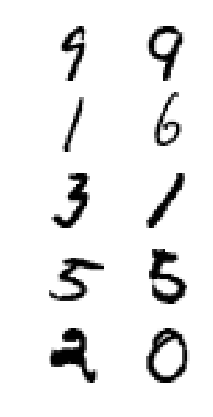

In [65]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [66]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [67]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [68]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6910327
0 테스트 정확도: 0.542
1 훈련 손실: 0.60353535
2 훈련 손실: 0.54946035
3 훈련 손실: 0.47047248
4 훈련 손실: 0.4060757
5 훈련 손실: 0.38308156
5 테스트 정확도: 0.824
6 훈련 손실: 0.39047274
7 훈련 손실: 0.3390794
8 훈련 손실: 0.32106707
9 훈련 손실: 0.31792688
10 훈련 손실: 0.24494287
10 테스트 정확도: 0.8881
11 훈련 손실: 0.29292363
12 훈련 손실: 0.23225445
13 훈련 손실: 0.23180929
14 훈련 손실: 0.1987793
15 훈련 손실: 0.20065454
15 테스트 정확도: 0.9203
16 훈련 손실: 0.19700494
17 훈련 손실: 0.18893145
18 훈련 손실: 0.19965446
19 훈련 손실: 0.24071638
20 훈련 손실: 0.18882029
20 테스트 정확도: 0.9367
21 훈련 손실: 0.124192014
22 훈련 손실: 0.14013422
23 훈련 손실: 0.1207895
24 훈련 손실: 0.15721153
25 훈련 손실: 0.11507862
25 테스트 정확도: 0.948
26 훈련 손실: 0.13891114
27 훈련 손실: 0.15260825
28 훈련 손실: 0.123436704
29 훈련 손실: 0.115431346
30 훈련 손실: 0.11402809
30 테스트 정확도: 0.9507
31 훈련 손실: 0.11897128
32 훈련 손실: 0.09546698
33 훈련 손실: 0.08299538
34 훈련 손실: 0.1365925
35 훈련 손실: 0.06801726
35 테스트 정확도: 0.9592
36 훈련 손실: 0.11016797
37 훈련 손실: 0.04950088
38 훈련 손실: 0.081340976
39 훈련 손실: 0.094419844
40 훈련 손실: 0.087371446
40

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [69]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [70]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9455
10 테스트 정확도: 0.9648
20 테스트 정확도: 0.9664
30 테스트 정확도: 0.9667
40 테스트 정확도: 0.9669
50 테스트 정확도: 0.9662
60 테스트 정확도: 0.9662
70 테스트 정확도: 0.966
80 테스트 정확도: 0.9664
90 테스트 정확도: 0.9662


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [72]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8694
10 테스트 정확도: 0.9276
20 테스트 정확도: 0.9283
30 테스트 정확도: 0.9375
40 테스트 정확도: 0.9428
50 테스트 정확도: 0.9434
60 테스트 정확도: 0.9437
70 테스트 정확도: 0.9438
80 테스트 정확도: 0.9437
90 테스트 정확도: 0.9439
100 테스트 정확도: 0.944
110 테스트 정확도: 0.9444
120 테스트 정확도: 0.9444
130 테스트 정확도: 0.9444
140 테스트 정확도: 0.9446


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!